<a href="https://colab.research.google.com/github/desstaw/Shortcut_Learning/blob/main/MNIST_28_alexnet_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchextractor

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
import torch
import sys
import numpy as np
import pickle as pkl
from os.path import join as oj
from datetime import datetime
import torch.optim as optim
import os
from torch.utils.data import TensorDataset, ConcatDataset, random_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score
import argparse
from PIL import Image
from tqdm import tqdm
from torch import nn
from numpy.random import randint
import torchvision.models as models
import time
import copy
import gc
import json
import pandas as pd
import torch
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
import torch.nn as nn


In [3]:
from google.colab import drive
drive.mount("/content/drive")
dir_path = "/content/drive/MyDrive/Masterthesis/Datasets/mnist"

Mounted at /content/drive


In [4]:
model_path = oj(dir_path, "models", "initial_classifier")
model_training_path = oj(model_path, "training_224")
data_path = oj(dir_path, "data")

In [8]:
'''
mean = np.asarray([0.485, 0.456, 0.406])
std = np.asarray([0.229, 0.224, 0.225])

# Define arguments
class Args:
    def __init__(self):
        self.batch_size = 64
        self.epochs = 100
        self.lr = 0.0001
        self.momentum = 0.9
        self.seed = 111
        self.regularizer_rate = 0.0
        #self.dropout_rate = 0.7

args = Args()

regularizer_rate = args.regularizer_rate
#dropout_rate = args.dropout_rate
num_epochs = args.epochs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(args.seed)
model = models.alexnet(pretrained=True)
#changing nn.Linear(4096, 1000) to nn.Linear(4096, 2) as alexnet was trained on imagenet with 1000 classes originally
model.classifier[-1] = nn.Linear(4096, 2)
model = model.to(device)

#for module in model.classifier.children():
    #if isinstance(module, nn.Dropout):
        #module.p = dropout_rate

params_to_update = model.parameters()
'''

"\nmean = np.asarray([0.485, 0.456, 0.406])\nstd = np.asarray([0.229, 0.224, 0.225])\n\n# Define arguments\nclass Args:\n    def __init__(self):\n        self.batch_size = 64\n        self.epochs = 100\n        self.lr = 0.0001\n        self.momentum = 0.9\n        self.seed = 111\n        self.regularizer_rate = 0.0\n        #self.dropout_rate = 0.7\n\nargs = Args()\n\nregularizer_rate = args.regularizer_rate\n#dropout_rate = args.dropout_rate\nnum_epochs = args.epochs\ndevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')\n\ntorch.manual_seed(args.seed)\nmodel = models.alexnet(pretrained=True)\n#changing nn.Linear(4096, 1000) to nn.Linear(4096, 2) as alexnet was trained on imagenet with 1000 classes originally\nmodel.classifier[-1] = nn.Linear(4096, 2)\nmodel = model.to(device)\n\n#for module in model.classifier.children():\n    #if isinstance(module, nn.Dropout):\n        #module.p = dropout_rate\n\nparams_to_update = model.parameters()\n"

## Dataset and Model setup

In [7]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
from torchvision import transforms

class MnistDataset(Dataset):
    def __init__(self, path: str = None, is_two: int = None, data_files=None, labels=None, group_labels=None):
        self.resize_shape = (64, 64)  # Target shape for resizing images
        self.transform = transforms.Compose([
            transforms.Resize(self.resize_shape),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))  # Normalize with mean and std for grayscale
        ])

        if path:  # If a path is provided, list all files in the directory and assign the class label
            self.path = path
            self.data_files = os.listdir(self.path)
            self.is_two = is_two
            self.labels = [is_two] * len(self.data_files) if is_two is not None else labels
            self.group_labels = group_labels if group_labels else [None] * len(self.data_files)
        else:  # Otherwise, use provided lists of data files and labels
            self.path = ''
            self.data_files = data_files
            self.labels = labels
            self.group_labels = group_labels if group_labels else [None] * len(data_files)
            self.is_two = is_two

    def __getitem__(self, i):
        # Read in the image
        img = Image.open(os.path.join(self.path, self.data_files[i])).convert("L")  # Convert to grayscale
        if self.transform:
            img = self.transform(img)  # Apply transformations

        # Determine the label
        is_two = self.is_two if self.is_two is not None else self.labels[i]
        group_label = self.group_labels[i]

        return (img, is_two, group_label)

    def __len__(self):  # Returns the total number of images in the dataset.
        return len(self.data_files)


A data processing class that matches the second version of the customized alexnet mentioned before with 3 RGB channels and 1000 outputs

In [ ]:
'''
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
from torchvision import transforms

class MnistDataset(Dataset):
    def __init__(self, path: str = None, is_two: int = None, data_files=None, labels=None, group_labels=None):
        self.resize_shape = (64, 64)  # Target shape for resizing images
        self.transform = transforms.Compose([
            transforms.Resize(self.resize_shape),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for RGB images
        ])

        if path:  # If a path is provided, list all files in the directory and assign the class label
            self.path = path
            self.data_files = os.listdir(self.path)
            self.is_two = is_two
            self.labels = [is_two] * len(self.data_files) if is_two is not None else labels
            self.group_labels = group_labels if group_labels else [None] * len(self.data_files)
        else:  # Otherwise, use provided lists of data files and labels
            self.path = ''
            self.data_files = data_files
            self.labels = labels
            self.group_labels = group_labels if group_labels else [None] * len(data_files)
            self.is_two = is_two

    def __getitem__(self, i):
        # Read in the image
        img = Image.open(os.path.join(self.path, self.data_files[i])).convert("RGB")  # Convert to RGB
        if self.transform:
            img = self.transform(img)  # Apply transformations

        # Determine the label
        is_two = self.is_two if self.is_two is not None else self.labels[i]
        group_label = self.group_labels[i]

        return (img, is_two, group_label)

    def __len__(self):  # Returns the total number of images in the dataset.
        return len(self.data_files)

'''

In [5]:
import torch
import torch.nn as nn

class AlexNet(nn.Module):
    def __init__(self, width_mult=1):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 32*64*64
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32*32*32
            nn.ReLU(inplace=True),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 64*32*32
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64*16*16
            nn.ReLU(inplace=True),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # 128*16*16
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # 256*16*16
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # 256*16*16
            nn.MaxPool2d(kernel_size=3, stride=2),  # 256*7*7
            nn.ReLU(inplace=True),
        )
        self.fc1 = nn.Linear(256 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 1)  # Single output for binary classification

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(-1, 256 * 7 * 7)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


1. Deep Learning for Image Classification: A Comprehensive Review
(Alzubaidi, Lina, et al. "Review of deep learning: Concepts, CNN architectures, challenges, applications, future directions." Journal of Big Data 8.1 (2021): 53.)
2. Deep Convolutional Neural Networks for Large-Scale Image Recognition
(Krizhevsky, Alex, Ilya Sutskever, and Geoffrey E. Hinton. "Imagenet classification with deep convolutional neural networks." Advances in neural information processing systems 25 (2012): 1097-1105)

In [ ]:
'''
import torch
import torch.nn as nn

class AlexNetMNIST(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNetMNIST, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # 32*28*28
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32*14*14
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 64*14*14
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64*7*7
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # 128*7*7
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # 256*7*7
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # 256*7*7
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 256*3*3
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 3 * 3, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 3 * 3)
        x = self.classifier(x)
        return x

# Example usage:
# model = AlexNetMNIST()
# print(model)
'''

Also a custom alexnet but with 1000 outputs as the standard one and 3 input RGB channels and not grayscale like the original one also

In [ ]:
'''
import torch
import torch.nn as nn

class AlexNet(nn.Module):
    def __init__(self, width_mult=1):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),  # 96*55*55 (for 224x224 input)
            nn.MaxPool2d(kernel_size=3, stride=2),  # 96*27*27
            nn.ReLU(inplace=True),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, padding=2),  # 256*27*27
            nn.MaxPool2d(kernel_size=3, stride=2),  # 256*13*13
            nn.ReLU(inplace=True),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, padding=1),  # 384*13*13
            nn.ReLU(inplace=True),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, padding=1),  # 384*13*13
            nn.ReLU(inplace=True),
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding=1),  # 256*13*13
            nn.MaxPool2d(kernel_size=3, stride=2),  # 256*6*6
            nn.ReLU(inplace=True),
        )
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 1000)  # 1000 output for multi-class classification

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(-1, 256 * 6 * 6)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# Example usage:
# model = AlexNet()
# print(model)
'''

## Function for Training

In [11]:
import torch.optim as optim
import torch.nn.functional as F
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_model(model, dataloaders, criterion, optimizer, num_epochs=100, resume_training=False):
    since = time.time()
    best_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())  # Initialize best_model_wts with the current model state

    # Initialize lists to track loss and accuracy
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(1, num_epochs + 1):
        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels, _ in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device).float()  # Convert labels to float for BCEWithLogitsLoss

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs).squeeze(1)  # Adjust output shape for binary classification
                    preds = torch.round(torch.sigmoid(outputs))  # Use sigmoid activation for binary classification
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.cpu().numpy())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.cpu().numpy())

                if epoch_acc > best_accuracy:
                    best_model_wts = copy.deepcopy(model.state_dict())
                    best_accuracy = epoch_acc
                    print("Saving Best Model with Validation Accuracy: ", epoch_acc.item())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Validation Accuracy: {best_accuracy:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Plot the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    # Plot the training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

    return model

Another function for training that matches the second custom alexnet with the 3 RGB channels and 1000 outputs

In [ ]:
'''
import torch.optim as optim
import torch.nn.functional as F
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_model(model, dataloaders, criterion, optimizer, num_epochs=100, resume_training=False):
    since = time.time()
    best_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())  # Initialize best_model_wts with the current model state

    # Initialize lists to track loss and accuracy
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(1, num_epochs + 1):
        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels, _ in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)  # No need to convert labels for CrossEntropyLoss

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)  # Use argmax for multi-class classification
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.cpu().numpy())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.cpu().numpy())

                if epoch_acc > best_accuracy:
                    best_model_wts = copy.deepcopy(model.state_dict())
                    best_accuracy = epoch_acc
                    print("Saving Best Model with Validation Accuracy: ", epoch_acc.item())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Validation Accuracy: {best_accuracy:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Plot the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    # Plot the training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

    return model
'''

## Train

If using the alexnet second custom version use the cross entropy loss instead of BCEWithLogits loss

In [ ]:
'''
for seed in seeds:
    args = Args(seed)

    # Set random seed for reproducibility
    torch.manual_seed(args.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model, optimizer, and loss function
    model = AlexNet().to(device)
    initialize_weights(model)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=0.0005)
    criterion = nn.CrossEntropyLoss()  # Change to CrossEntropyLoss for multi-class classification

    model = train_model(model, dataloaders, criterion, optimizer, num_epochs=args.epochs, resume_training=False)
    pid = datetime.now().strftime('%Y%m%d%H%M%S')
    torch.save(model.state_dict(), os.path.join(dir_path, model_path, f"alexnet_mnist_org_cl0_cl2_{seed}" + "train.pt"))
'''

### Original

In [12]:
#Train
two_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_2'
zero_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_0'
#two_bg_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_2'
#zero_bg_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_0_half'

#Test
test_two_bg_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/background/test/class_2'



# Create datasets for training and testing
dataset_two_org = MnistDataset(path=two_org_path, is_two=1, group_labels=[0] * len(os.listdir(two_org_path)))
dataset_zero_org = MnistDataset(path=zero_org_path, is_two=0, group_labels=[2] * len(os.listdir(zero_org_path)))

dataset_test_two_bg = MnistDataset(path=test_two_bg_path, is_two=1, group_labels=[1] * len(os.listdir(test_two_bg_path)))

# Concatenate the training datasets
complete_dataset = ConcatDataset((dataset_zero_org, dataset_two_org))



# Split the dataset into training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(complete_dataset))
val_size = len(complete_dataset) - train_size
train_dataset, val_dataset = random_split(complete_dataset, [train_size, val_size])

# Use the test dataset as is
test_dataset = dataset_test_two_bg

batch_size = 64

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Validate input data
#if not validate_inputs(train_loader):
#    print("Input data contains invalid values.")

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_val:", dataset_sizes['val'])
print("num_test:", dataset_sizes['test'])



num_train: 9504
num_val: 2377
num_test: 1032


Epoch 1/10
----------


100%|██████████| 149/149 [31:03<00:00, 12.51s/it]


train Loss: 1.6862 Acc: 0.9361


100%|██████████| 38/38 [07:01<00:00, 11.08s/it]


val Loss: 0.0348 Acc: 0.9882
Saving Best Model with Validation Accuracy:  0.9882204459402608
Epoch 2/10
----------


100%|██████████| 149/149 [00:29<00:00,  4.99it/s]


train Loss: 0.0198 Acc: 0.9927


100%|██████████| 38/38 [00:07<00:00,  4.78it/s]


val Loss: 0.0158 Acc: 0.9924
Saving Best Model with Validation Accuracy:  0.9924274295330249
Epoch 3/10
----------


100%|██████████| 149/149 [00:29<00:00,  5.01it/s]


train Loss: 0.0107 Acc: 0.9964


100%|██████████| 38/38 [00:06<00:00,  5.77it/s]


val Loss: 0.0119 Acc: 0.9945
Saving Best Model with Validation Accuracy:  0.9945309213294069
Epoch 4/10
----------


100%|██████████| 149/149 [00:29<00:00,  5.08it/s]


train Loss: 0.0078 Acc: 0.9976


100%|██████████| 38/38 [00:07<00:00,  4.86it/s]


val Loss: 0.0103 Acc: 0.9954
Saving Best Model with Validation Accuracy:  0.9953723180479597
Epoch 5/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.93it/s]


train Loss: 0.0057 Acc: 0.9980


100%|██████████| 38/38 [00:06<00:00,  5.67it/s]


val Loss: 0.0114 Acc: 0.9954
Epoch 6/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.88it/s]


train Loss: 0.0042 Acc: 0.9992


100%|██████████| 38/38 [00:08<00:00,  4.54it/s]


val Loss: 0.0086 Acc: 0.9958
Saving Best Model with Validation Accuracy:  0.995793016407236
Epoch 7/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.68it/s]


train Loss: 0.0036 Acc: 0.9989


100%|██████████| 38/38 [00:08<00:00,  4.71it/s]


val Loss: 0.0080 Acc: 0.9962
Saving Best Model with Validation Accuracy:  0.9962137147665124
Epoch 8/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.73it/s]


train Loss: 0.0031 Acc: 0.9993


100%|██████████| 38/38 [00:07<00:00,  5.29it/s]


val Loss: 0.0078 Acc: 0.9962
Epoch 9/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.80it/s]


train Loss: 0.0025 Acc: 0.9995


100%|██████████| 38/38 [00:08<00:00,  4.59it/s]


val Loss: 0.0079 Acc: 0.9958
Epoch 10/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.82it/s]


train Loss: 0.0021 Acc: 0.9996


100%|██████████| 38/38 [00:08<00:00,  4.70it/s]


val Loss: 0.0072 Acc: 0.9958
Training complete in 43m 49s
Best Validation Accuracy: 0.9962


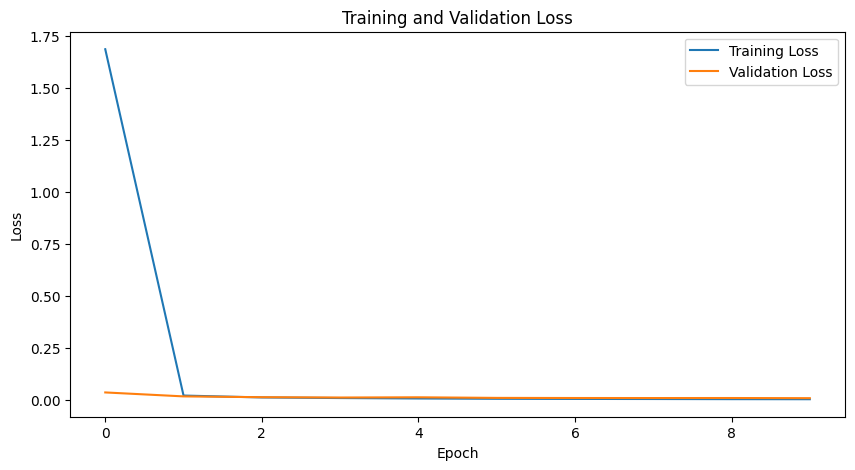

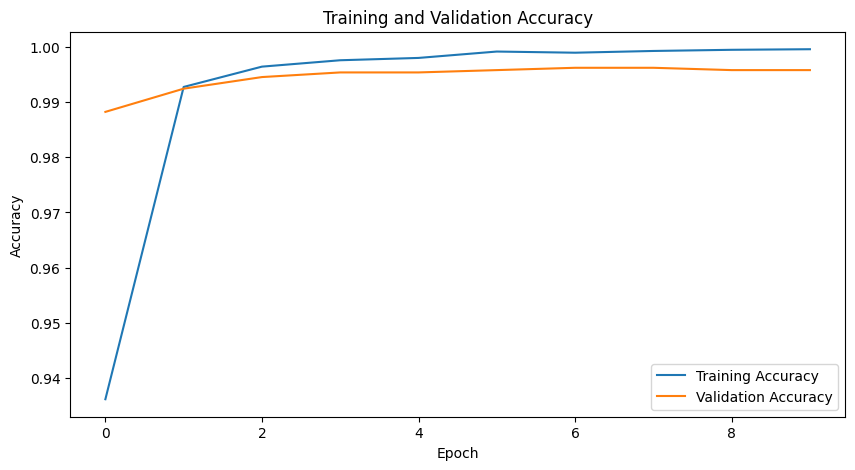

Epoch 1/10
----------


100%|██████████| 149/149 [00:32<00:00,  4.62it/s]


train Loss: 1.2152 Acc: 0.9259


100%|██████████| 38/38 [00:07<00:00,  4.83it/s]


val Loss: 0.0226 Acc: 0.9928
Saving Best Model with Validation Accuracy:  0.9928481278923013
Epoch 2/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.84it/s]


train Loss: 0.0181 Acc: 0.9940


100%|██████████| 38/38 [00:07<00:00,  4.78it/s]


val Loss: 0.0210 Acc: 0.9933
Saving Best Model with Validation Accuracy:  0.9932688262515776
Epoch 3/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.79it/s]


train Loss: 0.0123 Acc: 0.9962


100%|██████████| 38/38 [00:06<00:00,  5.43it/s]


val Loss: 0.0126 Acc: 0.9945
Saving Best Model with Validation Accuracy:  0.9945309213294069
Epoch 4/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.93it/s]


train Loss: 0.0095 Acc: 0.9971


100%|██████████| 38/38 [00:08<00:00,  4.67it/s]


val Loss: 0.0093 Acc: 0.9950
Saving Best Model with Validation Accuracy:  0.9949516196886833
Epoch 5/10
----------


100%|██████████| 149/149 [00:29<00:00,  5.02it/s]


train Loss: 0.0072 Acc: 0.9978


100%|██████████| 38/38 [00:06<00:00,  5.60it/s]


val Loss: 0.0081 Acc: 0.9958
Saving Best Model with Validation Accuracy:  0.995793016407236
Epoch 6/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.71it/s]


train Loss: 0.0065 Acc: 0.9976


100%|██████████| 38/38 [00:08<00:00,  4.62it/s]


val Loss: 0.0071 Acc: 0.9971
Saving Best Model with Validation Accuracy:  0.9970551114850652
Epoch 7/10
----------


100%|██████████| 149/149 [00:32<00:00,  4.66it/s]


train Loss: 0.0043 Acc: 0.9988


100%|██████████| 38/38 [00:08<00:00,  4.58it/s]


val Loss: 0.0122 Acc: 0.9958
Epoch 8/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.71it/s]


train Loss: 0.0039 Acc: 0.9989


100%|██████████| 38/38 [00:07<00:00,  5.16it/s]


val Loss: 0.0062 Acc: 0.9979
Saving Best Model with Validation Accuracy:  0.9978965082036181
Epoch 9/10
----------


100%|██████████| 149/149 [00:32<00:00,  4.64it/s]


train Loss: 0.0032 Acc: 0.9991


100%|██████████| 38/38 [00:07<00:00,  4.84it/s]


val Loss: 0.0060 Acc: 0.9971
Epoch 10/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.75it/s]


train Loss: 0.0024 Acc: 0.9995


100%|██████████| 38/38 [00:08<00:00,  4.60it/s]


val Loss: 0.0061 Acc: 0.9966
Training complete in 6m 31s
Best Validation Accuracy: 0.9979


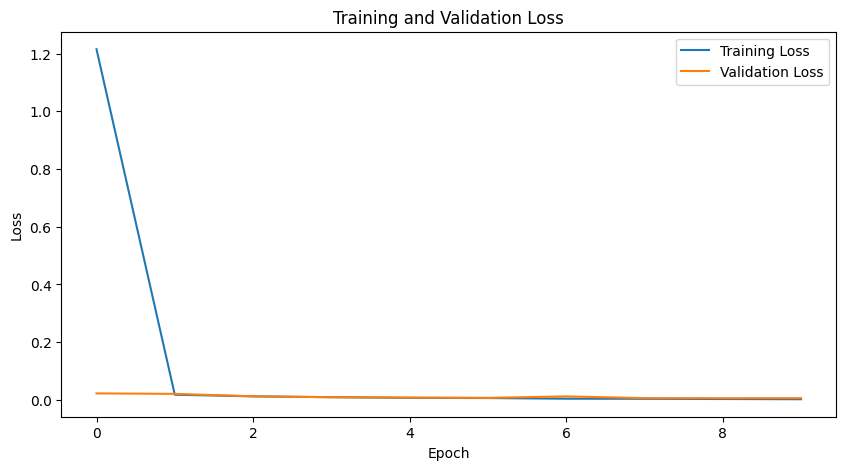

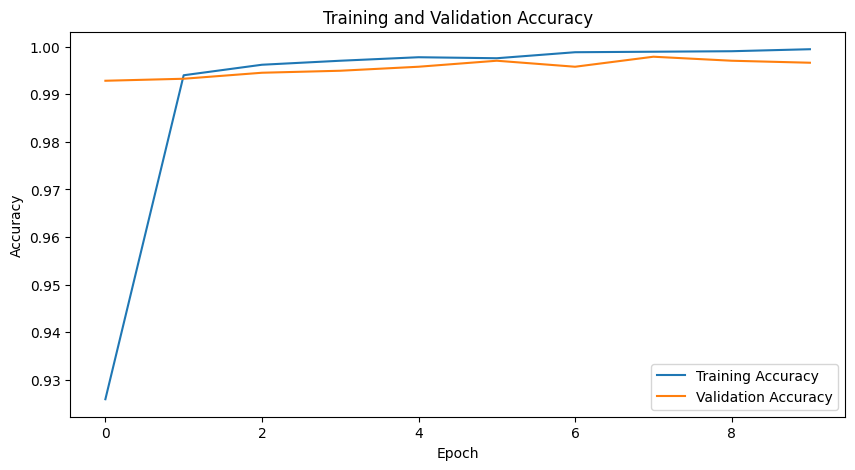

Epoch 1/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.70it/s]


train Loss: 1.2730 Acc: 0.9232


100%|██████████| 38/38 [00:07<00:00,  4.75it/s]


val Loss: 0.0250 Acc: 0.9907
Saving Best Model with Validation Accuracy:  0.9907446360959192
Epoch 2/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.87it/s]


train Loss: 0.0134 Acc: 0.9952


100%|██████████| 38/38 [00:07<00:00,  5.11it/s]


val Loss: 0.0116 Acc: 0.9954
Saving Best Model with Validation Accuracy:  0.9953723180479597
Epoch 3/10
----------


100%|██████████| 149/149 [00:29<00:00,  5.03it/s]


train Loss: 0.0078 Acc: 0.9976


100%|██████████| 38/38 [00:07<00:00,  5.12it/s]


val Loss: 0.0087 Acc: 0.9962
Saving Best Model with Validation Accuracy:  0.9962137147665124
Epoch 4/10
----------


100%|██████████| 149/149 [00:29<00:00,  5.01it/s]


train Loss: 0.0061 Acc: 0.9978


100%|██████████| 38/38 [00:07<00:00,  5.31it/s]


val Loss: 0.0127 Acc: 0.9958
Epoch 5/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.89it/s]


train Loss: 0.0050 Acc: 0.9986


100%|██████████| 38/38 [00:07<00:00,  5.05it/s]


val Loss: 0.0079 Acc: 0.9958
Epoch 6/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.73it/s]


train Loss: 0.0034 Acc: 0.9992


100%|██████████| 38/38 [00:08<00:00,  4.55it/s]


val Loss: 0.0055 Acc: 0.9966
Saving Best Model with Validation Accuracy:  0.9966344131257888
Epoch 7/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.81it/s]


train Loss: 0.0030 Acc: 0.9993


100%|██████████| 38/38 [00:06<00:00,  5.50it/s]


val Loss: 0.0056 Acc: 0.9962
Epoch 8/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.69it/s]


train Loss: 0.0036 Acc: 0.9991


100%|██████████| 38/38 [00:07<00:00,  4.80it/s]


val Loss: 0.0061 Acc: 0.9962
Epoch 9/10
----------


100%|██████████| 149/149 [00:32<00:00,  4.64it/s]


train Loss: 0.0022 Acc: 0.9994


100%|██████████| 38/38 [00:08<00:00,  4.63it/s]


val Loss: 0.0052 Acc: 0.9971
Saving Best Model with Validation Accuracy:  0.9970551114850652
Epoch 10/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.73it/s]


train Loss: 0.0020 Acc: 0.9995


100%|██████████| 38/38 [00:07<00:00,  5.31it/s]


val Loss: 0.0054 Acc: 0.9983
Saving Best Model with Validation Accuracy:  0.9983172065628945
Training complete in 6m 26s
Best Validation Accuracy: 0.9983


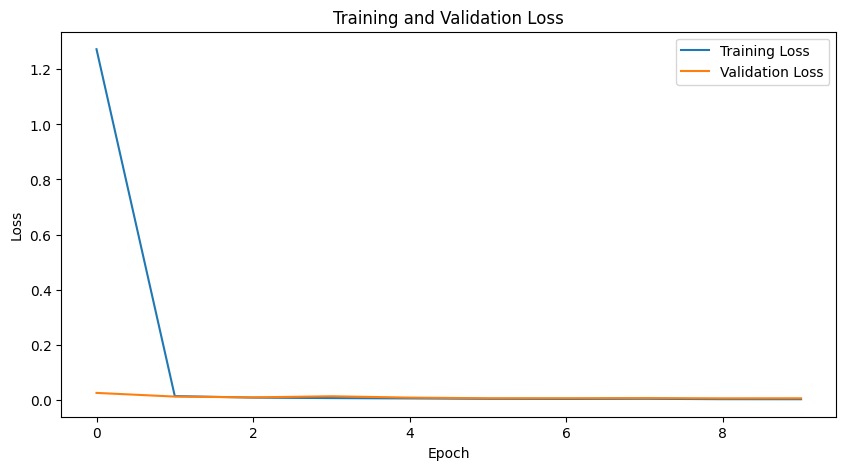

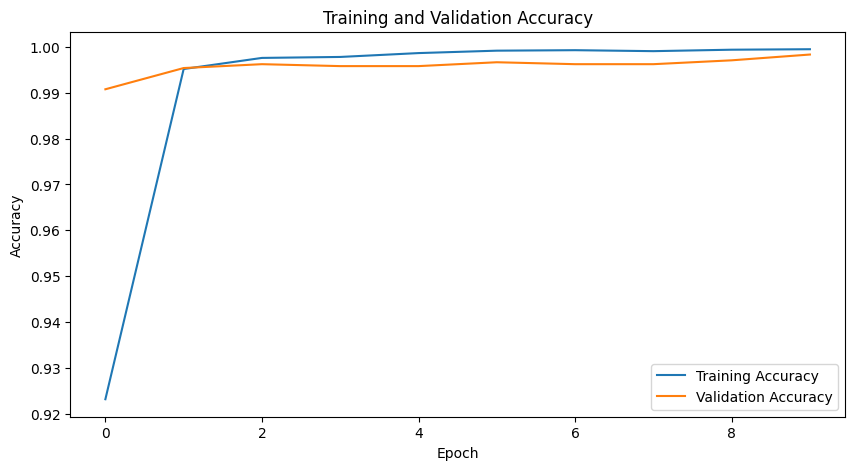

In [13]:
# Ensure weights are initialized if not using pre-trained
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

# Define arguments
class Args:
    def __init__(self, seed):
        self.batch_size = 64 #16
        self.epochs = 10
        self.lr = 0.001  # Lower the learning rate
        self.momentum = 0.9
        self.seed = seed
        self.regularizer_rate = 0.0
        #self.dropout_rate = 0.7

seeds = [1, 11, 111]

for seed in seeds:
    args = Args(seed)

    # Set random seed for reproducibility
    torch.manual_seed(args.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model, optimizer, and loss function
    model = AlexNet().to(device)
    initialize_weights(model)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=0.0005)
    criterion = nn.BCEWithLogitsLoss()

    model = train_model(model, dataloaders, criterion, optimizer, num_epochs=args.epochs, resume_training=False)
    pid = datetime.now().strftime('%Y%m%d%H%M%S')
    torch.save(model.state_dict(), os.path.join(dir_path, model_path, f"alexnet_mnist_org_cl0_cl2_{seed}" + "train.pt"))

In [14]:
#model = train_model(model, dataloaders, criterion, optimizer, num_epochs=args.epochs, resume_training=False)
#pid = datetime.now().strftime('%Y%m%d%H%M%S')
#torch.save(model.state_dict(), os.path.join(dir_path, model_path, f"alexnet_mnist_org_cl0_cl2_1" + "train.pt"))

### Background




In [16]:
#Train
two_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_2'
zero_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_0_half'
two_bg_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/background/train/class_2'
zero_bg_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/background/train/class_0_half'

#Test
test_two_bg_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/background/test/class_2'



# Create datasets for training and testing
dataset_two_org = MnistDataset(path=two_org_path, is_two=1, group_labels=[0] * len(os.listdir(two_org_path)))
dataset_zero_org = MnistDataset(path=zero_org_path, is_two=0, group_labels=[2] * len(os.listdir(zero_org_path)))
dataset_two_bg = MnistDataset(path=two_bg_path, is_two=1, group_labels=[1] * len(os.listdir(two_bg_path)))
dataset_zero_bg = MnistDataset(path=zero_bg_path, is_two=0, group_labels=[3] * len(os.listdir(zero_bg_path)))
dataset_test_two_bg = MnistDataset(path=test_two_bg_path, is_two=1, group_labels=[1] * len(os.listdir(test_two_bg_path)))

# Concatenate the training datasets
complete_dataset = ConcatDataset((dataset_zero_org, dataset_zero_bg, dataset_two_org))

# Set the random seed for reproducibility
seed = 1
torch.manual_seed(seed)

# Split the dataset into training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(complete_dataset))
val_size = len(complete_dataset) - train_size
train_dataset, val_dataset = random_split(complete_dataset, [train_size, val_size])

# Use the test dataset as is
test_dataset = dataset_test_two_bg

batch_size = 64

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Validate input data
#if not validate_inputs(train_loader):
#    print("Input data contains invalid values.")

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_val:", dataset_sizes['val'])
print("num_test:", dataset_sizes['test'])



num_train: 14243
num_val: 3561
num_test: 1032


Epoch 1/10
----------


100%|██████████| 223/223 [50:28<00:00, 13.58s/it]


train Loss: 0.8631 Acc: 0.9505


100%|██████████| 56/56 [13:07<00:00, 14.07s/it]


val Loss: 0.0129 Acc: 0.9963
Saving Best Model with Validation Accuracy:  0.9963493400730132
Epoch 2/10
----------


100%|██████████| 223/223 [00:44<00:00,  4.97it/s]


train Loss: 0.0100 Acc: 0.9970


100%|██████████| 56/56 [00:12<00:00,  4.64it/s]


val Loss: 0.0076 Acc: 0.9975
Saving Best Model with Validation Accuracy:  0.9974726200505476
Epoch 3/10
----------


100%|██████████| 223/223 [00:46<00:00,  4.79it/s]


train Loss: 0.0055 Acc: 0.9979


100%|██████████| 56/56 [00:11<00:00,  4.88it/s]


val Loss: 0.0042 Acc: 0.9989
Saving Best Model with Validation Accuracy:  0.9988767200224656
Epoch 4/10
----------


100%|██████████| 223/223 [00:46<00:00,  4.79it/s]


train Loss: 0.0039 Acc: 0.9992


100%|██████████| 56/56 [00:10<00:00,  5.19it/s]


val Loss: 0.0047 Acc: 0.9989
Epoch 5/10
----------


100%|██████████| 223/223 [00:47<00:00,  4.72it/s]


train Loss: 0.0031 Acc: 0.9991


100%|██████████| 56/56 [00:10<00:00,  5.18it/s]


val Loss: 0.0035 Acc: 0.9980
Epoch 6/10
----------


100%|██████████| 223/223 [00:47<00:00,  4.65it/s]


train Loss: 0.0023 Acc: 0.9994


100%|██████████| 56/56 [00:10<00:00,  5.15it/s]


val Loss: 0.0069 Acc: 0.9978
Epoch 7/10
----------


100%|██████████| 223/223 [00:47<00:00,  4.69it/s]


train Loss: 0.0019 Acc: 0.9994


100%|██████████| 56/56 [00:11<00:00,  5.08it/s]


val Loss: 0.0038 Acc: 0.9980
Epoch 8/10
----------


100%|██████████| 223/223 [00:47<00:00,  4.66it/s]


train Loss: 0.0012 Acc: 0.9998


100%|██████████| 56/56 [00:10<00:00,  5.19it/s]


val Loss: 0.0035 Acc: 0.9980
Epoch 9/10
----------


100%|██████████| 223/223 [00:45<00:00,  4.93it/s]


train Loss: 0.0009 Acc: 0.9999


100%|██████████| 56/56 [00:11<00:00,  4.97it/s]


val Loss: 0.0043 Acc: 0.9980
Epoch 10/10
----------


100%|██████████| 223/223 [00:44<00:00,  5.05it/s]


train Loss: 0.0009 Acc: 0.9999


100%|██████████| 56/56 [00:11<00:00,  5.02it/s]


val Loss: 0.0026 Acc: 0.9992
Saving Best Model with Validation Accuracy:  0.9991575400168492
Training complete in 72m 15s
Best Validation Accuracy: 0.9992


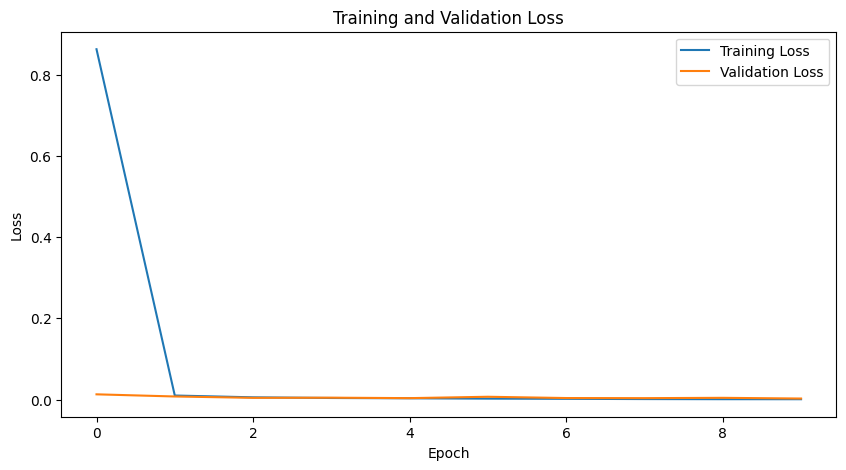

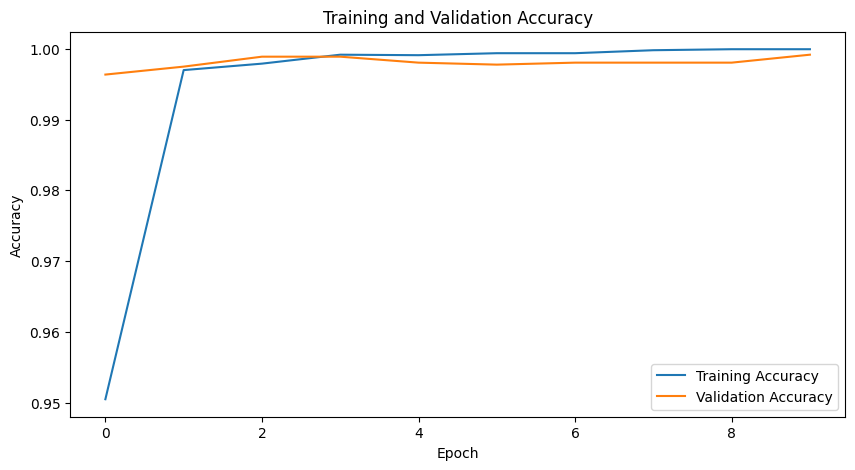

Epoch 1/10
----------


100%|██████████| 223/223 [00:45<00:00,  4.87it/s]


train Loss: 0.7905 Acc: 0.9485


100%|██████████| 56/56 [00:11<00:00,  4.85it/s]


val Loss: 0.0161 Acc: 0.9949
Saving Best Model with Validation Accuracy:  0.9949452401010952
Epoch 2/10
----------


100%|██████████| 223/223 [00:46<00:00,  4.78it/s]


train Loss: 0.0130 Acc: 0.9962


100%|██████████| 56/56 [00:11<00:00,  4.78it/s]


val Loss: 0.0082 Acc: 0.9975
Saving Best Model with Validation Accuracy:  0.9974726200505476
Epoch 3/10
----------


100%|██████████| 223/223 [00:46<00:00,  4.83it/s]


train Loss: 0.0093 Acc: 0.9966


100%|██████████| 56/56 [00:11<00:00,  4.99it/s]


val Loss: 0.0065 Acc: 0.9980
Saving Best Model with Validation Accuracy:  0.9980342600393148
Epoch 4/10
----------


100%|██████████| 223/223 [00:44<00:00,  5.03it/s]


train Loss: 0.0051 Acc: 0.9985


100%|██████████| 56/56 [00:09<00:00,  5.69it/s]


val Loss: 0.0038 Acc: 0.9989
Saving Best Model with Validation Accuracy:  0.9988767200224656
Epoch 5/10
----------


100%|██████████| 223/223 [00:44<00:00,  5.05it/s]


train Loss: 0.0041 Acc: 0.9988


100%|██████████| 56/56 [00:11<00:00,  5.09it/s]


val Loss: 0.0034 Acc: 0.9989
Epoch 6/10
----------


100%|██████████| 223/223 [00:43<00:00,  5.08it/s]


train Loss: 0.0028 Acc: 0.9994


100%|██████████| 56/56 [00:10<00:00,  5.11it/s]


val Loss: 0.0032 Acc: 0.9992
Saving Best Model with Validation Accuracy:  0.9991575400168492
Epoch 7/10
----------


100%|██████████| 223/223 [00:44<00:00,  4.97it/s]


train Loss: 0.0024 Acc: 0.9992


100%|██████████| 56/56 [00:10<00:00,  5.14it/s]


val Loss: 0.0031 Acc: 0.9989
Epoch 8/10
----------


100%|██████████| 223/223 [00:45<00:00,  4.89it/s]


train Loss: 0.0017 Acc: 0.9997


100%|██████████| 56/56 [00:11<00:00,  5.06it/s]


val Loss: 0.0050 Acc: 0.9986
Epoch 9/10
----------


100%|██████████| 223/223 [00:45<00:00,  4.95it/s]


train Loss: 0.0016 Acc: 0.9997


100%|██████████| 56/56 [00:10<00:00,  5.57it/s]


val Loss: 0.0027 Acc: 0.9992
Epoch 10/10
----------


100%|██████████| 223/223 [00:46<00:00,  4.79it/s]


train Loss: 0.0014 Acc: 0.9996


100%|██████████| 56/56 [00:11<00:00,  4.87it/s]


val Loss: 0.0028 Acc: 0.9992
Training complete in 9m 23s
Best Validation Accuracy: 0.9992


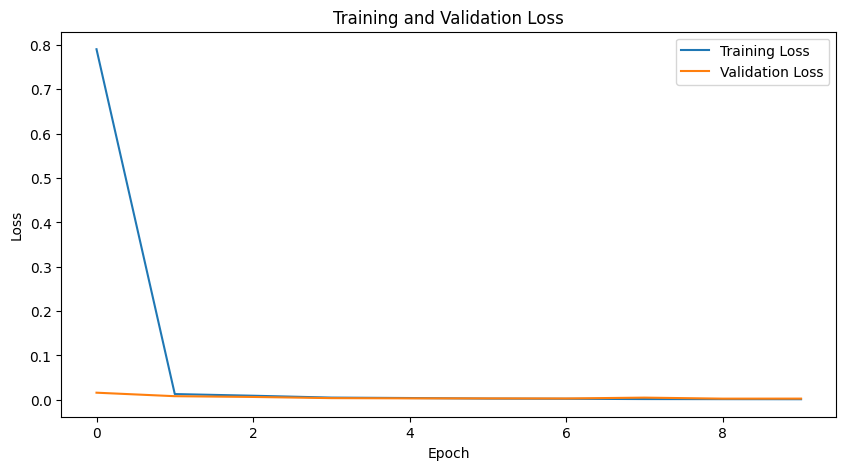

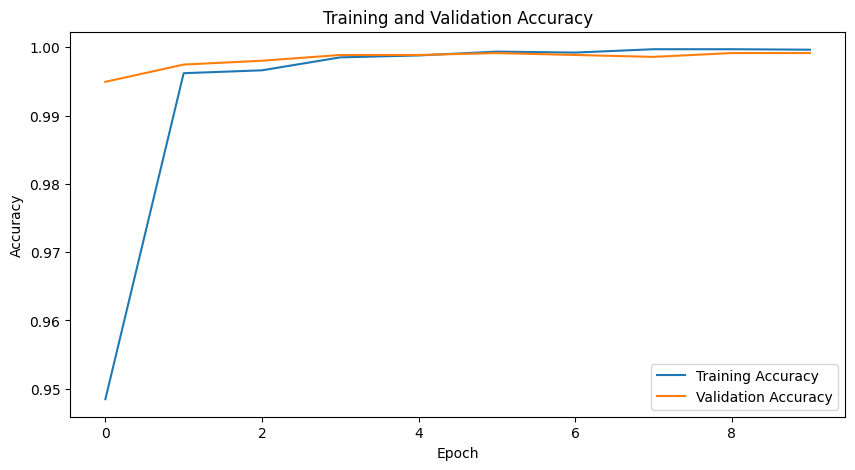

Epoch 1/10
----------


100%|██████████| 223/223 [00:45<00:00,  4.87it/s]


train Loss: 0.5775 Acc: 0.9692


100%|██████████| 56/56 [00:11<00:00,  4.97it/s]


val Loss: 0.0121 Acc: 0.9952
Saving Best Model with Validation Accuracy:  0.9952260600954788
Epoch 2/10
----------


100%|██████████| 223/223 [00:46<00:00,  4.79it/s]


train Loss: 0.0097 Acc: 0.9970


100%|██████████| 56/56 [00:11<00:00,  4.81it/s]


val Loss: 0.0076 Acc: 0.9972
Saving Best Model with Validation Accuracy:  0.997191800056164
Epoch 3/10
----------


100%|██████████| 223/223 [00:44<00:00,  4.97it/s]


train Loss: 0.0056 Acc: 0.9984


100%|██████████| 56/56 [00:11<00:00,  5.03it/s]


val Loss: 0.0057 Acc: 0.9980
Saving Best Model with Validation Accuracy:  0.9980342600393148
Epoch 4/10
----------


100%|██████████| 223/223 [00:44<00:00,  4.99it/s]


train Loss: 0.0045 Acc: 0.9985


100%|██████████| 56/56 [00:10<00:00,  5.25it/s]


val Loss: 0.0048 Acc: 0.9986
Saving Best Model with Validation Accuracy:  0.998595900028082
Epoch 5/10
----------


100%|██████████| 223/223 [00:46<00:00,  4.84it/s]


train Loss: 0.0028 Acc: 0.9994


100%|██████████| 56/56 [00:10<00:00,  5.23it/s]


val Loss: 0.0053 Acc: 0.9983
Epoch 6/10
----------


100%|██████████| 223/223 [00:46<00:00,  4.78it/s]


train Loss: 0.0025 Acc: 0.9994


100%|██████████| 56/56 [00:11<00:00,  4.98it/s]


val Loss: 0.0046 Acc: 0.9986
Epoch 7/10
----------


100%|██████████| 223/223 [00:48<00:00,  4.61it/s]


train Loss: 0.0022 Acc: 0.9992


100%|██████████| 56/56 [00:11<00:00,  4.94it/s]


val Loss: 0.0038 Acc: 0.9986
Epoch 8/10
----------


100%|██████████| 223/223 [00:47<00:00,  4.67it/s]


train Loss: 0.0019 Acc: 0.9994


100%|██████████| 56/56 [00:11<00:00,  5.05it/s]


val Loss: 0.0035 Acc: 0.9989
Saving Best Model with Validation Accuracy:  0.9988767200224656
Epoch 9/10
----------


100%|██████████| 223/223 [00:46<00:00,  4.78it/s]


train Loss: 0.0013 Acc: 0.9997


100%|██████████| 56/56 [00:10<00:00,  5.39it/s]


val Loss: 0.0023 Acc: 0.9992
Saving Best Model with Validation Accuracy:  0.9991575400168492
Epoch 10/10
----------


100%|██████████| 223/223 [00:45<00:00,  4.94it/s]


train Loss: 0.0011 Acc: 0.9999


100%|██████████| 56/56 [00:11<00:00,  5.08it/s]


val Loss: 0.0033 Acc: 0.9989
Training complete in 9m 33s
Best Validation Accuracy: 0.9992


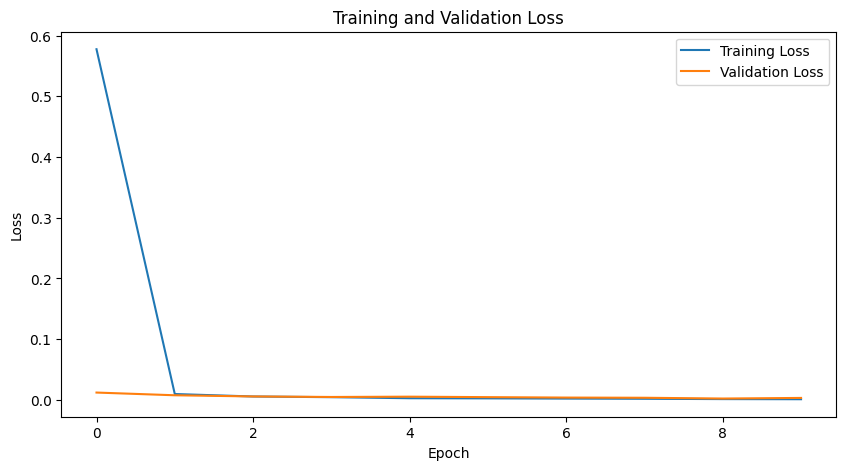

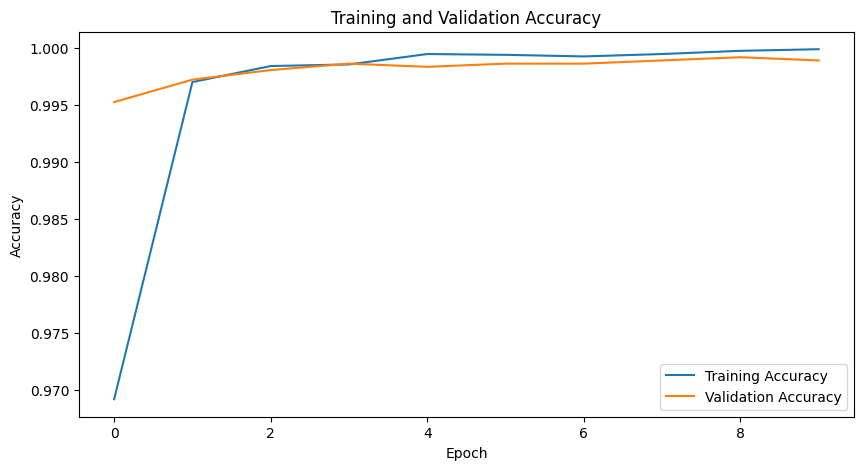

In [17]:
# Ensure weights are initialized if not using pre-trained
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

initialize_weights(model)


# Define arguments
class Args:
    def __init__(self, seed):
        self.batch_size = 64 #16
        self.epochs = 10
        self.lr = 0.001 #0.00001
        self.momentum = 0.9
        self.seed = seed
        self.regularizer_rate = 0.0
        #self.dropout_rate = 0.7

seeds = [1, 11, 111]

for seed in seeds:
    args = Args(seed)

    # Set random seed for reproducibility
    torch.manual_seed(args.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model, optimizer, and loss function
    model = AlexNet().to(device)
    initialize_weights(model)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=0.0005)
    criterion = nn.BCEWithLogitsLoss()

    model = train_model(model, dataloaders, criterion, optimizer, num_epochs=args.epochs, resume_training=False)
    pid = datetime.now().strftime('%Y%m%d%H%M%S')
    torch.save(model.state_dict(), os.path.join(dir_path, model_path, f"alexnet_mnist_bg_cl0_cl2_{seed}" + "train.pt"))



### Foreground

In [18]:
#Train
two_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_2'
zero_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_0_half' #first half
two_fg_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/foreground/train/class_2'
zero_fg_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/foreground/train/class_0_half' #second half

#Test
test_two_fg_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/foreground/test/class_2'



# Create datasets for training and testing
dataset_two_org = MnistDataset(path=two_org_path, is_two=1, group_labels=[0] * len(os.listdir(two_org_path)))
dataset_zero_org = MnistDataset(path=zero_org_path, is_two=0, group_labels=[2] * len(os.listdir(zero_org_path)))
dataset_two_fg = MnistDataset(path=two_fg_path, is_two=1, group_labels=[1] * len(os.listdir(two_fg_path)))
dataset_zero_fg = MnistDataset(path=zero_fg_path, is_two=0, group_labels=[3] * len(os.listdir(zero_fg_path)))
dataset_test_two_fg = MnistDataset(path=test_two_fg_path, is_two=1, group_labels=[1] * len(os.listdir(test_two_fg_path)))

# Concatenate the training datasets
complete_dataset = ConcatDataset((dataset_zero_org, dataset_zero_fg, dataset_two_org))

# Set the random seed for reproducibility
seed = 1
torch.manual_seed(seed)

# Split the dataset into training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(complete_dataset))
val_size = len(complete_dataset) - train_size
train_dataset, val_dataset = random_split(complete_dataset, [train_size, val_size])

# Use the test dataset as is
test_dataset = dataset_test_two_fg

batch_size = 64

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Validate input data
#if not validate_inputs(train_loader):
#    print("Input data contains invalid values.")

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_val:", dataset_sizes['val'])
print("num_test:", dataset_sizes['test'])



num_train: 11873
num_val: 2969
num_test: 1032


Epoch 1/10
----------


100%|██████████| 186/186 [02:00<00:00,  1.54it/s]


train Loss: 1.7340 Acc: 0.9362


100%|██████████| 47/47 [00:09<00:00,  5.04it/s]


val Loss: 0.0201 Acc: 0.9926
Saving Best Model with Validation Accuracy:  0.9925900976759852
Epoch 2/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.79it/s]


train Loss: 0.0165 Acc: 0.9950


100%|██████████| 47/47 [00:08<00:00,  5.68it/s]


val Loss: 0.0126 Acc: 0.9939
Saving Best Model with Validation Accuracy:  0.9939373526439879
Epoch 3/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.90it/s]


train Loss: 0.0104 Acc: 0.9962


100%|██████████| 47/47 [00:09<00:00,  4.94it/s]


val Loss: 0.0096 Acc: 0.9963
Saving Best Model with Validation Accuracy:  0.9962950488379926
Epoch 4/10
----------


100%|██████████| 186/186 [00:37<00:00,  5.00it/s]


train Loss: 0.0091 Acc: 0.9969


100%|██████████| 47/47 [00:09<00:00,  4.96it/s]


val Loss: 0.0086 Acc: 0.9970
Saving Best Model with Validation Accuracy:  0.9969686763219939
Epoch 5/10
----------


100%|██████████| 186/186 [00:36<00:00,  5.15it/s]


train Loss: 0.0064 Acc: 0.9979


100%|██████████| 47/47 [00:09<00:00,  4.90it/s]


val Loss: 0.0063 Acc: 0.9980
Saving Best Model with Validation Accuracy:  0.997979117547996
Epoch 6/10
----------


100%|██████████| 186/186 [00:36<00:00,  5.16it/s]


train Loss: 0.0054 Acc: 0.9981


100%|██████████| 47/47 [00:09<00:00,  4.97it/s]


val Loss: 0.0067 Acc: 0.9973
Epoch 7/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.99it/s]


train Loss: 0.0047 Acc: 0.9985


100%|██████████| 47/47 [00:08<00:00,  5.34it/s]


val Loss: 0.0054 Acc: 0.9973
Epoch 8/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.98it/s]


train Loss: 0.0047 Acc: 0.9985


100%|██████████| 47/47 [00:08<00:00,  5.42it/s]


val Loss: 0.0061 Acc: 0.9976
Epoch 9/10
----------


100%|██████████| 186/186 [00:39<00:00,  4.74it/s]


train Loss: 0.0030 Acc: 0.9992


100%|██████████| 47/47 [00:09<00:00,  4.77it/s]


val Loss: 0.0057 Acc: 0.9976
Epoch 10/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.87it/s]


train Loss: 0.0032 Acc: 0.9989


100%|██████████| 47/47 [00:09<00:00,  4.83it/s]


val Loss: 0.0078 Acc: 0.9966
Training complete in 9m 12s
Best Validation Accuracy: 0.9980


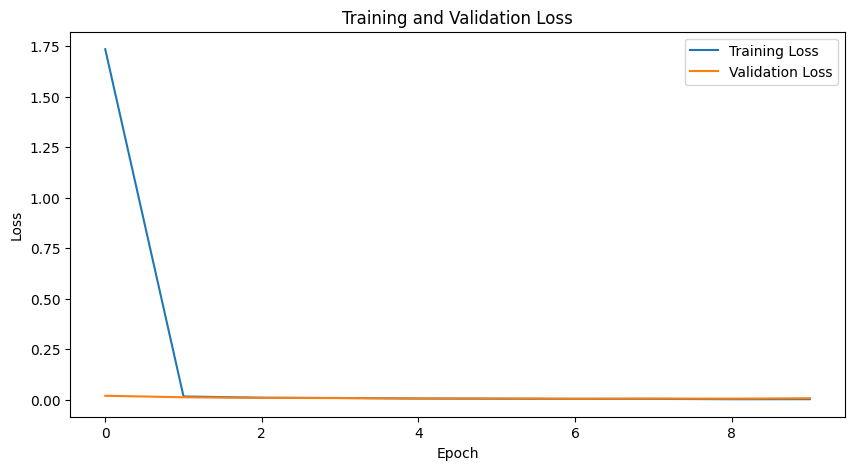

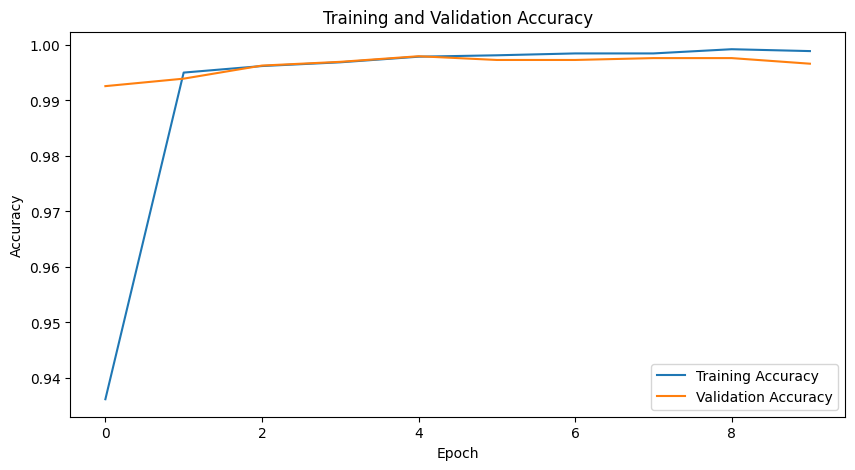

Epoch 1/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.99it/s]


train Loss: 0.9112 Acc: 0.9501


100%|██████████| 47/47 [00:08<00:00,  5.28it/s]


val Loss: 0.0287 Acc: 0.9909
Saving Best Model with Validation Accuracy:  0.9909060289659818
Epoch 2/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.99it/s]


train Loss: 0.0159 Acc: 0.9954


100%|██████████| 47/47 [00:08<00:00,  5.56it/s]


val Loss: 0.0093 Acc: 0.9966
Saving Best Model with Validation Accuracy:  0.9966318625799933
Epoch 3/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.94it/s]


train Loss: 0.0072 Acc: 0.9978


100%|██████████| 47/47 [00:08<00:00,  5.51it/s]


val Loss: 0.0081 Acc: 0.9970
Saving Best Model with Validation Accuracy:  0.9969686763219939
Epoch 4/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.94it/s]


train Loss: 0.0054 Acc: 0.9979


100%|██████████| 47/47 [00:08<00:00,  5.53it/s]


val Loss: 0.0045 Acc: 0.9983
Saving Best Model with Validation Accuracy:  0.9983159312899966
Epoch 5/10
----------


100%|██████████| 186/186 [00:36<00:00,  5.07it/s]


train Loss: 0.0034 Acc: 0.9989


100%|██████████| 47/47 [00:08<00:00,  5.35it/s]


val Loss: 0.0049 Acc: 0.9987
Saving Best Model with Validation Accuracy:  0.9986527450319973
Epoch 6/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.95it/s]


train Loss: 0.0032 Acc: 0.9987


100%|██████████| 47/47 [00:09<00:00,  4.90it/s]


val Loss: 0.0034 Acc: 0.9990
Saving Best Model with Validation Accuracy:  0.998989558773998
Epoch 7/10
----------


100%|██████████| 186/186 [00:36<00:00,  5.07it/s]


train Loss: 0.0021 Acc: 0.9996


100%|██████████| 47/47 [00:09<00:00,  4.97it/s]


val Loss: 0.0048 Acc: 0.9976
Epoch 8/10
----------


100%|██████████| 186/186 [00:35<00:00,  5.19it/s]


train Loss: 0.0020 Acc: 0.9996


100%|██████████| 47/47 [00:09<00:00,  4.98it/s]


val Loss: 0.0028 Acc: 0.9993
Saving Best Model with Validation Accuracy:  0.9993263725159987
Epoch 9/10
----------


100%|██████████| 186/186 [00:36<00:00,  5.10it/s]


train Loss: 0.0014 Acc: 0.9996


100%|██████████| 47/47 [00:09<00:00,  5.15it/s]


val Loss: 0.0023 Acc: 0.9993
Epoch 10/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.99it/s]


train Loss: 0.0013 Acc: 0.9998


100%|██████████| 47/47 [00:08<00:00,  5.47it/s]


val Loss: 0.0030 Acc: 0.9997
Saving Best Model with Validation Accuracy:  0.9996631862579993
Training complete in 7m 40s
Best Validation Accuracy: 0.9997


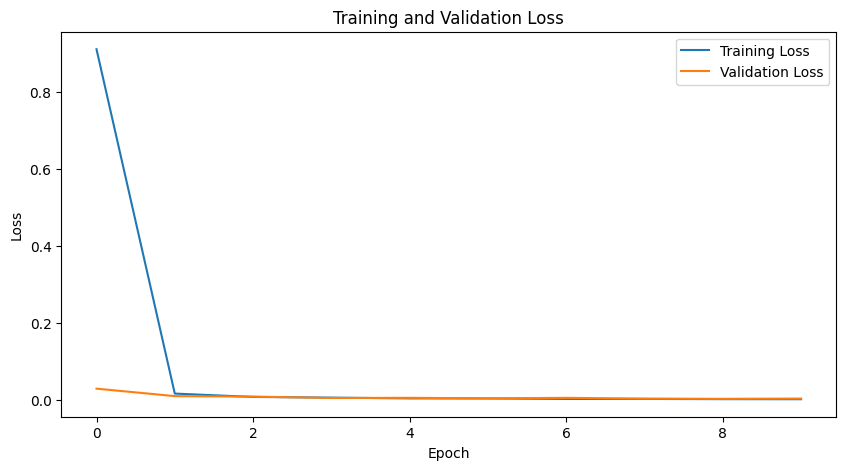

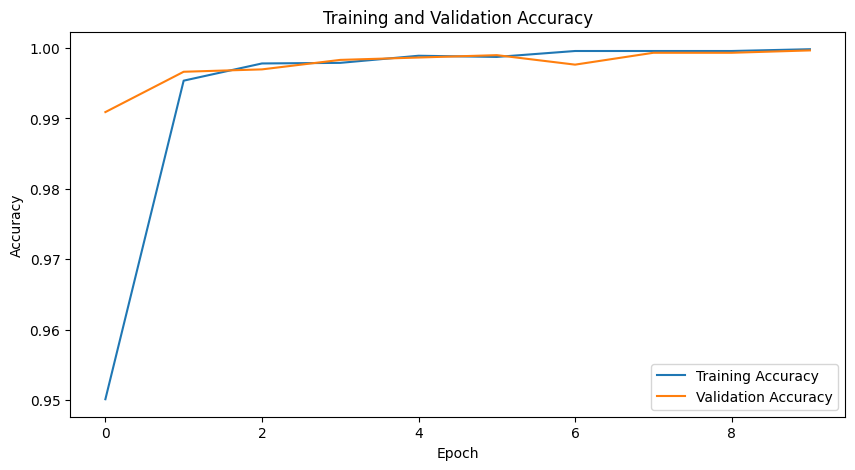

Epoch 1/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.82it/s]


train Loss: 0.4900 Acc: 0.9737


100%|██████████| 47/47 [00:08<00:00,  5.38it/s]


val Loss: 0.0120 Acc: 0.9956
Saving Best Model with Validation Accuracy:  0.9956214213539912
Epoch 2/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.90it/s]


train Loss: 0.0094 Acc: 0.9966


100%|██████████| 47/47 [00:09<00:00,  4.87it/s]


val Loss: 0.0081 Acc: 0.9966
Saving Best Model with Validation Accuracy:  0.9966318625799933
Epoch 3/10
----------


100%|██████████| 186/186 [00:37<00:00,  5.02it/s]


train Loss: 0.0058 Acc: 0.9978


100%|██████████| 47/47 [00:09<00:00,  4.91it/s]


val Loss: 0.0094 Acc: 0.9970
Saving Best Model with Validation Accuracy:  0.9969686763219939
Epoch 4/10
----------


100%|██████████| 186/186 [00:36<00:00,  5.10it/s]


train Loss: 0.0043 Acc: 0.9984


100%|██████████| 47/47 [00:09<00:00,  4.80it/s]


val Loss: 0.0058 Acc: 0.9983
Saving Best Model with Validation Accuracy:  0.9983159312899966
Epoch 5/10
----------


100%|██████████| 186/186 [00:36<00:00,  5.07it/s]


train Loss: 0.0037 Acc: 0.9987


100%|██████████| 47/47 [00:09<00:00,  5.04it/s]


val Loss: 0.0043 Acc: 0.9987
Saving Best Model with Validation Accuracy:  0.9986527450319973
Epoch 6/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.80it/s]


train Loss: 0.0024 Acc: 0.9994


100%|██████████| 47/47 [00:08<00:00,  5.32it/s]


val Loss: 0.0047 Acc: 0.9976
Epoch 7/10
----------


100%|██████████| 186/186 [00:39<00:00,  4.75it/s]


train Loss: 0.0020 Acc: 0.9995


100%|██████████| 47/47 [00:09<00:00,  5.06it/s]


val Loss: 0.0037 Acc: 0.9987
Epoch 8/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.87it/s]


train Loss: 0.0016 Acc: 0.9997


100%|██████████| 47/47 [00:09<00:00,  4.78it/s]


val Loss: 0.0036 Acc: 0.9987
Epoch 9/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.92it/s]


train Loss: 0.0014 Acc: 0.9997


100%|██████████| 47/47 [00:09<00:00,  4.71it/s]


val Loss: 0.0039 Acc: 0.9987
Epoch 10/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.78it/s]


train Loss: 0.0011 Acc: 0.9999


100%|██████████| 47/47 [00:08<00:00,  5.66it/s]


val Loss: 0.0042 Acc: 0.9987
Training complete in 7m 53s
Best Validation Accuracy: 0.9987


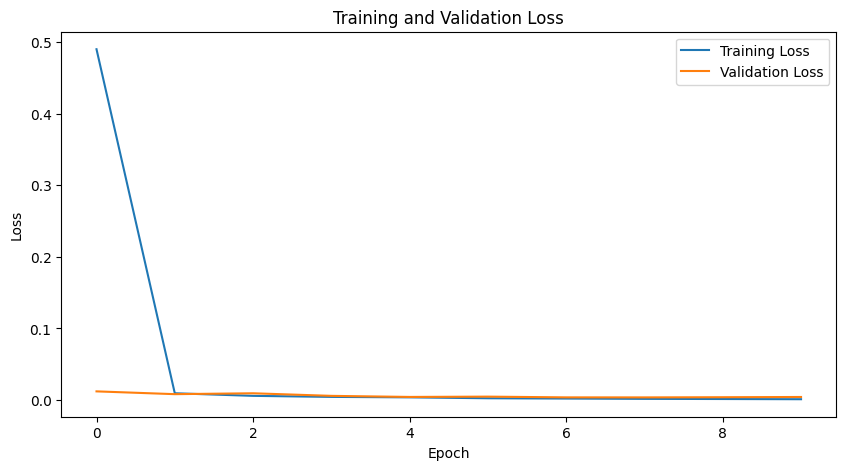

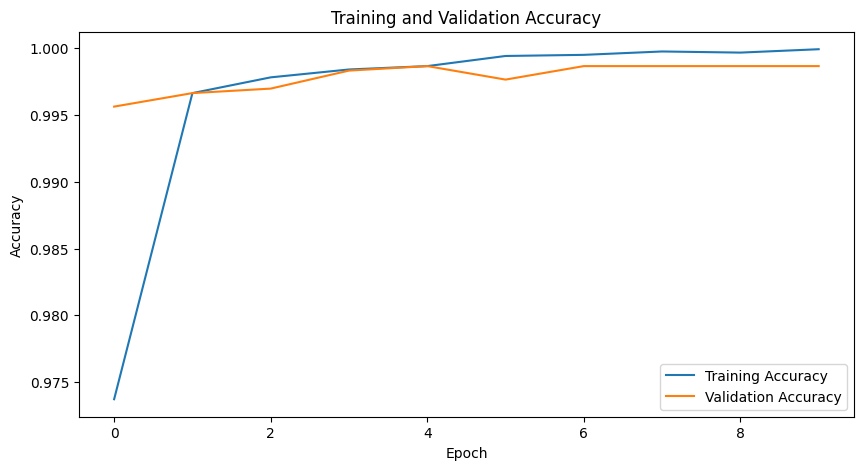

In [19]:
# Ensure weights are initialized if not using pre-trained
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

initialize_weights(model)


# Define arguments
class Args:
    def __init__(self, seed):
        self.batch_size = 64 #16
        self.epochs = 10
        self.lr = 0.001 #0.00001
        self.momentum = 0.9
        self.seed = seed
        self.regularizer_rate = 0.0
        #self.dropout_rate = 0.7

seeds = [1, 11, 111]

for seed in seeds:
    args = Args(seed)

    # Set random seed for reproducibility
    torch.manual_seed(args.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model, optimizer, and loss function
    model = AlexNet().to(device)
    initialize_weights(model)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=0.0005)
    criterion = nn.BCEWithLogitsLoss()

    model = train_model(model, dataloaders, criterion, optimizer, num_epochs=args.epochs, resume_training=False)
    pid = datetime.now().strftime('%Y%m%d%H%M%S')
    torch.save(model.state_dict(), os.path.join(dir_path, model_path, f"alexnet_mnist_fg_cl0_cl2_{seed}" + "train.pt"))



### Left patch

In [20]:
#Train
two_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_2'
zero_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_0_half'
two_lp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/train/class_2'
zero_lp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/train/class_0_half'

#Test
test_two_lp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/test/class_2'



# Create datasets for training and testing
dataset_two_org = MnistDataset(path=two_org_path, is_two=1, group_labels=[0] * len(os.listdir(two_org_path)))
dataset_zero_org = MnistDataset(path=zero_org_path, is_two=0, group_labels=[2] * len(os.listdir(zero_org_path)))
dataset_two_lp = MnistDataset(path=two_lp_path, is_two=1, group_labels=[1] * len(os.listdir(two_lp_path)))
dataset_zero_lp = MnistDataset(path=zero_lp_path, is_two=0, group_labels=[3] * len(os.listdir(zero_lp_path)))
dataset_test_two_lp = MnistDataset(path=test_two_lp_path, is_two=1, group_labels=[1] * len(os.listdir(test_two_lp_path)))

# Concatenate the training datasets
complete_dataset = ConcatDataset((dataset_zero_org, dataset_zero_lp, dataset_two_org))

# Set the random seed for reproducibility
seed = 1
torch.manual_seed(seed)

# Split the dataset into training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(complete_dataset))
val_size = len(complete_dataset) - train_size
train_dataset, val_dataset = random_split(complete_dataset, [train_size, val_size])

# Use the test dataset as is
test_dataset = dataset_test_two_lp

batch_size = 64

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Validate input data
#if not validate_inputs(train_loader):
#    print("Input data contains invalid values.")

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_val:", dataset_sizes['val'])
print("num_test:", dataset_sizes['test'])



num_train: 11873
num_val: 2969
num_test: 1032


Epoch 1/10
----------


100%|██████████| 186/186 [02:09<00:00,  1.43it/s]


train Loss: 1.9604 Acc: 0.9194


100%|██████████| 47/47 [00:09<00:00,  4.83it/s]


val Loss: 0.0455 Acc: 0.9845
Saving Best Model with Validation Accuracy:  0.984506567867969
Epoch 2/10
----------


100%|██████████| 186/186 [00:36<00:00,  5.04it/s]


train Loss: 0.0308 Acc: 0.9892


100%|██████████| 47/47 [00:09<00:00,  4.87it/s]


val Loss: 0.0204 Acc: 0.9939
Saving Best Model with Validation Accuracy:  0.9939373526439879
Epoch 3/10
----------


100%|██████████| 186/186 [00:39<00:00,  4.76it/s]


train Loss: 0.0198 Acc: 0.9935


100%|██████████| 47/47 [00:08<00:00,  5.27it/s]


val Loss: 0.0128 Acc: 0.9966
Saving Best Model with Validation Accuracy:  0.9966318625799933
Epoch 4/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.79it/s]


train Loss: 0.0143 Acc: 0.9953


100%|██████████| 47/47 [00:09<00:00,  5.11it/s]


val Loss: 0.0177 Acc: 0.9916
Epoch 5/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.94it/s]


train Loss: 0.0107 Acc: 0.9964


100%|██████████| 47/47 [00:09<00:00,  4.94it/s]


val Loss: 0.0057 Acc: 0.9983
Saving Best Model with Validation Accuracy:  0.9983159312899966
Epoch 6/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.92it/s]


train Loss: 0.0077 Acc: 0.9973


100%|██████████| 47/47 [00:09<00:00,  4.70it/s]


val Loss: 0.0056 Acc: 0.9987
Saving Best Model with Validation Accuracy:  0.9986527450319973
Epoch 7/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.82it/s]


train Loss: 0.0057 Acc: 0.9982


100%|██████████| 47/47 [00:09<00:00,  5.11it/s]


val Loss: 0.0036 Acc: 0.9990
Saving Best Model with Validation Accuracy:  0.998989558773998
Epoch 8/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.88it/s]


train Loss: 0.0061 Acc: 0.9981


100%|██████████| 47/47 [00:08<00:00,  5.57it/s]


val Loss: 0.0038 Acc: 0.9993
Saving Best Model with Validation Accuracy:  0.9993263725159987
Epoch 9/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.93it/s]


train Loss: 0.0038 Acc: 0.9990


100%|██████████| 47/47 [00:08<00:00,  5.26it/s]


val Loss: 0.0030 Acc: 0.9990
Epoch 10/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.78it/s]


train Loss: 0.0039 Acc: 0.9988


100%|██████████| 47/47 [00:09<00:00,  4.78it/s]


val Loss: 0.0022 Acc: 0.9997
Saving Best Model with Validation Accuracy:  0.9996631862579993
Training complete in 9m 27s
Best Validation Accuracy: 0.9997


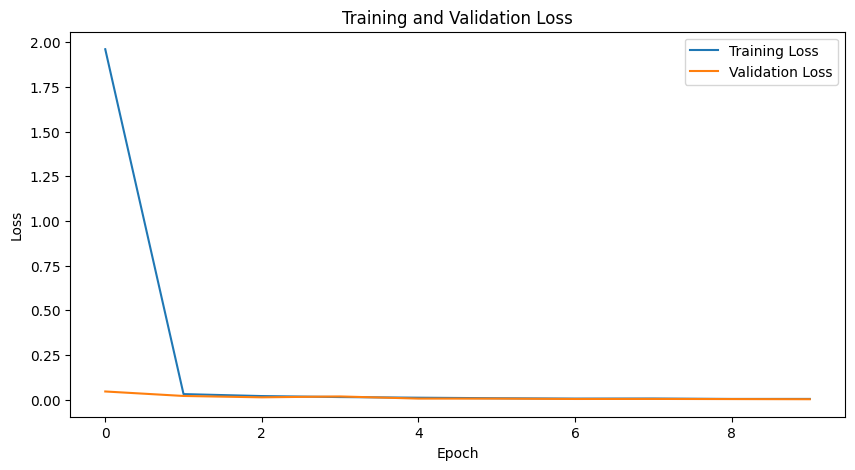

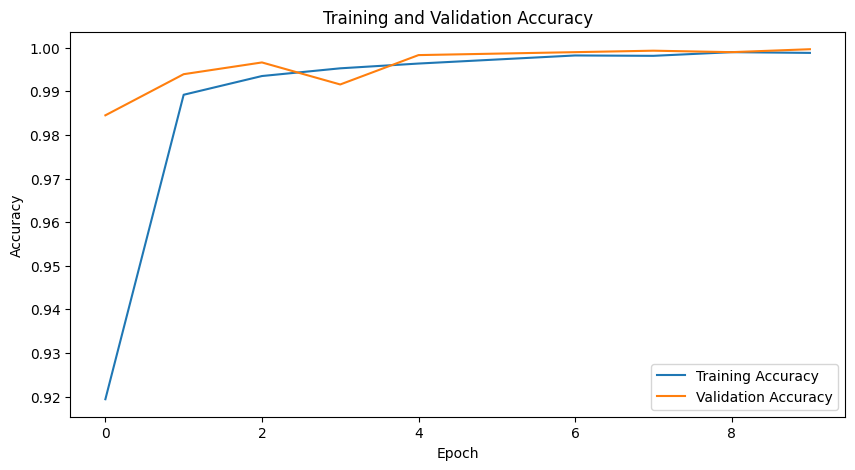

Epoch 1/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.82it/s]


train Loss: 0.9053 Acc: 0.9474


100%|██████████| 47/47 [00:09<00:00,  5.10it/s]


val Loss: 0.0214 Acc: 0.9929
Saving Best Model with Validation Accuracy:  0.9929269114179858
Epoch 2/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.79it/s]


train Loss: 0.0158 Acc: 0.9950


100%|██████████| 47/47 [00:09<00:00,  5.06it/s]


val Loss: 0.0104 Acc: 0.9973
Saving Best Model with Validation Accuracy:  0.9973054900639946
Epoch 3/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.83it/s]


train Loss: 0.0084 Acc: 0.9976


100%|██████████| 47/47 [00:09<00:00,  4.85it/s]


val Loss: 0.0075 Acc: 0.9973
Epoch 4/10
----------


100%|██████████| 186/186 [00:36<00:00,  5.06it/s]


train Loss: 0.0064 Acc: 0.9982


100%|██████████| 47/47 [00:09<00:00,  4.75it/s]


val Loss: 0.0062 Acc: 0.9973
Epoch 5/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.95it/s]


train Loss: 0.0043 Acc: 0.9990


100%|██████████| 47/47 [00:09<00:00,  4.94it/s]


val Loss: 0.0064 Acc: 0.9980
Saving Best Model with Validation Accuracy:  0.997979117547996
Epoch 6/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.90it/s]


train Loss: 0.0040 Acc: 0.9987


100%|██████████| 47/47 [00:08<00:00,  5.29it/s]


val Loss: 0.0035 Acc: 0.9987
Saving Best Model with Validation Accuracy:  0.9986527450319973
Epoch 7/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.78it/s]


train Loss: 0.0024 Acc: 0.9994


100%|██████████| 47/47 [00:09<00:00,  4.90it/s]


val Loss: 0.0041 Acc: 0.9983
Epoch 8/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.86it/s]


train Loss: 0.0022 Acc: 0.9994


100%|██████████| 47/47 [00:09<00:00,  4.87it/s]


val Loss: 0.0028 Acc: 0.9987
Epoch 9/10
----------


100%|██████████| 186/186 [00:36<00:00,  5.04it/s]


train Loss: 0.0019 Acc: 0.9995


100%|██████████| 47/47 [00:09<00:00,  4.95it/s]


val Loss: 0.0022 Acc: 0.9993
Saving Best Model with Validation Accuracy:  0.9993263725159987
Epoch 10/10
----------


100%|██████████| 186/186 [00:37<00:00,  5.00it/s]


train Loss: 0.0013 Acc: 0.9999


100%|██████████| 47/47 [00:09<00:00,  5.19it/s]


val Loss: 0.0023 Acc: 1.0000
Saving Best Model with Validation Accuracy:  1.0
Training complete in 7m 54s
Best Validation Accuracy: 1.0000


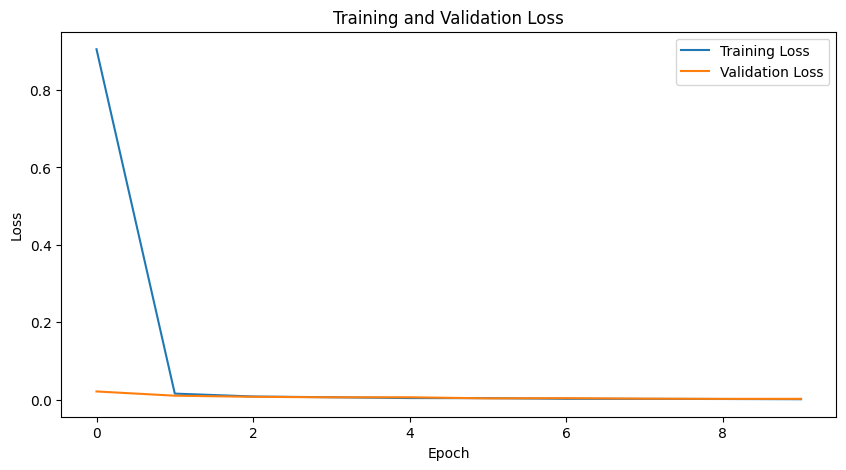

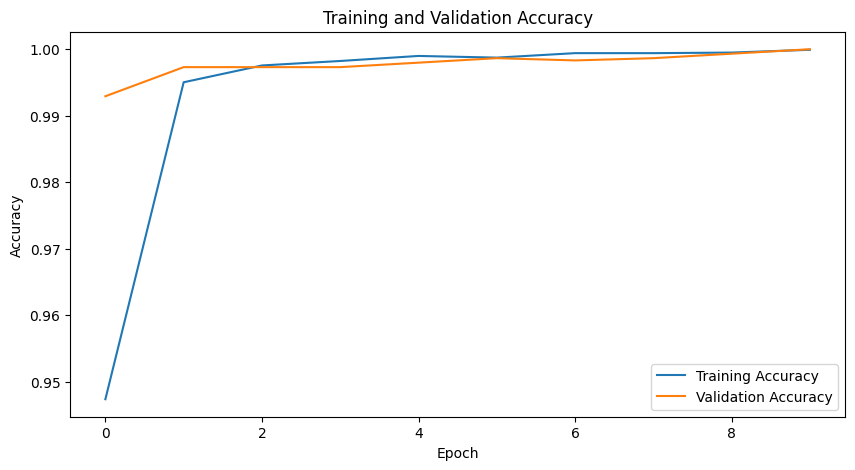

Epoch 1/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.89it/s]


train Loss: 0.7569 Acc: 0.9579


100%|██████████| 47/47 [00:08<00:00,  5.57it/s]


val Loss: 0.0185 Acc: 0.9933
Saving Best Model with Validation Accuracy:  0.9932637251599865
Epoch 2/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.95it/s]


train Loss: 0.0129 Acc: 0.9960


100%|██████████| 47/47 [00:08<00:00,  5.30it/s]


val Loss: 0.0120 Acc: 0.9956
Saving Best Model with Validation Accuracy:  0.9956214213539912
Epoch 3/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.92it/s]


train Loss: 0.0078 Acc: 0.9975


100%|██████████| 47/47 [00:09<00:00,  5.01it/s]


val Loss: 0.0141 Acc: 0.9960
Saving Best Model with Validation Accuracy:  0.9959582350959919
Epoch 4/10
----------


100%|██████████| 186/186 [00:37<00:00,  5.00it/s]


train Loss: 0.0056 Acc: 0.9984


100%|██████████| 47/47 [00:10<00:00,  4.66it/s]


val Loss: 0.0066 Acc: 0.9966
Saving Best Model with Validation Accuracy:  0.9966318625799933
Epoch 5/10
----------


100%|██████████| 186/186 [00:39<00:00,  4.76it/s]


train Loss: 0.0047 Acc: 0.9987


100%|██████████| 47/47 [00:09<00:00,  4.85it/s]


val Loss: 0.0071 Acc: 0.9976
Saving Best Model with Validation Accuracy:  0.9976423038059953
Epoch 6/10
----------


100%|██████████| 186/186 [00:39<00:00,  4.71it/s]


train Loss: 0.0030 Acc: 0.9993


100%|██████████| 47/47 [00:08<00:00,  5.32it/s]


val Loss: 0.0049 Acc: 0.9976
Epoch 7/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.82it/s]


train Loss: 0.0028 Acc: 0.9992


100%|██████████| 47/47 [00:09<00:00,  4.99it/s]


val Loss: 0.0038 Acc: 0.9987
Saving Best Model with Validation Accuracy:  0.9986527450319973
Epoch 8/10
----------


100%|██████████| 186/186 [00:36<00:00,  5.08it/s]


train Loss: 0.0024 Acc: 0.9994


100%|██████████| 47/47 [00:09<00:00,  4.97it/s]


val Loss: 0.0034 Acc: 0.9990
Saving Best Model with Validation Accuracy:  0.998989558773998
Epoch 9/10
----------


100%|██████████| 186/186 [00:37<00:00,  5.00it/s]


train Loss: 0.0019 Acc: 0.9994


100%|██████████| 47/47 [00:09<00:00,  4.83it/s]


val Loss: 0.0037 Acc: 0.9987
Epoch 10/10
----------


100%|██████████| 186/186 [00:36<00:00,  5.10it/s]


train Loss: 0.0013 Acc: 0.9997


100%|██████████| 47/47 [00:09<00:00,  4.99it/s]


val Loss: 0.0038 Acc: 0.9987
Training complete in 7m 52s
Best Validation Accuracy: 0.9990


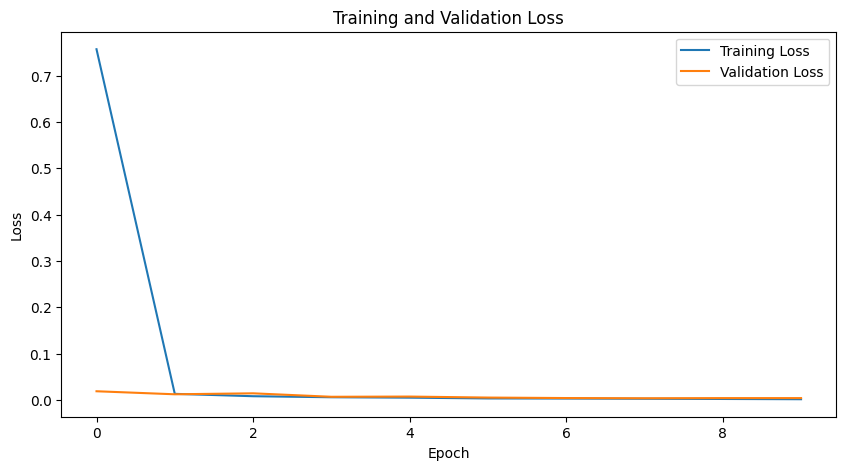

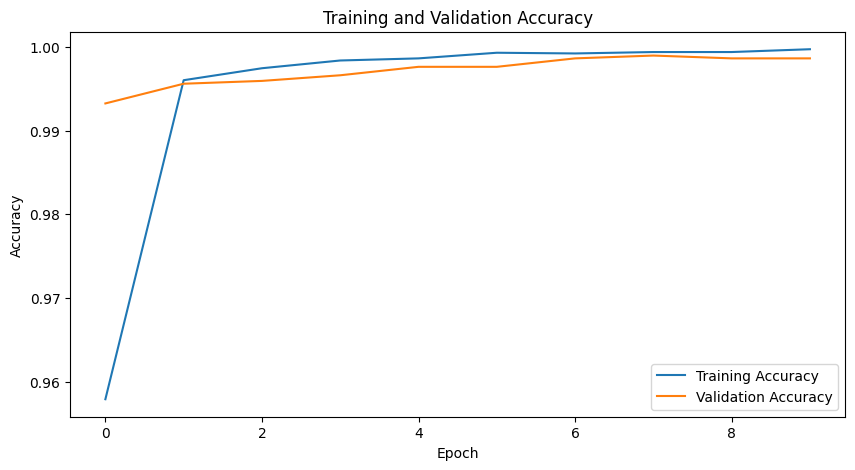

In [21]:
# Ensure weights are initialized if not using pre-trained
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

initialize_weights(model)


# Define arguments
class Args:
    def __init__(self, seed):
        self.batch_size = 64 #16
        self.epochs = 10
        self.lr = 0.001 #0.00001
        self.momentum = 0.9
        self.seed = seed
        self.regularizer_rate = 0.0
        #self.dropout_rate = 0.7

seeds = [1, 11, 111]

for seed in seeds:
    args = Args(seed)

    # Set random seed for reproducibility
    torch.manual_seed(args.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model, optimizer, and loss function
    model = AlexNet().to(device)
    initialize_weights(model)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=0.0005)
    criterion = nn.BCEWithLogitsLoss()

    model = train_model(model, dataloaders, criterion, optimizer, num_epochs=args.epochs, resume_training=False)
    pid = datetime.now().strftime('%Y%m%d%H%M%S')
    torch.save(model.state_dict(), os.path.join(dir_path, model_path, f"alexnet_mnist_olp_cl0_cl2_{seed}" + "train.pt"))



### Center Patch

In [22]:
#Train
two_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_2'
zero_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_0_half' #first half
two_cp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_center/train/class_2'
zero_cp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_center/train/class_0_half' #second half

#Test
test_two_cp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_center/test/class_2'



# Create datasets for training and testing
dataset_two_org = MnistDataset(path=two_org_path, is_two=1, group_labels=[0] * len(os.listdir(two_org_path)))
dataset_zero_org = MnistDataset(path=zero_org_path, is_two=0, group_labels=[2] * len(os.listdir(zero_org_path)))
dataset_two_cp = MnistDataset(path=two_cp_path, is_two=1, group_labels=[1] * len(os.listdir(two_cp_path)))
dataset_zero_cp = MnistDataset(path=zero_cp_path, is_two=0, group_labels=[3] * len(os.listdir(zero_cp_path)))
dataset_test_two_cp = MnistDataset(path=test_two_cp_path, is_two=1, group_labels=[1] * len(os.listdir(test_two_cp_path)))

# Concatenate the training datasets
complete_dataset = ConcatDataset((dataset_zero_org, dataset_zero_cp, dataset_two_org))

# Set the random seed for reproducibility
seed = 1
torch.manual_seed(seed)

# Split the dataset into training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(complete_dataset))
val_size = len(complete_dataset) - train_size
train_dataset, val_dataset = random_split(complete_dataset, [train_size, val_size])

# Use the test dataset as is
test_dataset = dataset_test_two_cp

batch_size = 64

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Validate input data
#if not validate_inputs(train_loader):
#    print("Input data contains invalid values.")

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_val:", dataset_sizes['val'])
print("num_test:", dataset_sizes['test'])



num_train: 11873
num_val: 2969
num_test: 1032


Epoch 1/10
----------


100%|██████████| 186/186 [01:56<00:00,  1.59it/s]


train Loss: 1.9653 Acc: 0.9153


100%|██████████| 47/47 [00:10<00:00,  4.54it/s]


val Loss: 0.0308 Acc: 0.9889
Saving Best Model with Validation Accuracy:  0.9888851465139777
Epoch 2/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.80it/s]


train Loss: 0.0269 Acc: 0.9910


100%|██████████| 47/47 [00:10<00:00,  4.66it/s]


val Loss: 0.0157 Acc: 0.9966
Saving Best Model with Validation Accuracy:  0.9966318625799933
Epoch 3/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.82it/s]


train Loss: 0.0167 Acc: 0.9944


100%|██████████| 47/47 [00:09<00:00,  5.00it/s]


val Loss: 0.0086 Acc: 0.9980
Saving Best Model with Validation Accuracy:  0.997979117547996
Epoch 4/10
----------


100%|██████████| 186/186 [00:39<00:00,  4.76it/s]


train Loss: 0.0119 Acc: 0.9965


100%|██████████| 47/47 [00:08<00:00,  5.46it/s]


val Loss: 0.0154 Acc: 0.9936
Epoch 5/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.89it/s]


train Loss: 0.0073 Acc: 0.9981


100%|██████████| 47/47 [00:08<00:00,  5.38it/s]


val Loss: 0.0044 Acc: 0.9987
Saving Best Model with Validation Accuracy:  0.9986527450319973
Epoch 6/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.91it/s]


train Loss: 0.0081 Acc: 0.9972


100%|██████████| 47/47 [00:09<00:00,  5.19it/s]


val Loss: 0.0052 Acc: 0.9993
Saving Best Model with Validation Accuracy:  0.9993263725159987
Epoch 7/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.89it/s]


train Loss: 0.0063 Acc: 0.9977


100%|██████████| 47/47 [00:09<00:00,  4.82it/s]


val Loss: 0.0038 Acc: 0.9990
Epoch 8/10
----------


100%|██████████| 186/186 [00:36<00:00,  5.04it/s]


train Loss: 0.0047 Acc: 0.9986


100%|██████████| 47/47 [00:09<00:00,  4.86it/s]


val Loss: 0.0025 Acc: 0.9993
Epoch 9/10
----------


100%|██████████| 186/186 [00:36<00:00,  5.06it/s]


train Loss: 0.0032 Acc: 0.9990


100%|██████████| 47/47 [00:09<00:00,  4.89it/s]


val Loss: 0.0021 Acc: 0.9993
Epoch 10/10
----------


100%|██████████| 186/186 [00:36<00:00,  5.10it/s]


train Loss: 0.0029 Acc: 0.9991


100%|██████████| 47/47 [00:09<00:00,  4.83it/s]


val Loss: 0.0019 Acc: 0.9993
Training complete in 9m 13s
Best Validation Accuracy: 0.9993


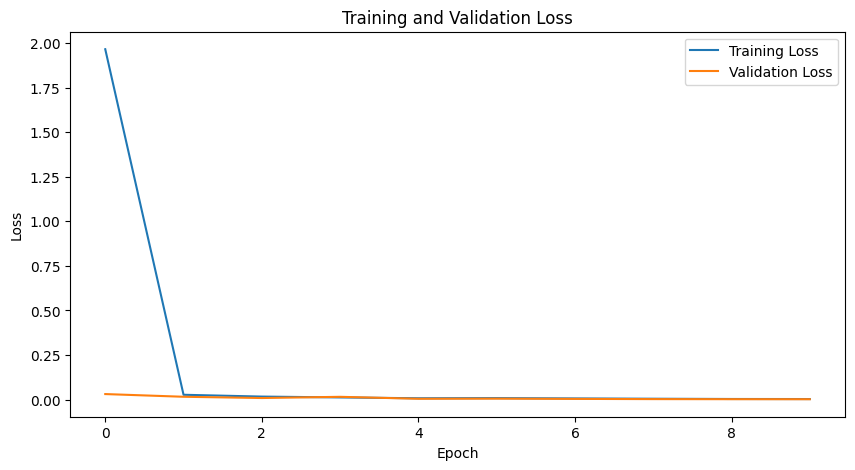

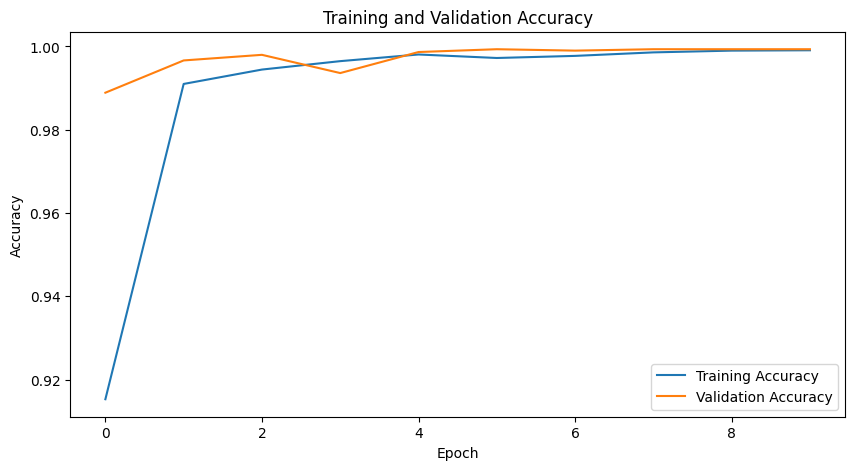

Epoch 1/10
----------


100%|██████████| 186/186 [00:37<00:00,  5.01it/s]


train Loss: 0.9064 Acc: 0.9405


100%|██████████| 47/47 [00:09<00:00,  4.97it/s]


val Loss: 0.0203 Acc: 0.9933
Saving Best Model with Validation Accuracy:  0.9932637251599865
Epoch 2/10
----------


100%|██████████| 186/186 [00:36<00:00,  5.09it/s]


train Loss: 0.0152 Acc: 0.9950


100%|██████████| 47/47 [00:09<00:00,  5.10it/s]


val Loss: 0.0097 Acc: 0.9973
Saving Best Model with Validation Accuracy:  0.9973054900639946
Epoch 3/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.96it/s]


train Loss: 0.0084 Acc: 0.9972


100%|██████████| 47/47 [00:09<00:00,  4.98it/s]


val Loss: 0.0068 Acc: 0.9976
Saving Best Model with Validation Accuracy:  0.9976423038059953
Epoch 4/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.77it/s]


train Loss: 0.0062 Acc: 0.9981


100%|██████████| 47/47 [00:08<00:00,  5.58it/s]


val Loss: 0.0051 Acc: 0.9987
Saving Best Model with Validation Accuracy:  0.9986527450319973
Epoch 5/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.91it/s]


train Loss: 0.0042 Acc: 0.9988


100%|██████████| 47/47 [00:08<00:00,  5.83it/s]


val Loss: 0.0047 Acc: 0.9987
Epoch 6/10
----------


100%|██████████| 186/186 [00:37<00:00,  5.00it/s]


train Loss: 0.0034 Acc: 0.9991


100%|██████████| 47/47 [00:08<00:00,  5.44it/s]


val Loss: 0.0031 Acc: 0.9990
Saving Best Model with Validation Accuracy:  0.998989558773998
Epoch 7/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.95it/s]


train Loss: 0.0024 Acc: 0.9995


100%|██████████| 47/47 [00:09<00:00,  4.78it/s]


val Loss: 0.0035 Acc: 0.9987
Epoch 8/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.99it/s]


train Loss: 0.0022 Acc: 0.9997


100%|██████████| 47/47 [00:09<00:00,  4.93it/s]


val Loss: 0.0028 Acc: 0.9990
Epoch 9/10
----------


100%|██████████| 186/186 [00:37<00:00,  5.01it/s]


train Loss: 0.0017 Acc: 0.9998


100%|██████████| 47/47 [00:09<00:00,  5.19it/s]


val Loss: 0.0022 Acc: 0.9990
Epoch 10/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.92it/s]


train Loss: 0.0014 Acc: 0.9999


100%|██████████| 47/47 [00:08<00:00,  5.68it/s]


val Loss: 0.0022 Acc: 0.9993
Saving Best Model with Validation Accuracy:  0.9993263725159987
Training complete in 7m 45s
Best Validation Accuracy: 0.9993


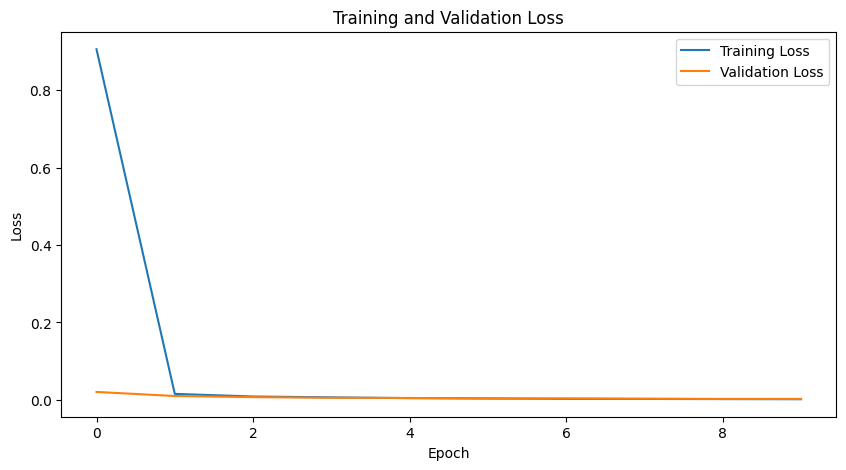

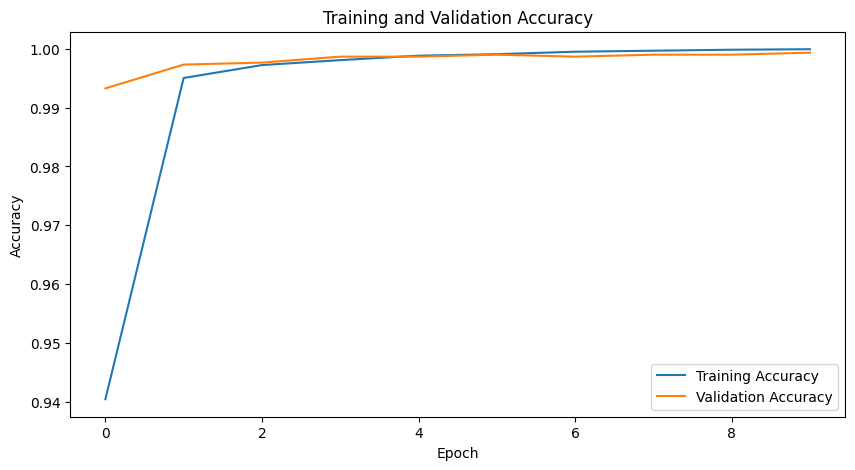

Epoch 1/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.92it/s]


train Loss: 0.7825 Acc: 0.9535


100%|██████████| 47/47 [00:09<00:00,  5.22it/s]


val Loss: 0.0179 Acc: 0.9929
Saving Best Model with Validation Accuracy:  0.9929269114179858
Epoch 2/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.91it/s]


train Loss: 0.0139 Acc: 0.9948


100%|██████████| 47/47 [00:09<00:00,  4.85it/s]


val Loss: 0.0099 Acc: 0.9956
Saving Best Model with Validation Accuracy:  0.9956214213539912
Epoch 3/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.95it/s]


train Loss: 0.0084 Acc: 0.9972


100%|██████████| 47/47 [00:09<00:00,  4.80it/s]


val Loss: 0.0067 Acc: 0.9980
Saving Best Model with Validation Accuracy:  0.997979117547996
Epoch 4/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.97it/s]


train Loss: 0.0062 Acc: 0.9980


100%|██████████| 47/47 [00:08<00:00,  5.24it/s]


val Loss: 0.0051 Acc: 0.9980
Epoch 5/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.80it/s]


train Loss: 0.0044 Acc: 0.9987


100%|██████████| 47/47 [00:09<00:00,  5.21it/s]


val Loss: 0.0044 Acc: 0.9987
Saving Best Model with Validation Accuracy:  0.9986527450319973
Epoch 6/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.90it/s]


train Loss: 0.0030 Acc: 0.9992


100%|██████████| 47/47 [00:09<00:00,  5.15it/s]


val Loss: 0.0046 Acc: 0.9983
Epoch 7/10
----------


100%|██████████| 186/186 [00:36<00:00,  5.15it/s]


train Loss: 0.0032 Acc: 0.9992


100%|██████████| 47/47 [00:09<00:00,  4.90it/s]


val Loss: 0.0031 Acc: 0.9990
Saving Best Model with Validation Accuracy:  0.998989558773998
Epoch 8/10
----------


100%|██████████| 186/186 [00:36<00:00,  5.16it/s]


train Loss: 0.0021 Acc: 0.9995


100%|██████████| 47/47 [00:09<00:00,  5.03it/s]


val Loss: 0.0028 Acc: 0.9993
Saving Best Model with Validation Accuracy:  0.9993263725159987
Epoch 9/10
----------


100%|██████████| 186/186 [00:36<00:00,  5.04it/s]


train Loss: 0.0018 Acc: 0.9995


100%|██████████| 47/47 [00:09<00:00,  4.85it/s]


val Loss: 0.0036 Acc: 0.9987
Epoch 10/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.93it/s]


train Loss: 0.0013 Acc: 0.9997


100%|██████████| 47/47 [00:08<00:00,  5.25it/s]


val Loss: 0.0030 Acc: 0.9987
Training complete in 7m 48s
Best Validation Accuracy: 0.9993


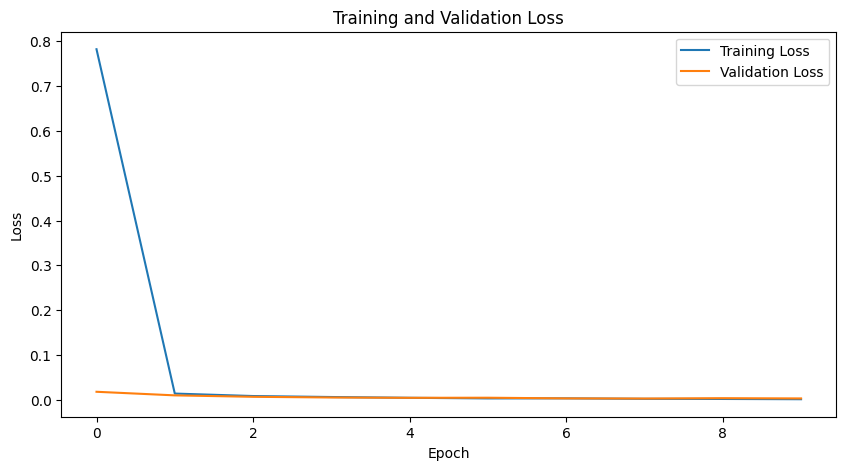

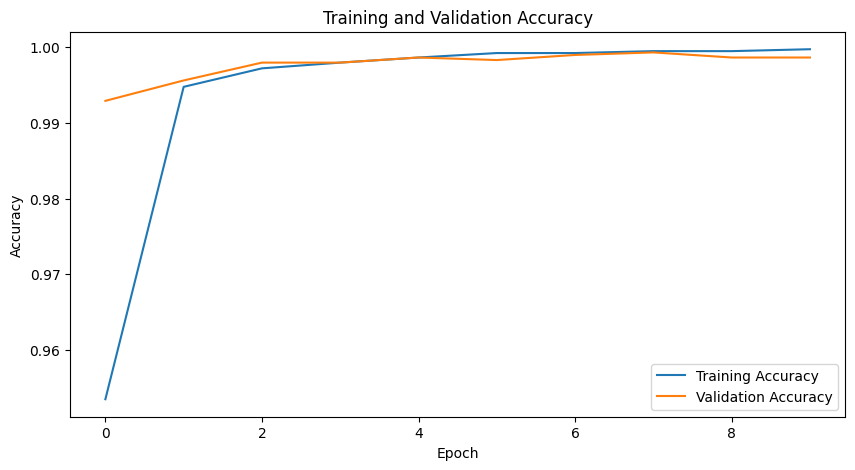

In [23]:
# Ensure weights are initialized if not using pre-trained
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

initialize_weights(model)


# Define arguments
class Args:
    def __init__(self, seed):
        self.batch_size = 64 #16
        self.epochs = 10
        self.lr = 0.001 #0.00001
        self.momentum = 0.9
        self.seed = seed
        self.regularizer_rate = 0.0
        #self.dropout_rate = 0.7

seeds = [1, 11, 111]

for seed in seeds:
    args = Args(seed)

    # Set random seed for reproducibility
    torch.manual_seed(args.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model, optimizer, and loss function
    model = AlexNet().to(device)
    initialize_weights(model)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=0.0005)
    criterion = nn.BCEWithLogitsLoss()

    model = train_model(model, dataloaders, criterion, optimizer, num_epochs=args.epochs, resume_training=False)
    pid = datetime.now().strftime('%Y%m%d%H%M%S')
    torch.save(model.state_dict(), os.path.join(dir_path, model_path, f"alexnet_mnist_cp_cl0_cl2_{seed}" + "train.pt"))



### Left vs. Right Patch

In [24]:
import shutil

# Define source and target directories
source_dir = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_right/train/class_2'
target_dir = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_right/train/class_2_half_first'

# Ensure target directory exists
os.makedirs(target_dir, exist_ok=True)

# List all files in the source directory
all_files = os.listdir(source_dir)

# Sort files to ensure consistent ordering
all_files.sort()

# Determine the number of files to copy (first half of the total number of files)
num_files_to_copy = len(all_files) // 2

# Copy the first half of the files to the target directory
for file_name in all_files[:num_files_to_copy]:
    source_file = os.path.join(source_dir, file_name)
    target_file = os.path.join(target_dir, file_name)
    shutil.copy2(source_file, target_file)

print(f"Copied {num_files_to_copy} files from {source_dir} to {target_dir}")

Copied 2979 files from /content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_right/train/class_2 to /content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_right/train/class_2_half_first


In [25]:
source_dir = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/train/class_2'
target_dir = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/train/class_2_half_second'

# Ensure target directory exists
os.makedirs(target_dir, exist_ok=True)

# List all files in the source directory
all_files = os.listdir(source_dir)

# Sort files to ensure consistent ordering
all_files.sort()

# Determine the number of files to copy (second half of the total number of files)
num_files_to_copy = len(all_files) // 2

# Copy the second half of the files to the target directory
for file_name in all_files[num_files_to_copy:]:
    source_file = os.path.join(source_dir, file_name)
    target_file = os.path.join(target_dir, file_name)
    shutil.copy2(source_file, target_file)

print(f"Copied {len(all_files[num_files_to_copy:])} files from {source_dir} to {target_dir}")

Copied 2979 files from /content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/train/class_2 to /content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/train/class_2_half_second


In [26]:
#Train
two_rp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_right/train/class_2_half_first'
zero_rp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_right/train/class_0_half'
two_lp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/train/class_2_half_second'
zero_lp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/train/class_0'

#Test
test_two_lp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/test/class_2'



# Create datasets for training and testing
dataset_two_rp = MnistDataset(path=two_rp_path, is_two=1, group_labels=[0] * len(os.listdir(two_rp_path)))
#dataset_zero_rp = MnistDataset(path=zero_org_path, is_two=0, group_labels=[2] * len(os.listdir(zero_org_path)))
dataset_two_lp = MnistDataset(path=two_lp_path, is_two=1, group_labels=[1] * len(os.listdir(two_lp_path)))
dataset_zero_lp = MnistDataset(path=zero_lp_path, is_two=0, group_labels=[3] * len(os.listdir(zero_lp_path)))
dataset_test_two_lp = MnistDataset(path=test_two_lp_path, is_two=1, group_labels=[1] * len(os.listdir(test_two_lp_path)))

# Concatenate the training datasets
complete_dataset = ConcatDataset((dataset_two_rp, dataset_two_lp, dataset_zero_lp))

# Set the random seed for reproducibility
seed = 1
torch.manual_seed(seed)

# Split the dataset into training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(complete_dataset))
val_size = len(complete_dataset) - train_size
train_dataset, val_dataset = random_split(complete_dataset, [train_size, val_size])

# Use the test dataset as is
test_dataset = dataset_test_two_cp

batch_size = 64

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Validate input data
#if not validate_inputs(train_loader):
#    print("Input data contains invalid values.")

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_val:", dataset_sizes['val'])
print("num_test:", dataset_sizes['test'])



num_train: 9504
num_val: 2377
num_test: 1032


Epoch 1/10
----------


100%|██████████| 149/149 [03:43<00:00,  1.50s/it]


train Loss: 2.0370 Acc: 0.9278


100%|██████████| 38/38 [00:07<00:00,  4.76it/s]


val Loss: 0.0293 Acc: 0.9878
Saving Best Model with Validation Accuracy:  0.9877997475809844
Epoch 2/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.80it/s]


train Loss: 0.0207 Acc: 0.9931


100%|██████████| 38/38 [00:07<00:00,  4.78it/s]


val Loss: 0.0204 Acc: 0.9928
Saving Best Model with Validation Accuracy:  0.9928481278923013
Epoch 3/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.89it/s]


train Loss: 0.0139 Acc: 0.9955


100%|██████████| 38/38 [00:07<00:00,  5.42it/s]


val Loss: 0.0151 Acc: 0.9937
Saving Best Model with Validation Accuracy:  0.993689524610854
Epoch 4/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.73it/s]


train Loss: 0.0115 Acc: 0.9960


100%|██████████| 38/38 [00:07<00:00,  4.84it/s]


val Loss: 0.0128 Acc: 0.9962
Saving Best Model with Validation Accuracy:  0.9962137147665124
Epoch 5/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.70it/s]


train Loss: 0.0085 Acc: 0.9971


100%|██████████| 38/38 [00:08<00:00,  4.58it/s]


val Loss: 0.0203 Acc: 0.9912
Epoch 6/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.82it/s]


train Loss: 0.0084 Acc: 0.9968


100%|██████████| 38/38 [00:07<00:00,  5.39it/s]


val Loss: 0.0203 Acc: 0.9916
Epoch 7/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.90it/s]


train Loss: 0.0060 Acc: 0.9984


100%|██████████| 38/38 [00:07<00:00,  5.09it/s]


val Loss: 0.0090 Acc: 0.9966
Saving Best Model with Validation Accuracy:  0.9966344131257888
Epoch 8/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.86it/s]


train Loss: 0.0039 Acc: 0.9987


100%|██████████| 38/38 [00:08<00:00,  4.66it/s]


val Loss: 0.0156 Acc: 0.9941
Epoch 9/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.88it/s]


train Loss: 0.0041 Acc: 0.9985


100%|██████████| 38/38 [00:07<00:00,  5.36it/s]


val Loss: 0.0071 Acc: 0.9979
Saving Best Model with Validation Accuracy:  0.9978965082036181
Epoch 10/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.84it/s]


train Loss: 0.0039 Acc: 0.9987


100%|██████████| 38/38 [00:08<00:00,  4.64it/s]


val Loss: 0.0134 Acc: 0.9950
Training complete in 9m 39s
Best Validation Accuracy: 0.9979


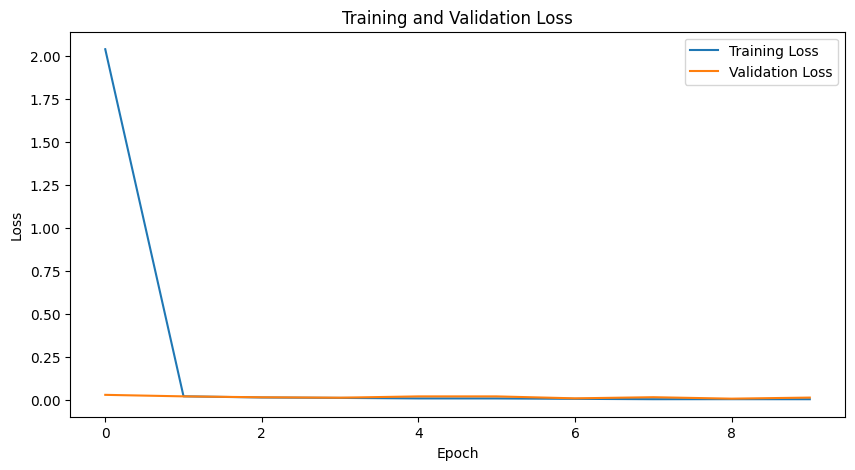

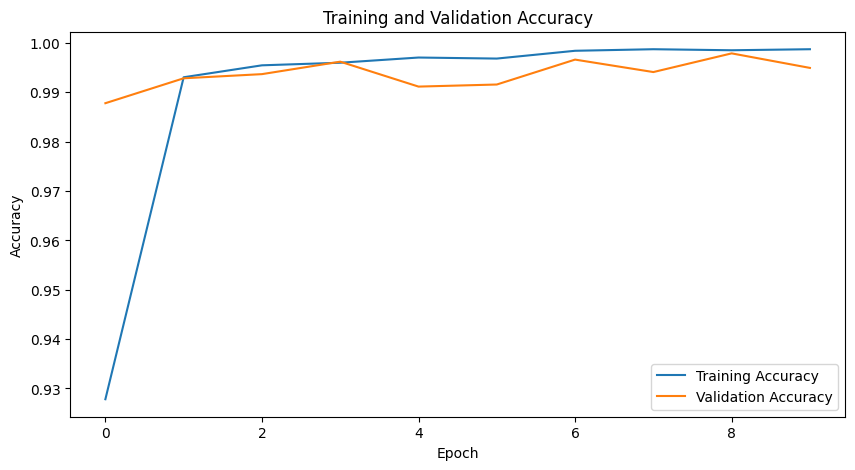

Epoch 1/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.90it/s]


train Loss: 0.9967 Acc: 0.9343


100%|██████████| 38/38 [00:07<00:00,  5.14it/s]


val Loss: 0.0307 Acc: 0.9878
Saving Best Model with Validation Accuracy:  0.9877997475809844
Epoch 2/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.87it/s]


train Loss: 0.0189 Acc: 0.9935


100%|██████████| 38/38 [00:06<00:00,  5.54it/s]


val Loss: 0.0218 Acc: 0.9920
Saving Best Model with Validation Accuracy:  0.9920067311737485
Epoch 3/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.86it/s]


train Loss: 0.0130 Acc: 0.9958


100%|██████████| 38/38 [00:08<00:00,  4.68it/s]


val Loss: 0.0164 Acc: 0.9937
Saving Best Model with Validation Accuracy:  0.993689524610854
Epoch 4/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.95it/s]


train Loss: 0.0094 Acc: 0.9968


100%|██████████| 38/38 [00:06<00:00,  5.45it/s]


val Loss: 0.0151 Acc: 0.9950
Saving Best Model with Validation Accuracy:  0.9949516196886833
Epoch 5/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.89it/s]


train Loss: 0.0078 Acc: 0.9973


100%|██████████| 38/38 [00:08<00:00,  4.69it/s]


val Loss: 0.0121 Acc: 0.9950
Epoch 6/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.89it/s]


train Loss: 0.0056 Acc: 0.9981


100%|██████████| 38/38 [00:07<00:00,  4.88it/s]


val Loss: 0.0104 Acc: 0.9958
Saving Best Model with Validation Accuracy:  0.995793016407236
Epoch 7/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.70it/s]


train Loss: 0.0045 Acc: 0.9988


100%|██████████| 38/38 [00:07<00:00,  5.29it/s]


val Loss: 0.0149 Acc: 0.9954
Epoch 8/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.93it/s]


train Loss: 0.0042 Acc: 0.9984


100%|██████████| 38/38 [00:07<00:00,  4.76it/s]


val Loss: 0.0104 Acc: 0.9966
Saving Best Model with Validation Accuracy:  0.9966344131257888
Epoch 9/10
----------


100%|██████████| 149/149 [00:29<00:00,  4.98it/s]


train Loss: 0.0032 Acc: 0.9994


100%|██████████| 38/38 [00:07<00:00,  5.01it/s]


val Loss: 0.0096 Acc: 0.9971
Saving Best Model with Validation Accuracy:  0.9970551114850652
Epoch 10/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.68it/s]


train Loss: 0.0029 Acc: 0.9994


100%|██████████| 38/38 [00:07<00:00,  5.37it/s]


val Loss: 0.0085 Acc: 0.9983
Saving Best Model with Validation Accuracy:  0.9983172065628945
Training complete in 6m 22s
Best Validation Accuracy: 0.9983


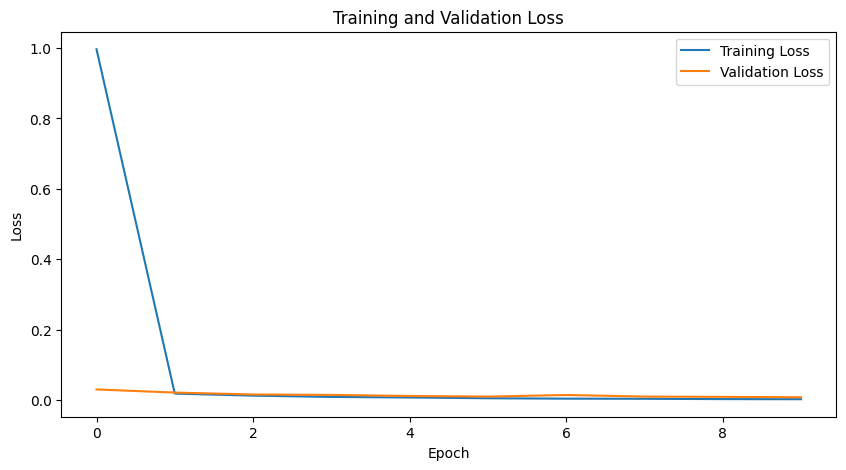

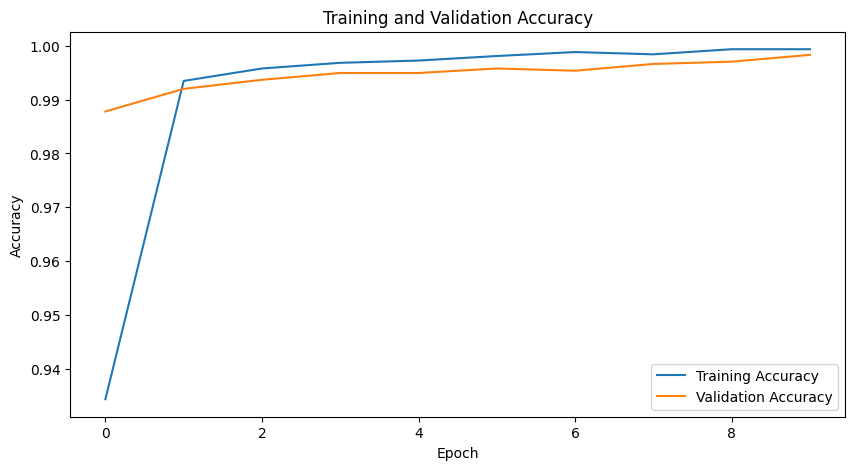

Epoch 1/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.88it/s]


train Loss: 1.3972 Acc: 0.9069


100%|██████████| 38/38 [00:07<00:00,  4.75it/s]


val Loss: 0.0171 Acc: 0.9945
Saving Best Model with Validation Accuracy:  0.9945309213294069
Epoch 2/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.87it/s]


train Loss: 0.0111 Acc: 0.9967


100%|██████████| 38/38 [00:07<00:00,  5.41it/s]


val Loss: 0.0136 Acc: 0.9954
Saving Best Model with Validation Accuracy:  0.9953723180479597
Epoch 3/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.77it/s]


train Loss: 0.0085 Acc: 0.9971


100%|██████████| 38/38 [00:07<00:00,  4.83it/s]


val Loss: 0.0232 Acc: 0.9920
Epoch 4/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.79it/s]


train Loss: 0.0076 Acc: 0.9976


100%|██████████| 38/38 [00:08<00:00,  4.63it/s]


val Loss: 0.0160 Acc: 0.9933
Epoch 5/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.82it/s]


train Loss: 0.0042 Acc: 0.9989


100%|██████████| 38/38 [00:07<00:00,  5.32it/s]


val Loss: 0.0073 Acc: 0.9979
Saving Best Model with Validation Accuracy:  0.9978965082036181
Epoch 6/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.95it/s]


train Loss: 0.0029 Acc: 0.9994


100%|██████████| 38/38 [00:08<00:00,  4.73it/s]


val Loss: 0.0065 Acc: 0.9971
Epoch 7/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.95it/s]


train Loss: 0.0030 Acc: 0.9993


100%|██████████| 38/38 [00:06<00:00,  5.61it/s]


val Loss: 0.0090 Acc: 0.9966
Epoch 8/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.68it/s]


train Loss: 0.0023 Acc: 0.9997


100%|██████████| 38/38 [00:07<00:00,  4.77it/s]


val Loss: 0.0102 Acc: 0.9966
Epoch 9/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.74it/s]


train Loss: 0.0017 Acc: 0.9996


100%|██████████| 38/38 [00:08<00:00,  4.65it/s]


val Loss: 0.0121 Acc: 0.9958
Epoch 10/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.86it/s]


train Loss: 0.0018 Acc: 0.9998


100%|██████████| 38/38 [00:07<00:00,  5.29it/s]


val Loss: 0.0062 Acc: 0.9975
Training complete in 6m 25s
Best Validation Accuracy: 0.9979


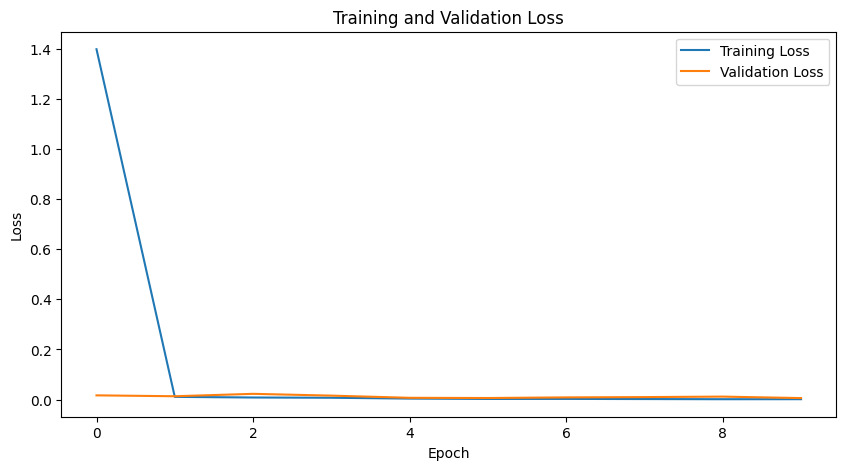

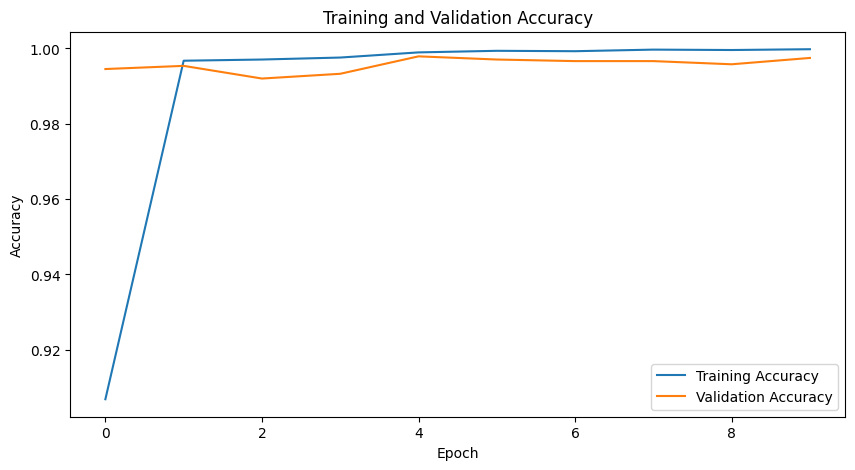

In [27]:
# Ensure weights are initialized if not using pre-trained
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

initialize_weights(model)


# Define arguments
class Args:
    def __init__(self, seed):
        self.batch_size = 64 #16
        self.epochs = 10
        self.lr = 0.001 #0.00001
        self.momentum = 0.9
        self.seed = seed
        self.regularizer_rate = 0.0
        #self.dropout_rate = 0.7

seeds = [1, 11, 111]

for seed in seeds:
    args = Args(seed)

    # Set random seed for reproducibility
    torch.manual_seed(args.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model, optimizer, and loss function
    model = AlexNet().to(device)
    initialize_weights(model)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=0.0005)
    criterion = nn.BCEWithLogitsLoss()

    model = train_model(model, dataloaders, criterion, optimizer, num_epochs=args.epochs, resume_training=False)
    pid = datetime.now().strftime('%Y%m%d%H%M%S')
    torch.save(model.state_dict(), os.path.join(dir_path, model_path, f"alexnet_mnist_cp_cl0_cl2_{seed}" + "train.pt"))



## Activation Extraction

### Original vs. Colored Background

#### Correlation

Computing activations and saving to activations.npy


<ipython-input-11-61d79bf9f5e8>:189: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


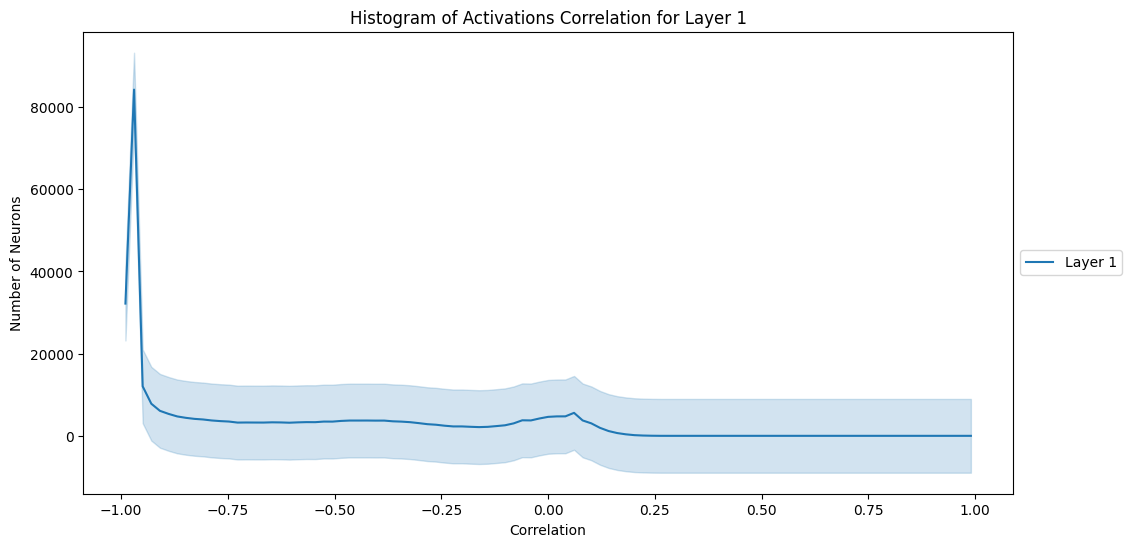

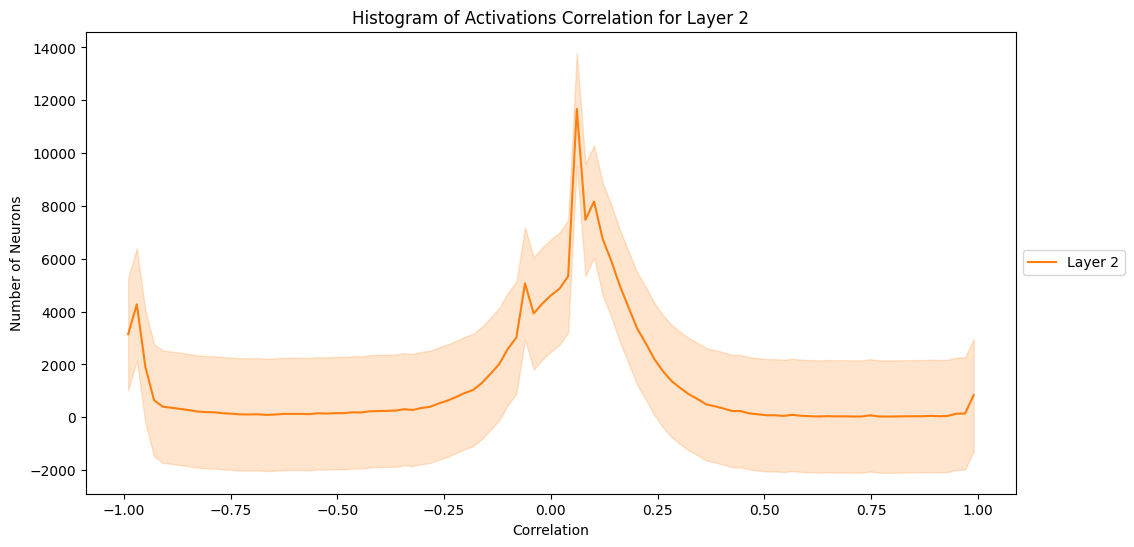

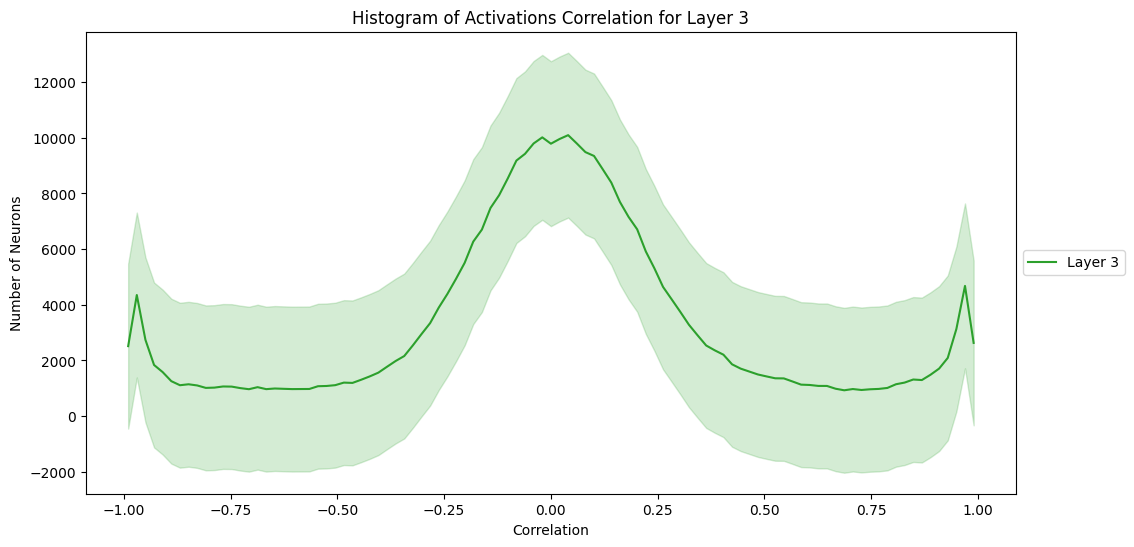

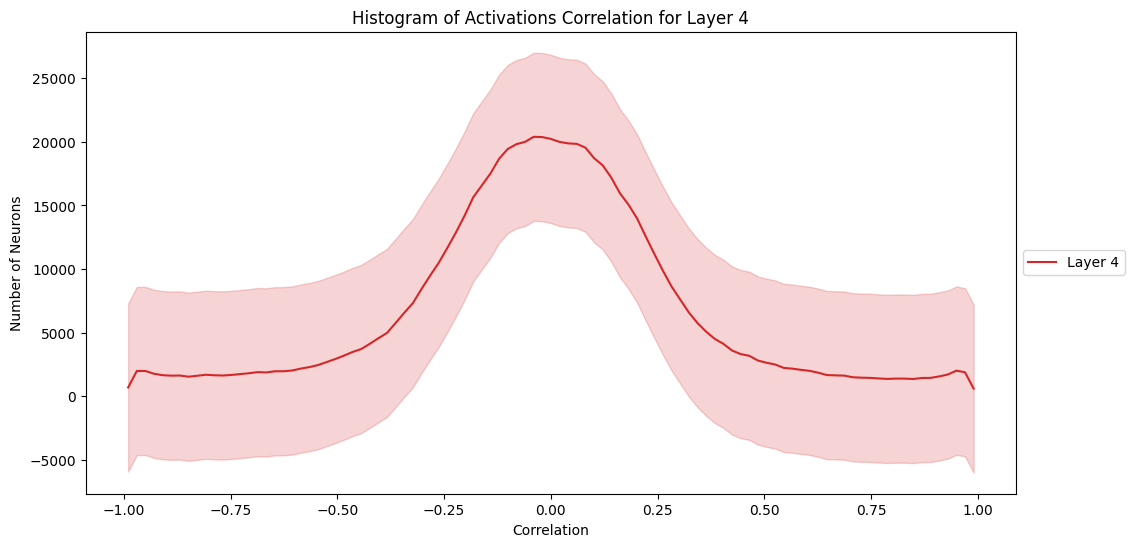

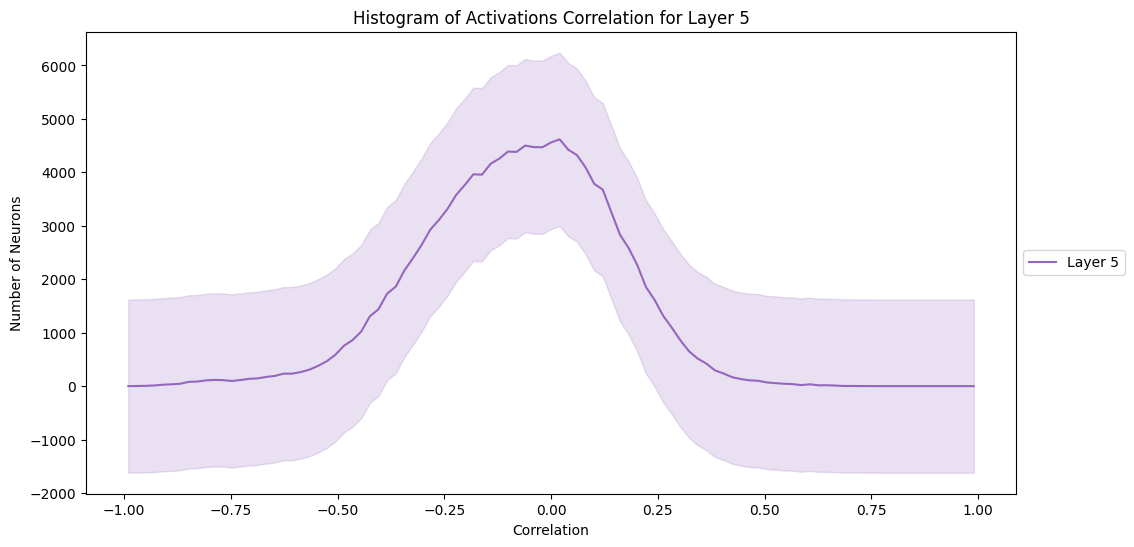

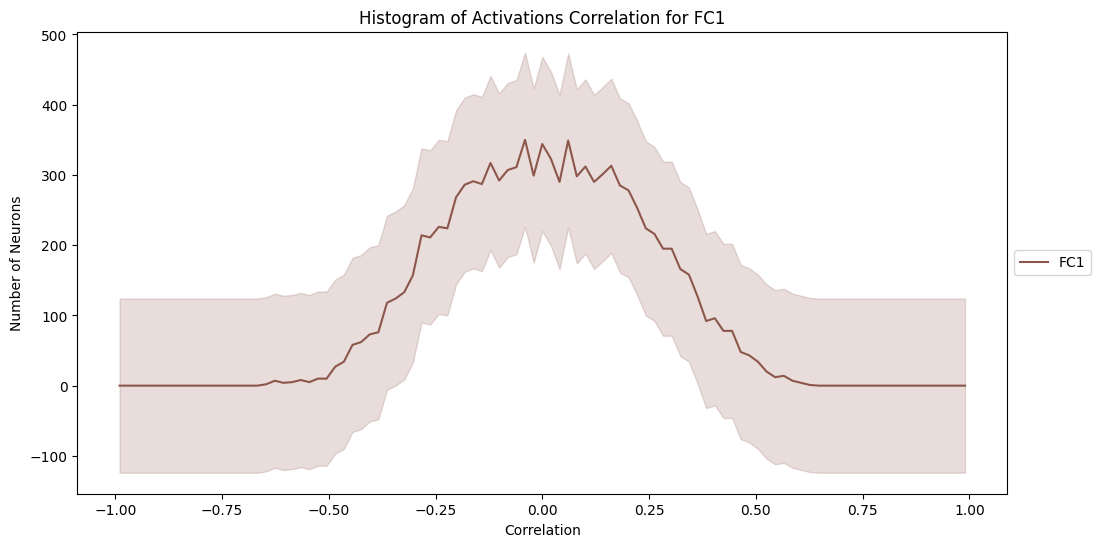

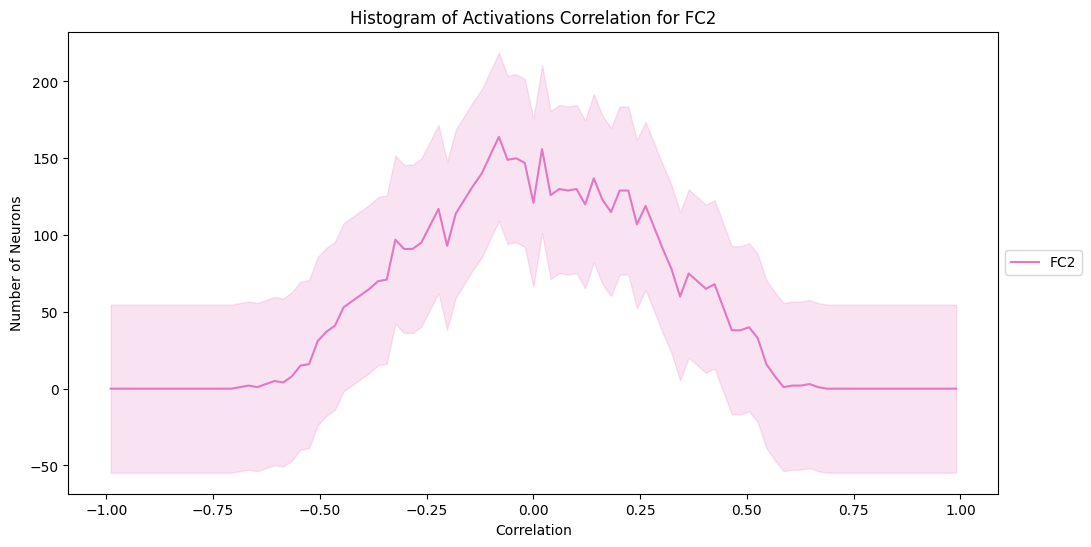

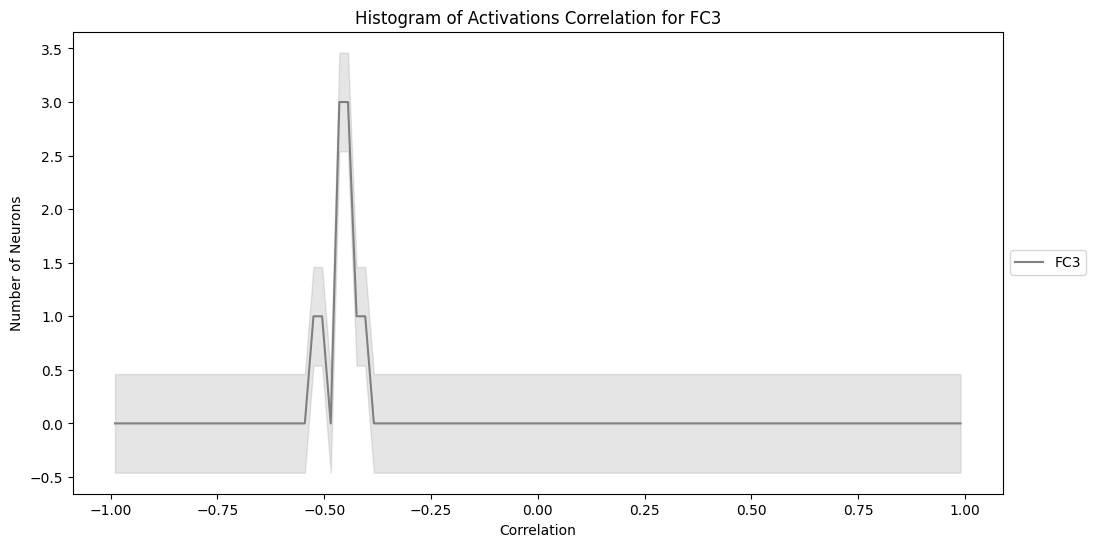

<ipython-input-11-61d79bf9f5e8>:227: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


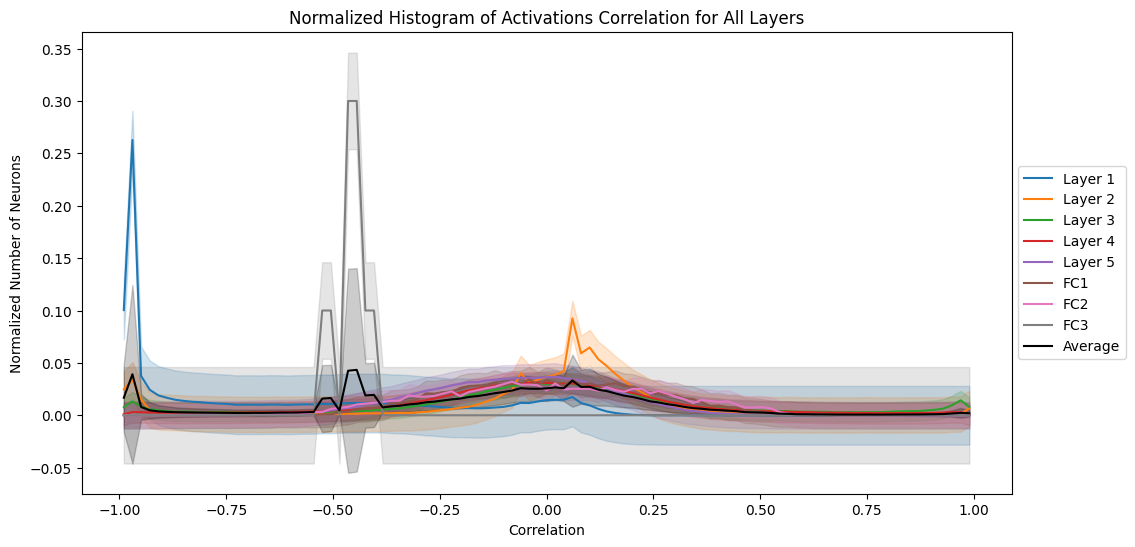

In [11]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import gc
from scipy.stats import pearsonr
from torch.utils.data import DataLoader, Dataset

def load_model(model_path):
    model = AlexNet()
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize((64, 64)),  # Match the resize shape in MnistDataset
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Match the normalization values in MnistDataset
])


class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image


def preprocess_and_extract_activations(model, dataloader, layer):
    activations = []
    with torch.no_grad():
        for image_tensor in dataloader:
            image_tensor = image_tensor.to(device)

            # Extract activations according to the custom model's structure
            if layer == 0:  # Layer 1
                tensor = model.layer1(image_tensor)
            elif layer == 1:  # Layer 2
                tensor = model.layer2(model.layer1(image_tensor))
            elif layer == 2:  # Layer 3
                tensor = model.layer3(model.layer2(model.layer1(image_tensor)))
            elif layer == 3:  # Layer 4
                tensor = model.layer4(model.layer3(model.layer2(model.layer1(image_tensor))))
            elif layer == 4:  # Layer 5
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
            elif layer == 5:  # FC1
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 7 * 7)
                tensor = model.fc1(tensor)
            elif layer == 6:  # FC2
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 7 * 7)
                tensor = model.fc2(model.fc1(tensor))
            elif layer == 7:  # FC3
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 7 * 7)
                tensor = model.fc3(model.fc2(model.fc1(tensor)))

            activation = tensor.cpu().numpy()
            activations.append(activation)

            # Clear memory
            del tensor
            torch.cuda.empty_cache()
            gc.collect()

    return activations

def process_images_in_folder(model, folder_path, layer, batch_size=10):
    all_layer_activations = []

    image_paths = [os.path.join(root, file)
                   for root, dirs, files in os.walk(folder_path)
                   for file in files if file.endswith('.png')]

    dataset = ImageDataset(image_paths=image_paths, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Process in smaller batches to avoid memory issues
    for i, batch in enumerate(dataloader):
        batch_activations = preprocess_and_extract_activations(model, [batch], layer)
        all_layer_activations.extend(batch_activations)
        torch.cuda.empty_cache()
        gc.collect()

    return all_layer_activations

def flatten_and_align_activations(activations_list):
    # Flatten activations and find the maximum length
    flat_activations = [act.flatten() for act in activations_list]
    max_length = max(len(act) for act in flat_activations)

    # Pad or truncate activations to the maximum length
    aligned_activations = []
    for activation in flat_activations:
        if len(activation) < max_length:
            padded_activation = np.pad(activation, (0, max_length - len(activation)), 'constant')
        else:
            padded_activation = activation[:max_length]
        aligned_activations.append(padded_activation)
    return np.vstack(aligned_activations)

def save_activations(all_layer_activations, folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/{folder_name}/{filename}'
    os.makedirs(os.path.dirname(drive_path), exist_ok=True)
    np.save(drive_path, all_layer_activations)

def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

def compute_activations_for_layers(model_paths, patch_folder, no_patch_folder, layers, activations_file='activations.npy'):
    if os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/original/{activations_file}') and \
       os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/background/{activations_file}'):
        print(f"Loading activations from {activations_file}")
        wp_activations = load_activations('background', activations_file)
        wo_activations = load_activations('original', activations_file)
        return {layer: {'wp': wp_activations[layer], 'wo': wo_activations[layer]} for layer in layers}

    print(f"Computing activations and saving to {activations_file}")
    all_layer_activations = {layer: {'wp': [], 'wo': []} for layer in layers}

    for model_path in model_paths:
        model = load_model(model_path)
        for layer in layers:
            wp_activations = process_images_in_folder(model, patch_folder, layer)
            wo_activations = process_images_in_folder(model, no_patch_folder, layer)
            all_layer_activations[layer]['wp'].append(flatten_and_align_activations(wp_activations))
            all_layer_activations[layer]['wo'].append(flatten_and_align_activations(wo_activations))
        del model  # Free model resources after use
        torch.cuda.empty_cache()
        gc.collect()

    for layer in layers:
        save_activations(all_layer_activations[layer]['wp'], 'background', f'{activations_file}_{layer}.npy')
        save_activations(all_layer_activations[layer]['wo'], 'original', f'{activations_file}_{layer}.npy')

    return all_layer_activations

def compute_avg_std_activations(all_layer_activations, layers):
    layer_avg_std = {layer: {'wp_avg': None, 'wo_avg': None, 'wp_std': None, 'wo_std': None} for layer in layers}

    for layer in layers:
        wp_all_models_layer_activations = np.stack(all_layer_activations[layer]['wp'], axis=0)
        wo_all_models_layer_activations = np.stack(all_layer_activations[layer]['wo'], axis=0)

        wp_avg = np.mean(wp_all_models_layer_activations, axis=0)
        wo_avg = np.mean(wo_all_models_layer_activations, axis=0)
        wp_std = np.std(wp_all_models_layer_activations, axis=0)
        wo_std = np.std(wo_all_models_layer_activations, axis=0)

        layer_avg_std[layer]['wp_avg'] = wp_avg
        layer_avg_std[layer]['wo_avg'] = wo_avg
        layer_avg_std[layer]['wp_std'] = wp_std
        layer_avg_std[layer]['wo_std'] = wo_std

    return layer_avg_std

def plot_histogram_for_layer(layer_avg_std, layer, layer_name, color):
    wp_avg = layer_avg_std[layer]['wp_avg']
    wo_avg = layer_avg_std[layer]['wo_avg']
    wp_std = layer_avg_std[layer]['wp_std']
    wo_std = layer_avg_std[layer]['wo_std']

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
    combined_activations = np.vstack((wo_avg, wp_avg))

    A = []
    for ii in range(combined_activations.shape[1]):
        A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

    B = np.histogram(A, bins=x)

    bin_means = B[0]
    bin_stds = np.std(bin_means)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(xaxis, bin_means, '-', color=color, label=layer_name)
    ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.2)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Histogram of Activations Correlation for {layer_name}')
    plt.xlabel('Correlation')
    plt.ylabel('Number of Neurons')
    plt.show()

def plot_combined_histogram(layer_avg_std, layer_names, colors):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    all_layer_bin_means = []

    for idx, (layer, layer_name) in enumerate(layer_names.items()):
        wp_avg = layer_avg_std[layer]['wp_avg']
        wo_avg = layer_avg_std[layer]['wo_avg']
        wp_std = layer_avg_std[layer]['wp_std']
        wo_std = layer_avg_std[layer]['wo_std']

        patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
        combined_activations = np.vstack((wo_avg, wp_avg))

        A = []
        for ii in range(combined_activations.shape[1]):
            A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

        B = np.histogram(A, bins=x)

        bin_means = B[0] / np.sum(B[0])  # Normalize the bin counts
        bin_stds = np.std(bin_means)

        all_layer_bin_means.append(bin_means)

        ax.plot(xaxis, bin_means, '-', color=colors[idx], label=layer_name)
        ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=colors[idx], alpha=0.2)

    # Compute average and standard deviation of the normalized histograms across layers
    all_layer_bin_means = np.array(all_layer_bin_means)
    avg_bin_means = np.mean(all_layer_bin_means, axis=0)
    std_bin_means = np.std(all_layer_bin_means, axis=0)

    ax.plot(xaxis, avg_bin_means, '-', color='black', label='Average')
    ax.fill_between(xaxis, avg_bin_means - std_bin_means, avg_bin_means + std_bin_means, color='black', alpha=0.2)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Normalized Histogram of Activations Correlation for All Layers')
    plt.xlabel('Correlation')
    plt.ylabel('Normalized Number of Neurons')
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers
layer_names = {
    0: "Layer 1",
    1: "Layer 2",
    2: "Layer 3",
    3: "Layer 4",
    4: "Layer 5",
    5: "FC1",
    6: "FC2",
    7: "FC3"
}
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

bg_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/background/test/class_2'
org_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_2'

model_paths = [
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_bg_cl0_cl2_1train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_bg_cl0_cl2_11train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_bg_cl0_cl2_111train.pt"
]

all_layer_activations = compute_activations_for_layers(model_paths, bg_mnist_folder_path, org_mnist_folder_path, layers_of_interest)
layer_avg_std = compute_avg_std_activations(all_layer_activations, layers_of_interest)

# Plot histograms for each layer
for idx, (layer, layer_name) in enumerate(layer_names.items()):
    plot_histogram_for_layer(layer_avg_std, layer, layer_name, colors[idx])

# Plot combined histogram for all layers
plot_combined_histogram(layer_avg_std, layer_names, colors)


#### Two sample t-test

Layer 0:
  WP Activations:
    Mean: 0.2340
  WO Activations:
    Mean: 0.4648
  T-Test:
    T-statistic: nan
    P-value: nan
    Percentage of neurons with p-value <= 0.05: 83.01%
    Percentage of neurons with p-value <= 0.02: 81.19%
--------------------------------------------------
Layer 1:
  WP Activations:
    Mean: 0.0608
  WO Activations:
    Mean: 0.0598
  T-Test:
    T-statistic: nan
    P-value: nan
    Percentage of neurons with p-value <= 0.05: 31.67%
    Percentage of neurons with p-value <= 0.02: 26.33%
--------------------------------------------------
Layer 2:
  WP Activations:
    Mean: 0.0097
  WO Activations:
    Mean: 0.0044
  T-Test:
    T-statistic: 0.2984
    P-value: 0.2245
    Percentage of neurons with p-value <= 0.05: 49.95%
    Percentage of neurons with p-value <= 0.02: 43.80%
--------------------------------------------------
Layer 3:
  WP Activations:
    Mean: 0.0015
  WO Activations:
    Mean: 0.0034
  T-Test:
    T-statistic: -0.0705
    P-value: 0.2

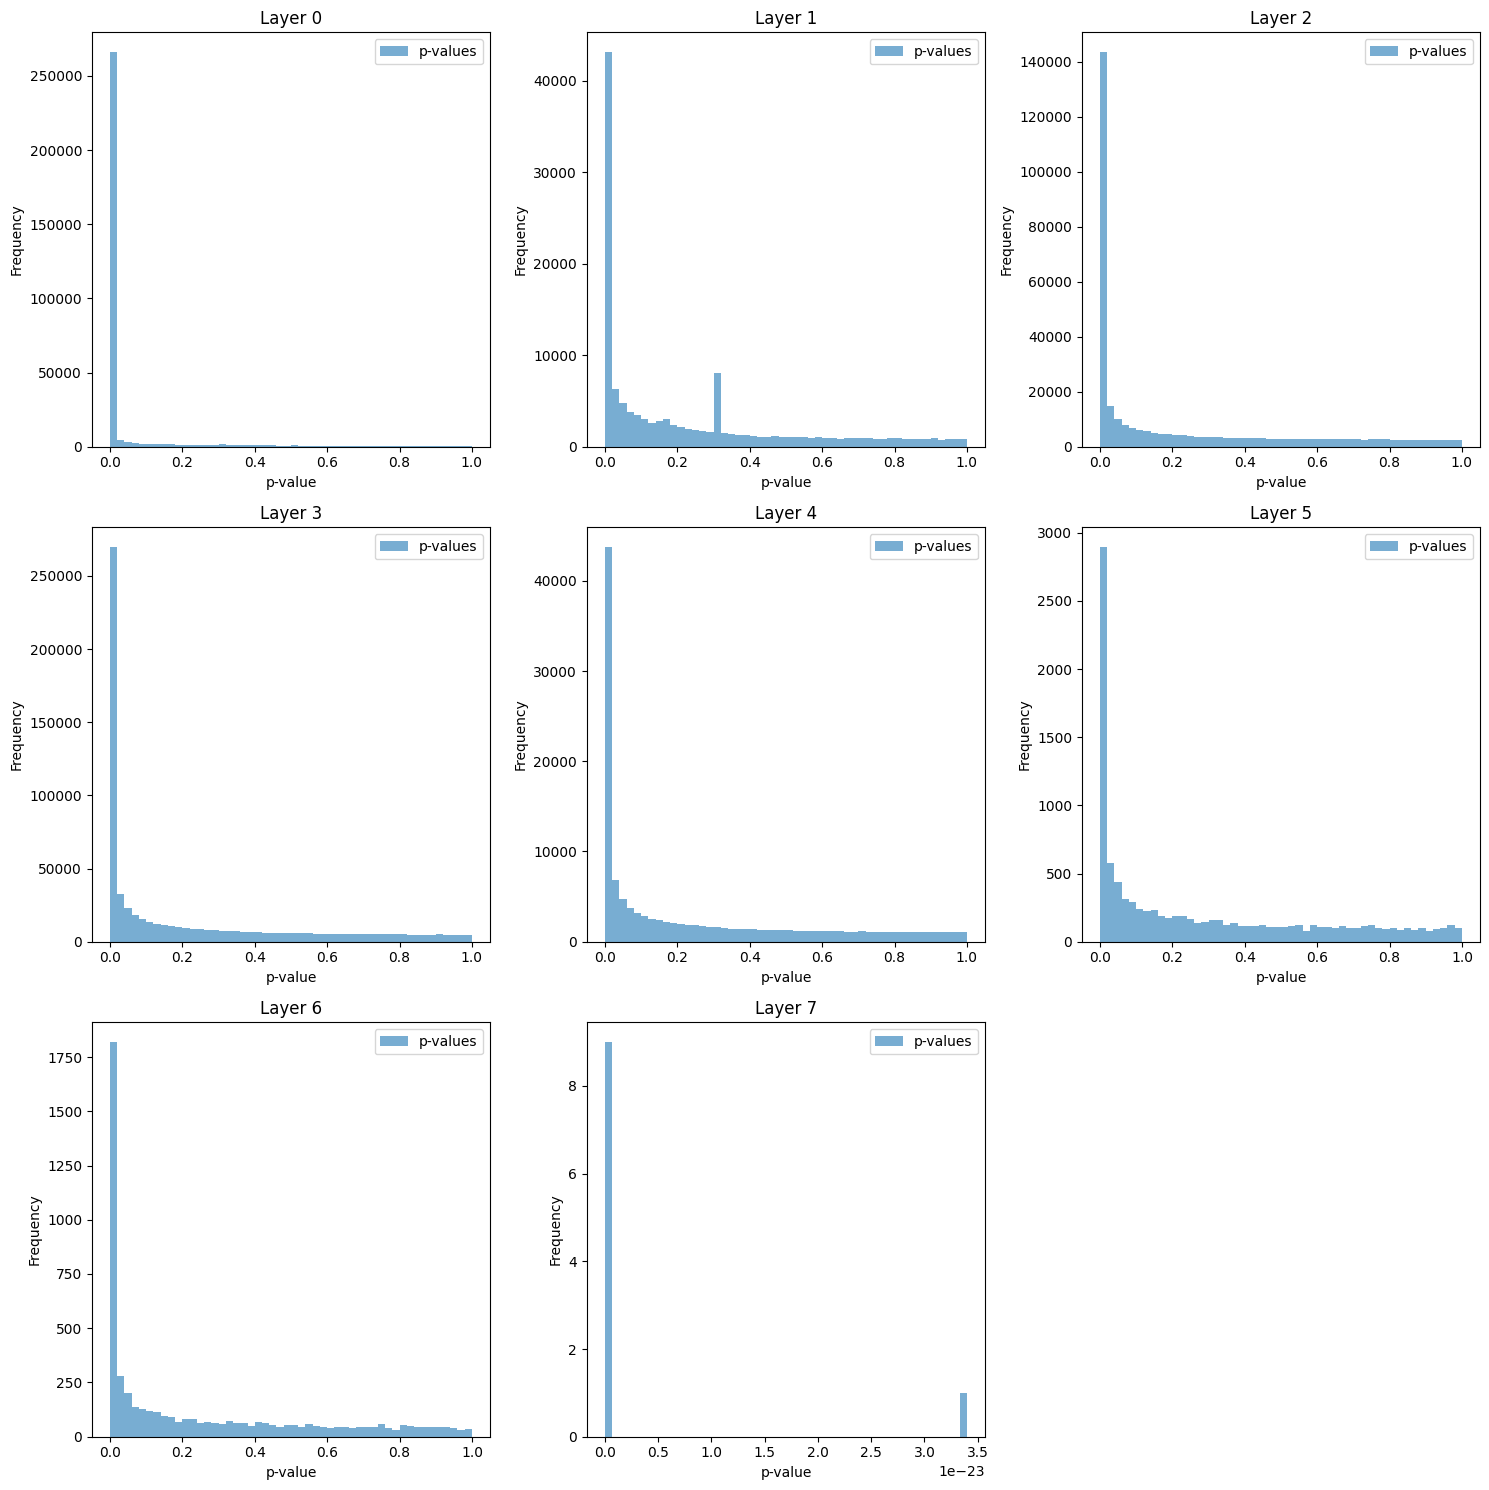

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Load activations
def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True)

# Perform two-sample t-tests comparing neuron activations
def perform_two_sample_t_tests(background_activations, original_activations):
    t_test_results = {}
    for layer in background_activations.keys():
        wp_activations = np.vstack(background_activations[layer])
        wo_activations = np.vstack(original_activations[layer])

        # Perform two-sample t-test for each neuron
        ttest_result = ttest_ind(wp_activations, wo_activations, axis=0)

        t_test_results[layer] = {
            'ttest': ttest_result,
            'wp_means': np.mean(wp_activations, axis=0),
            'wo_means': np.mean(wo_activations, axis=0)
        }
    return t_test_results

# Print t-test results with percentages of neurons below or equal to specific p-values
def print_t_test_results(t_test_results):
    for layer, results in t_test_results.items():
        wp_means = results['wp_means']
        wo_means = results['wo_means']
        ttest = results['ttest']

        # Calculate the percentage of neurons below or equal to specific p-value thresholds
        p_values = ttest.pvalue
        below_or_equal_0_05 = np.mean(p_values <= 0.05) * 100
        below_or_equal_0_02 = np.mean(p_values <= 0.02) * 100

        print(f"Layer {layer}:")
        print("  WP Activations:")
        print(f"    Mean: {wp_means.mean():.4f}")
        print("  WO Activations:")
        print(f"    Mean: {wo_means.mean():.4f}")
        print("  T-Test:")
        print(f"    T-statistic: {ttest.statistic.mean():.4f}")
        print(f"    P-value: {ttest.pvalue.mean():.4f}")
        print(f"    Percentage of neurons with p-value <= 0.05: {below_or_equal_0_05:.2f}%")
        print(f"    Percentage of neurons with p-value <= 0.02: {below_or_equal_0_02:.2f}%")
        print("-" * 50)

# Plot the p-values to visualize significance
def plot_p_values(t_test_results):
    num_layers = len(t_test_results)
    num_cols = 3
    num_rows = (num_layers + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 5 * num_rows))
    for idx, (layer, results) in enumerate(t_test_results.items()):
        p_values = results['ttest'].pvalue

        ax = plt.subplot(num_rows, num_cols, idx + 1)
        ax.hist(p_values, bins=50, alpha=0.6, label='p-values')
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('p-value')
        ax.set_ylabel('Frequency')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers

# Load activations for both background and original conditions
background_activations = {layer: load_activations('background', f'activations.npy_{layer}.npy') for layer in layers_of_interest}
original_activations = {layer: load_activations('original', f'activations.npy_{layer}.npy') for layer in layers_of_interest}

# Perform two-sample t-tests
t_test_results = perform_two_sample_t_tests(background_activations, original_activations)

# Print t-test results
print_t_test_results(t_test_results)

# Plot p-values
plot_p_values(t_test_results)


### Original vs. Colored Digit (Foreground - fg)

#### Correlation

Computing activations and saving to activations.npy


<ipython-input-6-14d45ed9a806>:189: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


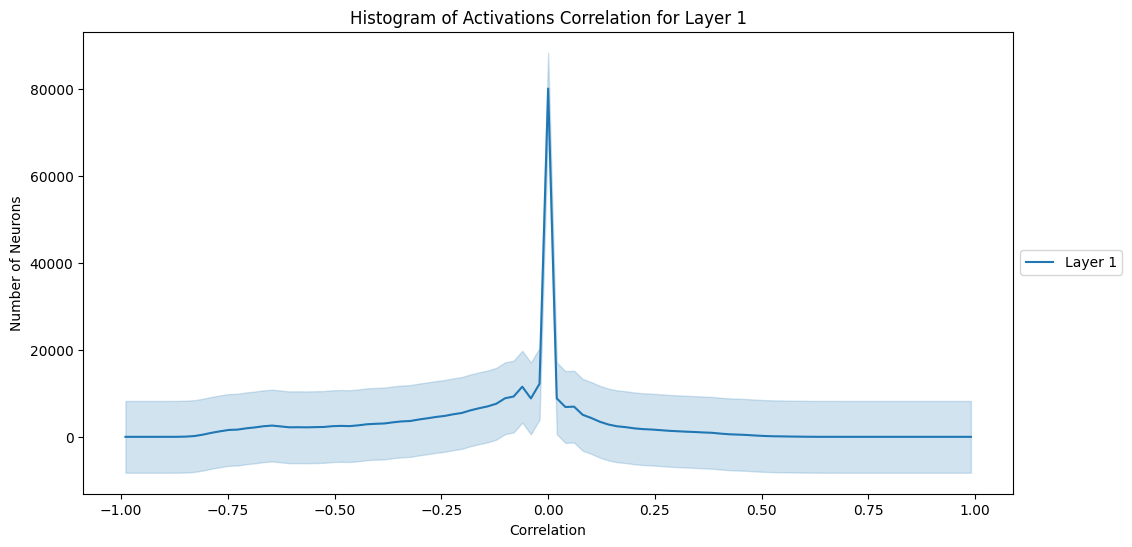

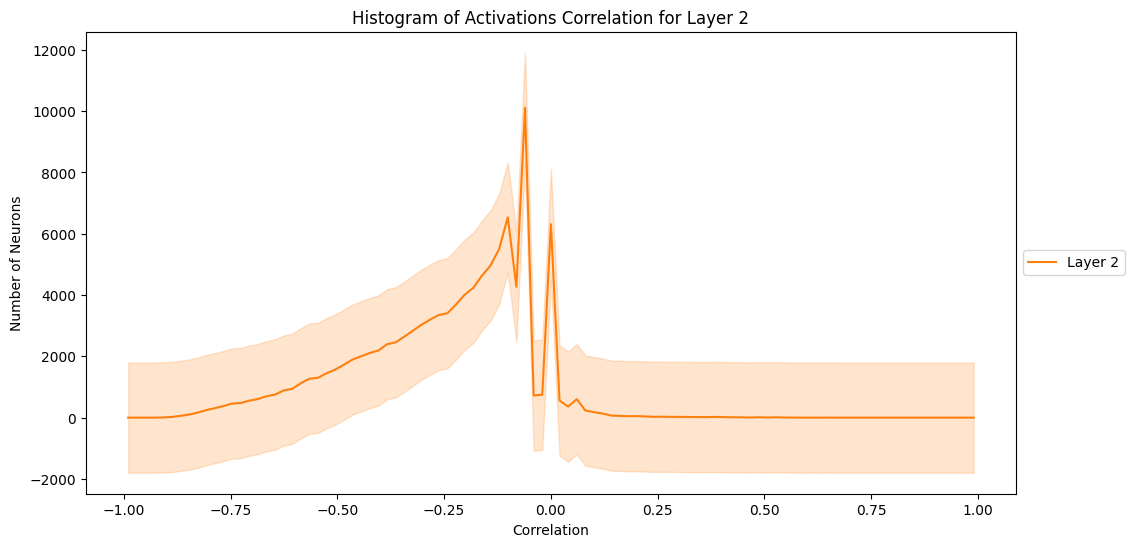

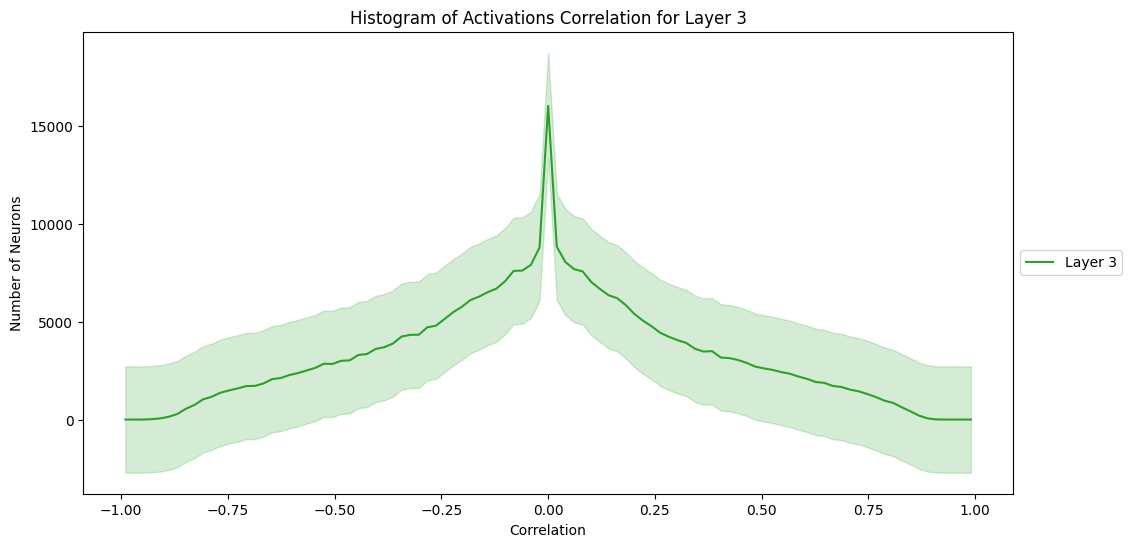

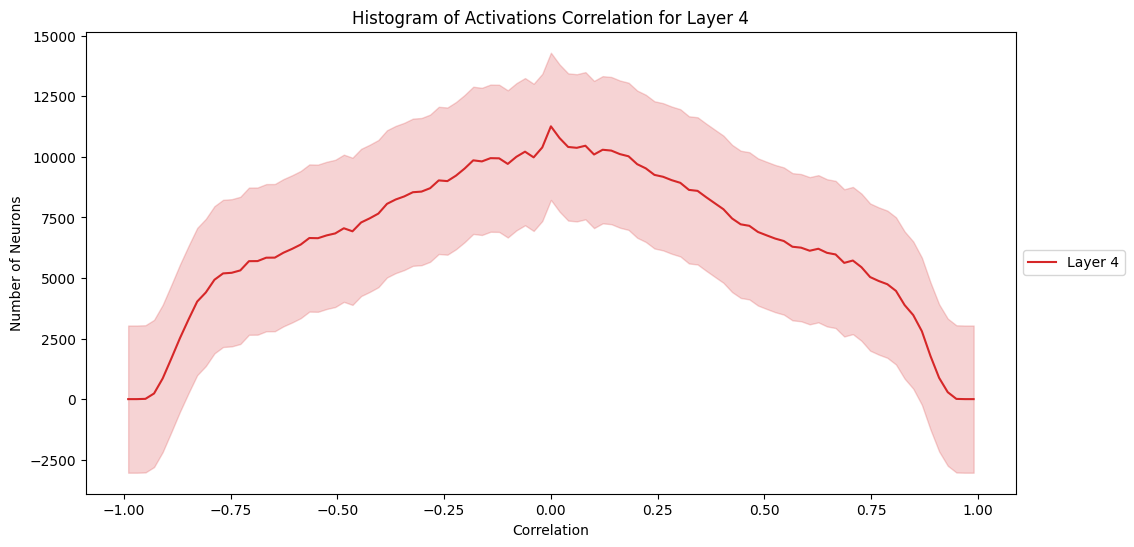

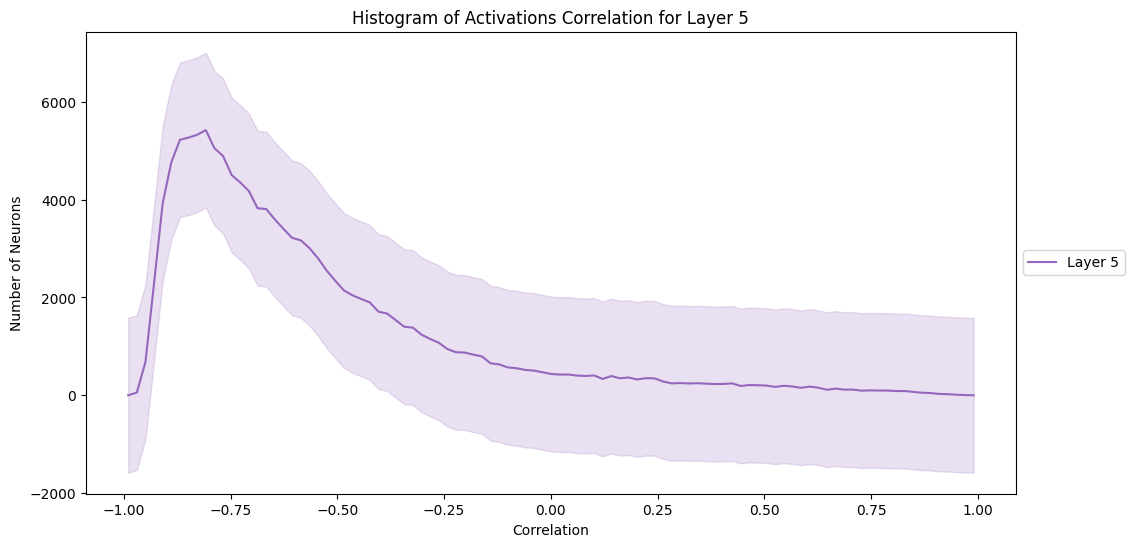

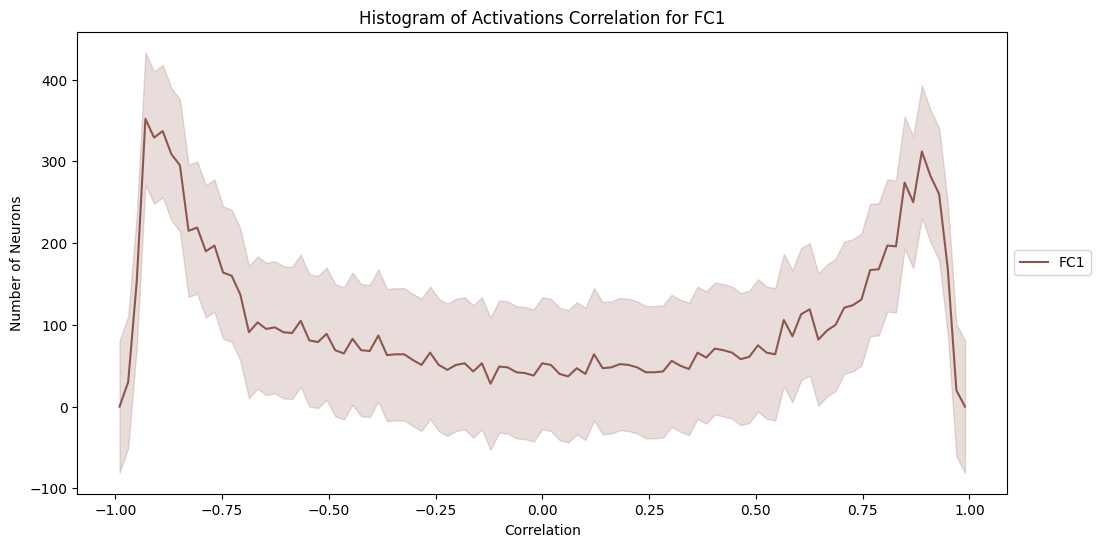

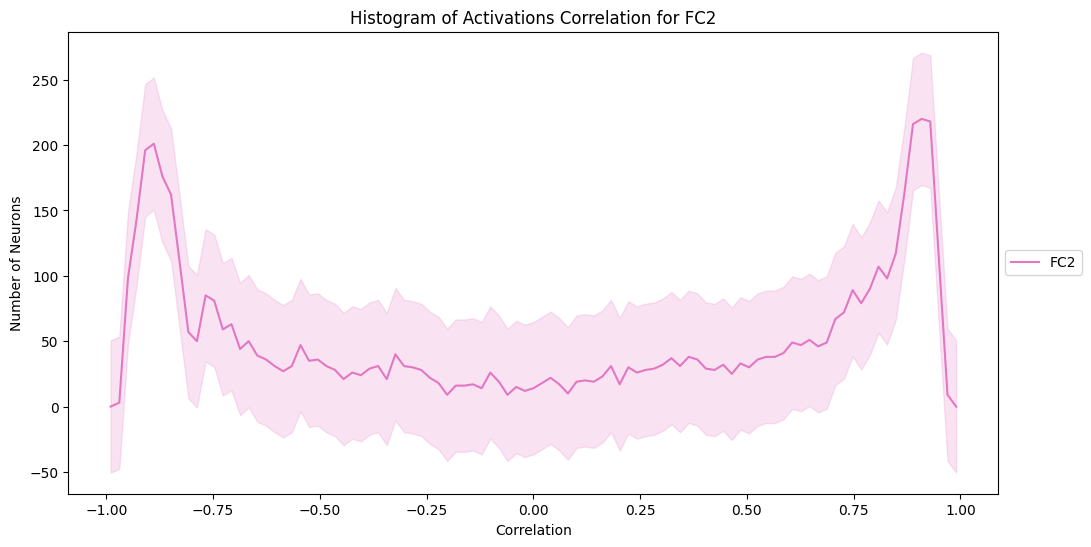

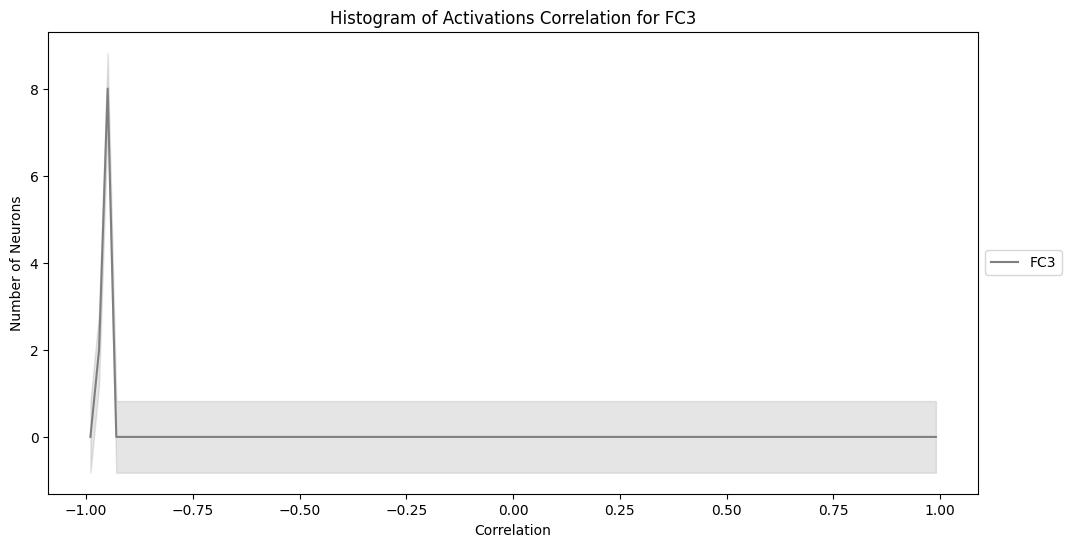

<ipython-input-6-14d45ed9a806>:227: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


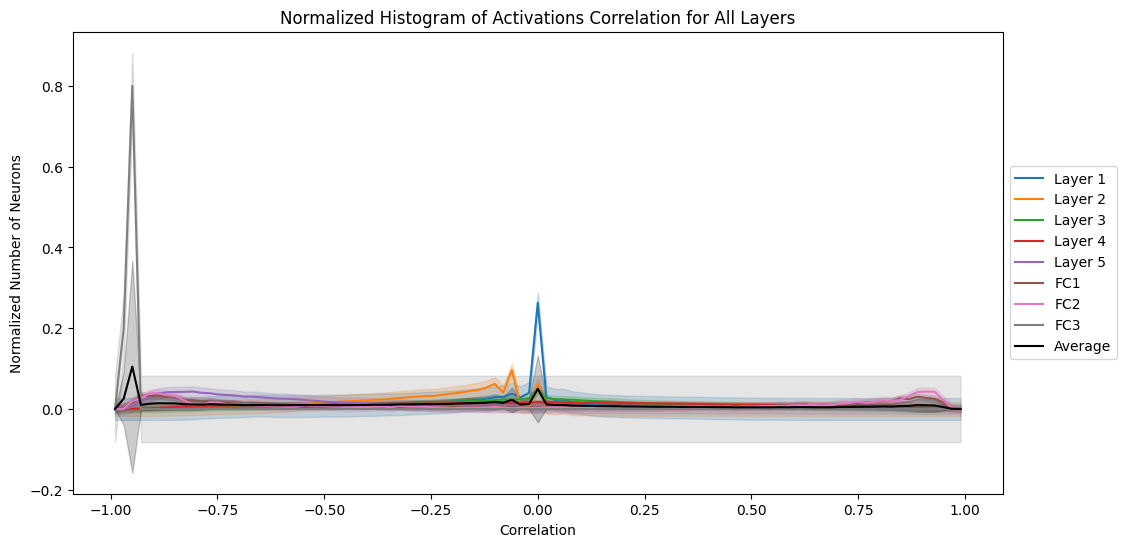

In [6]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import gc
from scipy.stats import pearsonr
from torch.utils.data import DataLoader, Dataset

def load_model(model_path):
    model = AlexNet()
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize((64, 64)),  # Match the resize shape in MnistDataset
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Match the normalization values in MnistDataset
])


class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image


def preprocess_and_extract_activations(model, dataloader, layer):
    activations = []
    with torch.no_grad():
        for image_tensor in dataloader:
            image_tensor = image_tensor.to(device)

            # Extract activations according to the custom model's structure
            if layer == 0:  # Layer 1
                tensor = model.layer1(image_tensor)
            elif layer == 1:  # Layer 2
                tensor = model.layer2(model.layer1(image_tensor))
            elif layer == 2:  # Layer 3
                tensor = model.layer3(model.layer2(model.layer1(image_tensor)))
            elif layer == 3:  # Layer 4
                tensor = model.layer4(model.layer3(model.layer2(model.layer1(image_tensor))))
            elif layer == 4:  # Layer 5
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
            elif layer == 5:  # FC1
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 7 * 7)
                tensor = model.fc1(tensor)
            elif layer == 6:  # FC2
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 7 * 7)
                tensor = model.fc2(model.fc1(tensor))
            elif layer == 7:  # FC3
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 7 * 7)
                tensor = model.fc3(model.fc2(model.fc1(tensor)))

            activation = tensor.cpu().numpy()
            activations.append(activation)

            # Clear memory
            del tensor
            torch.cuda.empty_cache()
            gc.collect()

    return activations

def process_images_in_folder(model, folder_path, layer, batch_size=10):
    all_layer_activations = []

    image_paths = [os.path.join(root, file)
                   for root, dirs, files in os.walk(folder_path)
                   for file in files if file.endswith('.png')]

    dataset = ImageDataset(image_paths=image_paths, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Process in smaller batches to avoid memory issues
    for i, batch in enumerate(dataloader):
        batch_activations = preprocess_and_extract_activations(model, [batch], layer)
        all_layer_activations.extend(batch_activations)
        torch.cuda.empty_cache()
        gc.collect()

    return all_layer_activations

def flatten_and_align_activations(activations_list):
    # Flatten activations and find the maximum length
    flat_activations = [act.flatten() for act in activations_list]
    max_length = max(len(act) for act in flat_activations)

    # Pad or truncate activations to the maximum length
    aligned_activations = []
    for activation in flat_activations:
        if len(activation) < max_length:
            padded_activation = np.pad(activation, (0, max_length - len(activation)), 'constant')
        else:
            padded_activation = activation[:max_length]
        aligned_activations.append(padded_activation)
    return np.vstack(aligned_activations)

def save_activations(all_layer_activations, folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/{folder_name}/{filename}'
    os.makedirs(os.path.dirname(drive_path), exist_ok=True)
    np.save(drive_path, all_layer_activations)

def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

def compute_activations_for_layers(model_paths, patch_folder, no_patch_folder, layers, activations_file='activations.npy'):
    if os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/original/{activations_file}') and \
       os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/foreground/{activations_file}'):
        print(f"Loading activations from {activations_file}")
        wp_activations = load_activations('foreground', activations_file)
        wo_activations = load_activations('original', activations_file)
        return {layer: {'wp': wp_activations[layer], 'wo': wo_activations[layer]} for layer in layers}

    print(f"Computing activations and saving to {activations_file}")
    all_layer_activations = {layer: {'wp': [], 'wo': []} for layer in layers}

    for model_path in model_paths:
        model = load_model(model_path)
        for layer in layers:
            wp_activations = process_images_in_folder(model, patch_folder, layer)
            wo_activations = process_images_in_folder(model, no_patch_folder, layer)
            all_layer_activations[layer]['wp'].append(flatten_and_align_activations(wp_activations))
            all_layer_activations[layer]['wo'].append(flatten_and_align_activations(wo_activations))
        del model  # Free model resources after use
        torch.cuda.empty_cache()
        gc.collect()

    for layer in layers:
        save_activations(all_layer_activations[layer]['wp'], 'foreground', f'{activations_file}_{layer}.npy')
        save_activations(all_layer_activations[layer]['wo'], 'original', f'{activations_file}_{layer}.npy')

    return all_layer_activations

def compute_avg_std_activations(all_layer_activations, layers):
    layer_avg_std = {layer: {'wp_avg': None, 'wo_avg': None, 'wp_std': None, 'wo_std': None} for layer in layers}

    for layer in layers:
        wp_all_models_layer_activations = np.stack(all_layer_activations[layer]['wp'], axis=0)
        wo_all_models_layer_activations = np.stack(all_layer_activations[layer]['wo'], axis=0)

        wp_avg = np.mean(wp_all_models_layer_activations, axis=0)
        wo_avg = np.mean(wo_all_models_layer_activations, axis=0)
        wp_std = np.std(wp_all_models_layer_activations, axis=0)
        wo_std = np.std(wo_all_models_layer_activations, axis=0)

        layer_avg_std[layer]['wp_avg'] = wp_avg
        layer_avg_std[layer]['wo_avg'] = wo_avg
        layer_avg_std[layer]['wp_std'] = wp_std
        layer_avg_std[layer]['wo_std'] = wo_std

    return layer_avg_std

def plot_histogram_for_layer(layer_avg_std, layer, layer_name, color):
    wp_avg = layer_avg_std[layer]['wp_avg']
    wo_avg = layer_avg_std[layer]['wo_avg']
    wp_std = layer_avg_std[layer]['wp_std']
    wo_std = layer_avg_std[layer]['wo_std']

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
    combined_activations = np.vstack((wo_avg, wp_avg))

    A = []
    for ii in range(combined_activations.shape[1]):
        A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

    B = np.histogram(A, bins=x)

    bin_means = B[0]
    bin_stds = np.std(bin_means)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(xaxis, bin_means, '-', color=color, label=layer_name)
    ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.2)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Histogram of Activations Correlation for {layer_name}')
    plt.xlabel('Correlation')
    plt.ylabel('Number of Neurons')
    plt.show()

def plot_combined_histogram(layer_avg_std, layer_names, colors):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    all_layer_bin_means = []

    for idx, (layer, layer_name) in enumerate(layer_names.items()):
        wp_avg = layer_avg_std[layer]['wp_avg']
        wo_avg = layer_avg_std[layer]['wo_avg']
        wp_std = layer_avg_std[layer]['wp_std']
        wo_std = layer_avg_std[layer]['wo_std']

        patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
        combined_activations = np.vstack((wo_avg, wp_avg))

        A = []
        for ii in range(combined_activations.shape[1]):
            A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

        B = np.histogram(A, bins=x)

        bin_means = B[0] / np.sum(B[0])  # Normalize the bin counts
        bin_stds = np.std(bin_means)

        all_layer_bin_means.append(bin_means)

        ax.plot(xaxis, bin_means, '-', color=colors[idx], label=layer_name)
        ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=colors[idx], alpha=0.2)

    # Compute average and standard deviation of the normalized histograms across layers
    all_layer_bin_means = np.array(all_layer_bin_means)
    avg_bin_means = np.mean(all_layer_bin_means, axis=0)
    std_bin_means = np.std(all_layer_bin_means, axis=0)

    ax.plot(xaxis, avg_bin_means, '-', color='black', label='Average')
    ax.fill_between(xaxis, avg_bin_means - std_bin_means, avg_bin_means + std_bin_means, color='black', alpha=0.2)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Normalized Histogram of Activations Correlation for All Layers')
    plt.xlabel('Correlation')
    plt.ylabel('Normalized Number of Neurons')
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers
layer_names = {
    0: "Layer 1",
    1: "Layer 2",
    2: "Layer 3",
    3: "Layer 4",
    4: "Layer 5",
    5: "FC1",
    6: "FC2",
    7: "FC3"
}
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

fg_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/foreground/test/class_2'
org_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_2'

model_paths = [
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_fg_cl0_cl2_1train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_fg_cl0_cl2_11train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_fg_cl0_cl2_111train.pt"
]

all_layer_activations = compute_activations_for_layers(model_paths, fg_mnist_folder_path, org_mnist_folder_path, layers_of_interest)
layer_avg_std = compute_avg_std_activations(all_layer_activations, layers_of_interest)

# Plot histograms for each layer
for idx, (layer, layer_name) in enumerate(layer_names.items()):
    plot_histogram_for_layer(layer_avg_std, layer, layer_name, colors[idx])

# Plot combined histogram for all layers
plot_combined_histogram(layer_avg_std, layer_names, colors)


improved version for more efficient data loading and processing images in smaller batches and clears memory after

In [ ]:
'''
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import gc
from scipy.stats import pearsonr
from torch.utils.data import DataLoader, Dataset

def load_model(model_path):
    model = AlexNet()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize((64, 64)),  # Match the resize shape in MnistDataset
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Match the normalization values in MnistDataset
])

class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image

def preprocess_and_extract_activations(model, dataloader, layer):
    activations = []
    with torch.no_grad():
        for image_tensor in dataloader:
            image_tensor = image_tensor.to(device)

            if layer == 0:  # Layer 1
                tensor = model.layer1(image_tensor)
            elif layer == 1:  # Layer 2
                tensor = model.layer2(model.layer1(image_tensor))
            elif layer == 2:  # Layer 3
                tensor = model.layer3(model.layer2(model.layer1(image_tensor)))
            elif layer == 3:  # Layer 4
                tensor = model.layer4(model.layer3(model.layer2(model.layer1(image_tensor))))
            elif layer == 4:  # Layer 5
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
            elif layer == 5:  # FC1
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 7 * 7)
                tensor = model.fc1(tensor)
            elif layer == 6:  # FC2
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 7 * 7)
                tensor = model.fc2(model.fc1(tensor))
            elif layer == 7:  # FC3
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 7 * 7)
                tensor = model.fc3(model.fc2(model.fc1(tensor)))

            activation = tensor.cpu().numpy()
            activations.append(activation)

            del tensor
            torch.cuda.empty_cache()
            gc.collect()

    return activations

def process_images_in_folder(model, folder_path, layer, batch_size=10):
    all_layer_activations = []

    image_paths = [os.path.join(root, file)
                   for root, dirs, files in os.walk(folder_path)
                   for file in files if file.endswith('.png')]

    dataset = ImageDataset(image_paths=image_paths, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    for i, batch in enumerate(dataloader):
        batch_activations = preprocess_and_extract_activations(model, [batch], layer)
        all_layer_activations.extend(batch_activations)
        torch.cuda.empty_cache()
        gc.collect()

    return all_layer_activations

def flatten_and_align_activations(activations_list):
    flat_activations = [act.flatten() for act in activations_list]
    max_length = max(len(act) for act in flat_activations)

    aligned_activations = []
    for activation in flat_activations:
        if len(activation) < max_length:
            padded_activation = np.pad(activation, (0, max_length - len(activation)), 'constant')
        else:
            padded_activation = activation[:max_length]
        aligned_activations.append(padded_activation)
    return np.vstack(aligned_activations)

def save_activations(all_layer_activations, folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/{folder_name}/{filename}'
    os.makedirs(os.path.dirname(drive_path), exist_ok=True)
    np.save(drive_path, all_layer_activations)

def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

def compute_activations_for_layers(model_paths, patch_folder, no_patch_folder, layers, activations_file='activations.npy'):
    if os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/original/{activations_file}') and \
       os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/foreground/{activations_file}'):
        print(f"Loading activations from {activations_file}")
        wp_activations = load_activations('foreground', activations_file)
        wo_activations = load_activations('original', activations_file)
        return {layer: {'wp': wp_activations[layer], 'wo': wo_activations[layer]} for layer in layers}

    print(f"Computing activations and saving to {activations_file}")
    all_layer_activations = {layer: {'wp': [], 'wo': []} for layer in layers}

    for model_path in model_paths:
        model = load_model(model_path)
        for layer in layers:
            wp_activations = process_images_in_folder(model, patch_folder, layer)
            wo_activations = process_images_in_folder(model, no_patch_folder, layer)
            all_layer_activations[layer]['wp'].append(flatten_and_align_activations(wp_activations))
            all_layer_activations[layer]['wo'].append(flatten_and_align_activations(wo_activations))
        del model
        torch.cuda.empty_cache()
        gc.collect()

    for layer in layers:
        save_activations(all_layer_activations[layer]['wp'], 'foreground', f'{activations_file}_{layer}.npy')
        save_activations(all_layer_activations[layer]['wo'], 'original', f'{activations_file}_{layer}.npy')

    return all_layer_activations

def compute_avg_std_activations(all_layer_activations, layers):
    layer_avg_std = {layer: {'wp_avg': None, 'wo_avg': None, 'wp_std': None, 'wo_std': None} for layer in layers}

    for layer in layers:
        wp_all_models_layer_activations = np.stack(all_layer_activations[layer]['wp'], axis=0)
        wo_all_models_layer_activations = np.stack(all_layer_activations[layer]['wo'], axis=0)

        wp_avg = np.mean(wp_all_models_layer_activations, axis=0)
        wo_avg = np.mean(wo_all_models_layer_activations, axis=0)
        wp_std = np.std(wp_all_models_layer_activations, axis=0)
        wo_std = np.std(wo_all_models_layer_activations, axis=0)

        layer_avg_std[layer]['wp_avg'] = wp_avg
        layer_avg_std[layer]['wo_avg'] = wo_avg
        layer_avg_std[layer]['wp_std'] = wp_std
        layer_avg_std[layer]['wo_std'] = wo_std

    return layer_avg_std

def plot_histogram_for_layer(layer_avg_std, layer, layer_name, color):
    wp_avg = layer_avg_std[layer]['wp_avg']
    wo_avg = layer_avg_std[layer]['wo_avg']
    wp_std = layer_avg_std[layer]['wp_std']
    wo_std = layer_avg_std[layer]['wo_std']

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
    combined_activations = np.vstack((wo_avg, wp_avg))

    A = []
    for ii in range(combined_activations.shape[1]):
        A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

    B = np.histogram(A, bins=x)

    bin_means = B[0]
    bin_stds = np.std(bin_means)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(xaxis, bin_means, '-', color=color, label=layer_name)
    ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.2)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Histogram of Activations Correlation for {layer_name}')
    plt.xlabel('Correlation')
    plt.ylabel('Number of Neurons')
    plt.show()

def plot_combined_histogram(layer_avg_std, layer_names, colors):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    all_layer_bin_means = []

    for idx, (layer, layer_name) in enumerate(layer_names.items()):
        wp_avg = layer_avg_std[layer]['wp_avg']
        wo_avg = layer_avg_std[layer]['wo_avg']
        wp_std = layer_avg_std[layer]['wp_std']
        wo_std = layer_avg_std[layer]['wo_std']

        patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
        combined_activations = np.vstack((wo_avg, wp_avg))

        A = []
        for ii in range(combined_activations.shape[1]):
            A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

        B = np.histogram(A, bins=x)

        bin_means = B[0] / np.sum(B[0])
        bin_stds = np.std(bin_means)

        all_layer_bin_means.append(bin_means)

        ax.plot(xaxis, bin_means, '-', color=colors[idx], label=layer_name)
        ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=colors[idx], alpha=0.2)

    all_layer_bin_means = np.array(all_layer_bin_means)
    avg_bin_means = np.mean(all_layer_bin_means, axis=0)
    std_bin_means = np.std(all_layer_bin_means, axis=0)

    ax.plot(xaxis, avg_bin_means, '-', color='black', label='Average')
    ax.fill_between(xaxis, avg_bin_means - std_bin_means, avg_bin_means + std_bin_means, color='black', alpha=0.2)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Normalized Histogram of Activations Correlation for All Layers')
    plt.xlabel('Correlation')
    plt.ylabel('Normalized Number of Neurons')
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]
layer_names = {
    0: "Layer 1",
    1: "Layer 2",
    2: "Layer 3",
    3: "Layer 4",
    4: "Layer 5",
    5: "FC1",
    6: "FC2",
    7: "FC3"
}
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

fg_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/foreground/test/class_2'
org_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_2'

model_paths = [
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_fg_cl0_cl2_1train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_fg_cl0_cl2_11train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_fg_cl0_cl2_111train.pt"
]

all_layer_activations = compute_activations_for_layers(model_paths, fg_mnist_folder_path, org_mnist_folder_path, layers_of_interest)
layer_avg_std = compute_avg_std_activations(all_layer_activations, layers_of_interest)

for idx, (layer, layer_name) in enumerate(layer_names.items()):
    plot_histogram_for_layer(layer_avg_std, layer, layer_name, colors[idx])

plot_combined_histogram(layer_avg_std, layer_names, colors)
'''


#### Two sample t-test

Layer 0:
  WP Activations:
    Mean: 0.3743
  WO Activations:
    Mean: 0.4286
  T-Test:
    T-statistic: nan
    P-value: nan
    Percentage of neurons with p-value <= 0.05: 30.16%
    Percentage of neurons with p-value <= 0.02: 27.70%
--------------------------------------------------
Layer 1:
  WP Activations:
    Mean: 0.0090
  WO Activations:
    Mean: 0.0442
  T-Test:
    T-statistic: nan
    P-value: nan
    Percentage of neurons with p-value <= 0.05: 41.16%
    Percentage of neurons with p-value <= 0.02: 37.47%
--------------------------------------------------
Layer 2:
  WP Activations:
    Mean: -0.0020
  WO Activations:
    Mean: 0.0033
  T-Test:
    T-statistic: -0.1515
    P-value: 0.2761
    Percentage of neurons with p-value <= 0.05: 54.13%
    Percentage of neurons with p-value <= 0.02: 50.11%
--------------------------------------------------
Layer 3:
  WP Activations:
    Mean: -0.0003
  WO Activations:
    Mean: -0.0001
  T-Test:
    T-statistic: -0.0251
    P-value:

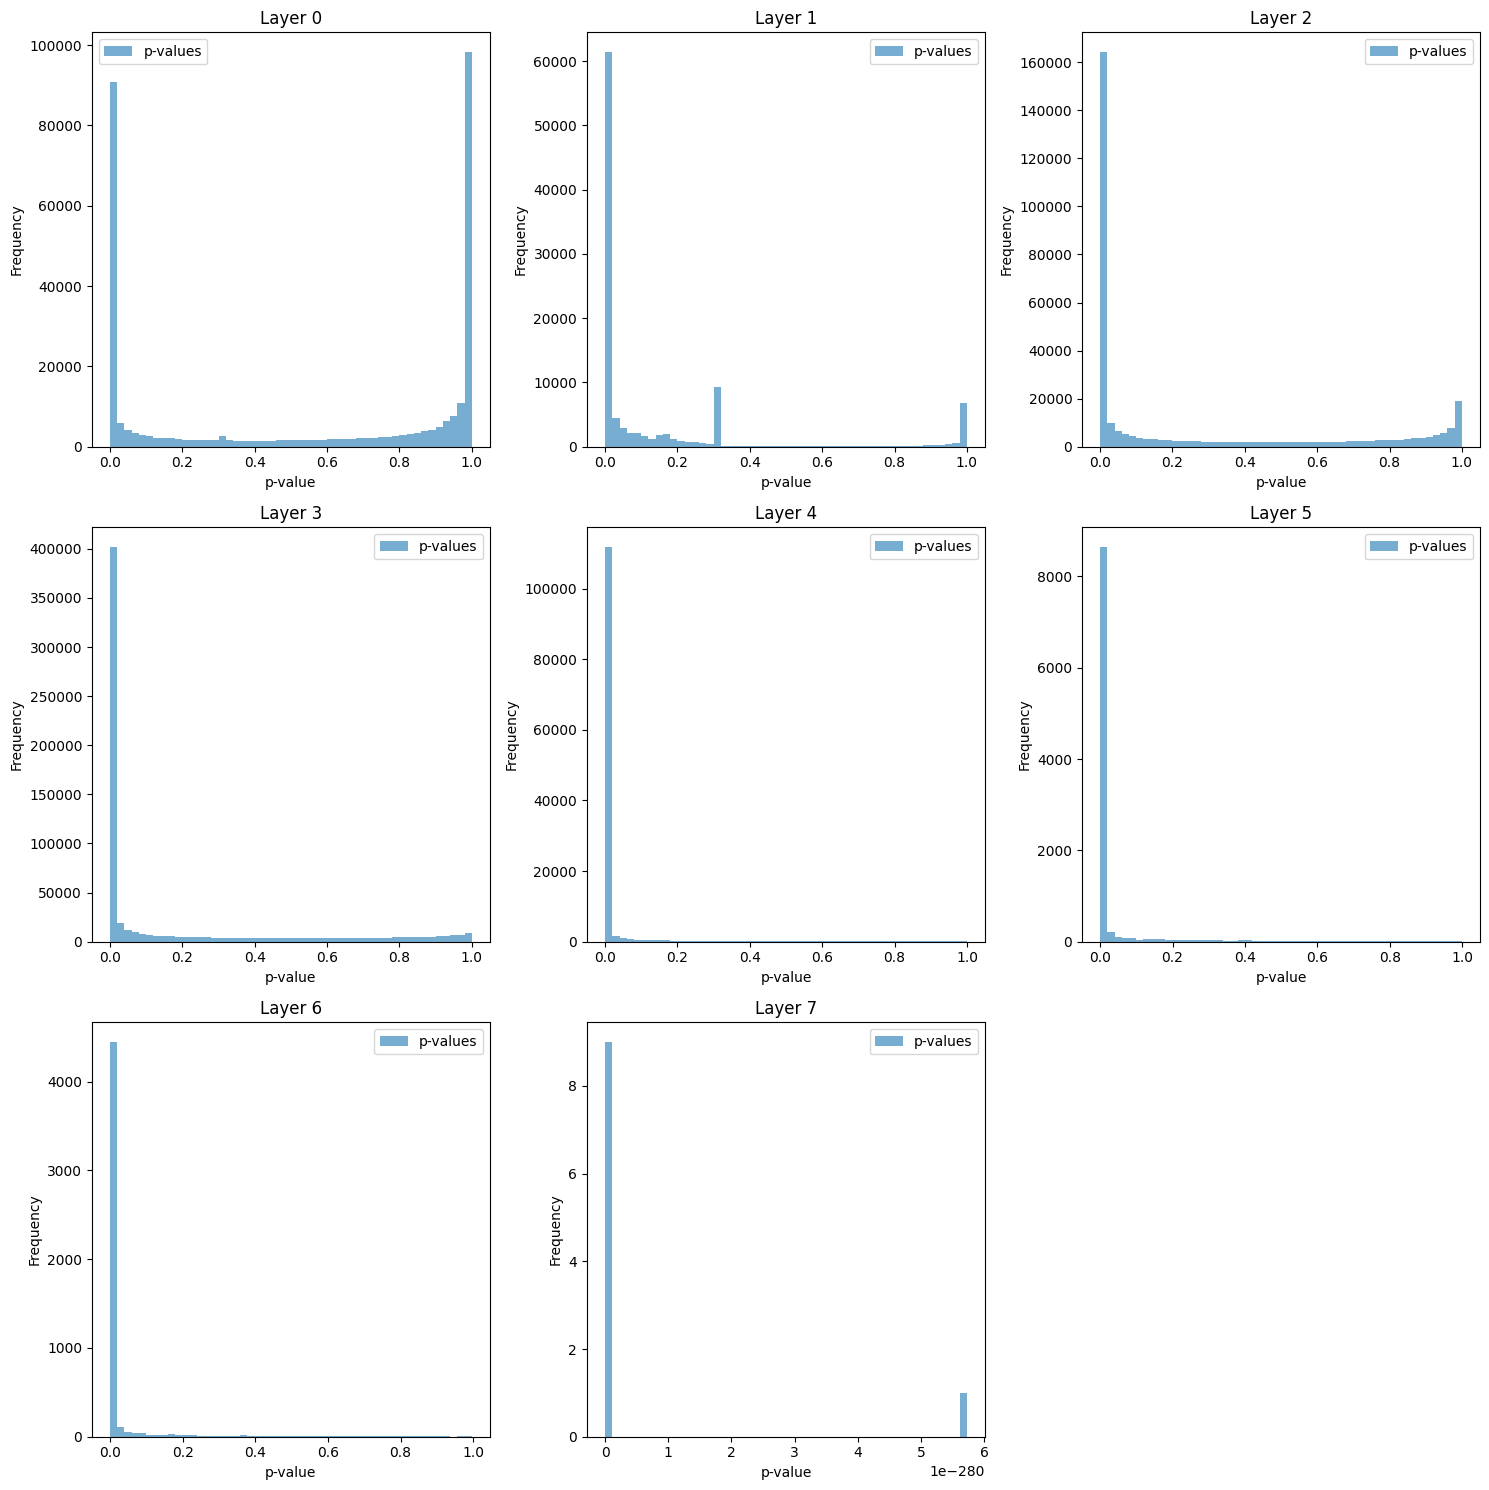

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Load activations
def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True)

# Perform two-sample t-tests comparing neuron activations
def perform_two_sample_t_tests(background_activations, original_activations):
    t_test_results = {}
    for layer in background_activations.keys():
        wp_activations = np.vstack(background_activations[layer])
        wo_activations = np.vstack(original_activations[layer])

        # Perform two-sample t-test for each neuron
        ttest_result = ttest_ind(wp_activations, wo_activations, axis=0)

        t_test_results[layer] = {
            'ttest': ttest_result,
            'wp_means': np.mean(wp_activations, axis=0),
            'wo_means': np.mean(wo_activations, axis=0)
        }
    return t_test_results

# Print t-test results with percentages of neurons below or equal to specific p-values
def print_t_test_results(t_test_results):
    for layer, results in t_test_results.items():
        wp_means = results['wp_means']
        wo_means = results['wo_means']
        ttest = results['ttest']

        # Calculate the percentage of neurons below or equal to specific p-value thresholds
        p_values = ttest.pvalue
        below_or_equal_0_05 = np.mean(p_values <= 0.05) * 100
        below_or_equal_0_02 = np.mean(p_values <= 0.02) * 100

        print(f"Layer {layer}:")
        print("  WP Activations:")
        print(f"    Mean: {wp_means.mean():.4f}")
        print("  WO Activations:")
        print(f"    Mean: {wo_means.mean():.4f}")
        print("  T-Test:")
        print(f"    T-statistic: {ttest.statistic.mean():.4f}")
        print(f"    P-value: {ttest.pvalue.mean():.4f}")
        print(f"    Percentage of neurons with p-value <= 0.05: {below_or_equal_0_05:.2f}%")
        print(f"    Percentage of neurons with p-value <= 0.02: {below_or_equal_0_02:.2f}%")
        print("-" * 50)

# Plot the p-values to visualize significance
def plot_p_values(t_test_results):
    num_layers = len(t_test_results)
    num_cols = 3
    num_rows = (num_layers + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 5 * num_rows))
    for idx, (layer, results) in enumerate(t_test_results.items()):
        p_values = results['ttest'].pvalue

        ax = plt.subplot(num_rows, num_cols, idx + 1)
        ax.hist(p_values, bins=50, alpha=0.6, label='p-values')
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('p-value')
        ax.set_ylabel('Frequency')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers

# Load activations for both foreground and original conditions
foreground_activations = {layer: load_activations('foreground', f'activations.npy_{layer}.npy') for layer in layers_of_interest}
original_activations = {layer: load_activations('original', f'activations.npy_{layer}.npy') for layer in layers_of_interest}

# Perform two-sample t-tests
t_test_results = perform_two_sample_t_tests(foreground_activations, original_activations)

# Print t-test results
print_t_test_results(t_test_results)

# Plot p-values
plot_p_values(t_test_results)


### Original vs. Left Patch (lp)

#### Correlations

Computing activations and saving to activations.npy


<ipython-input-6-7a51e2cacd25>:189: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


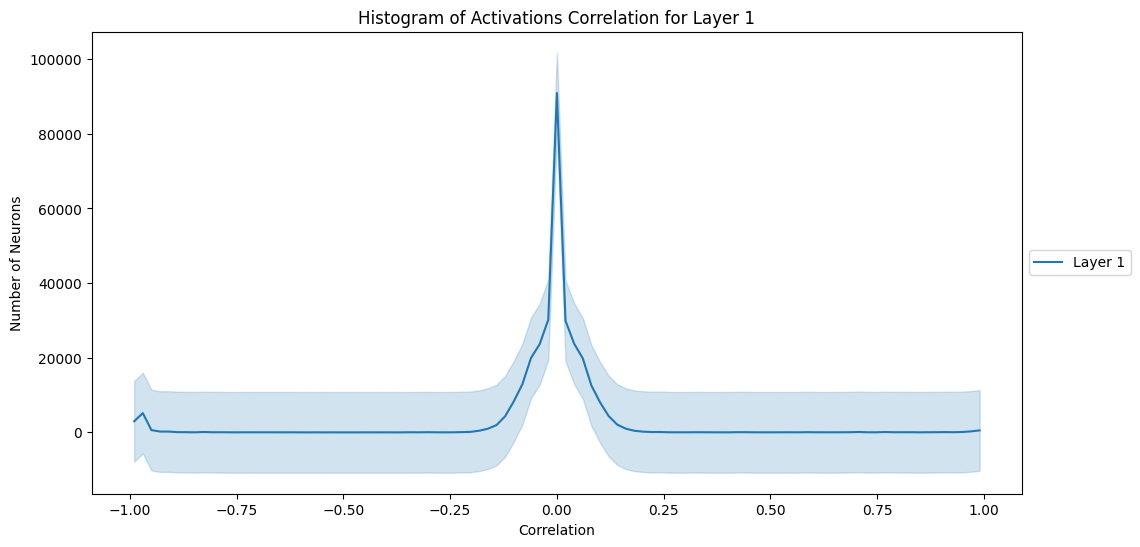

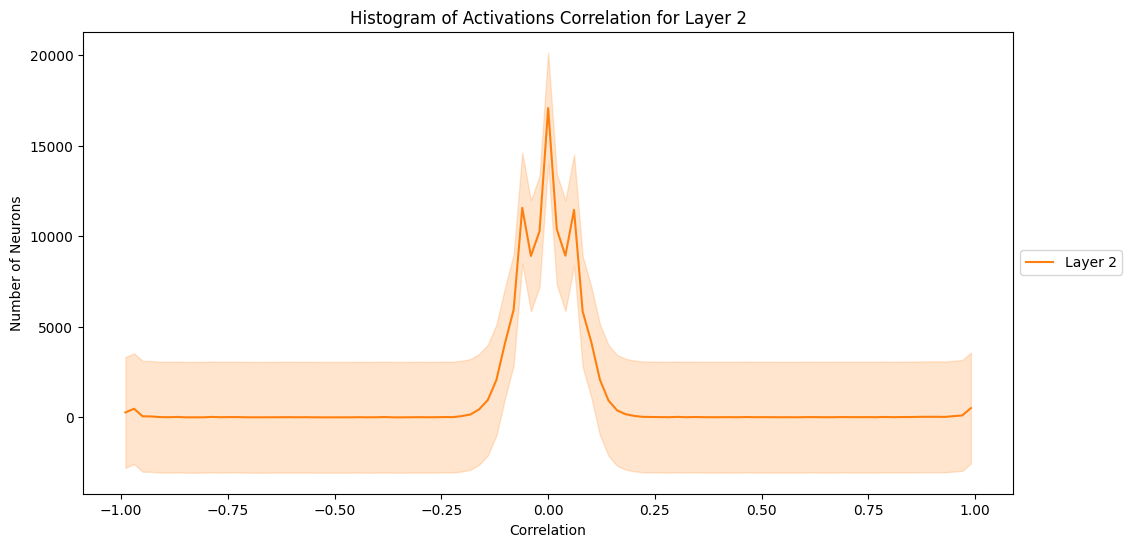

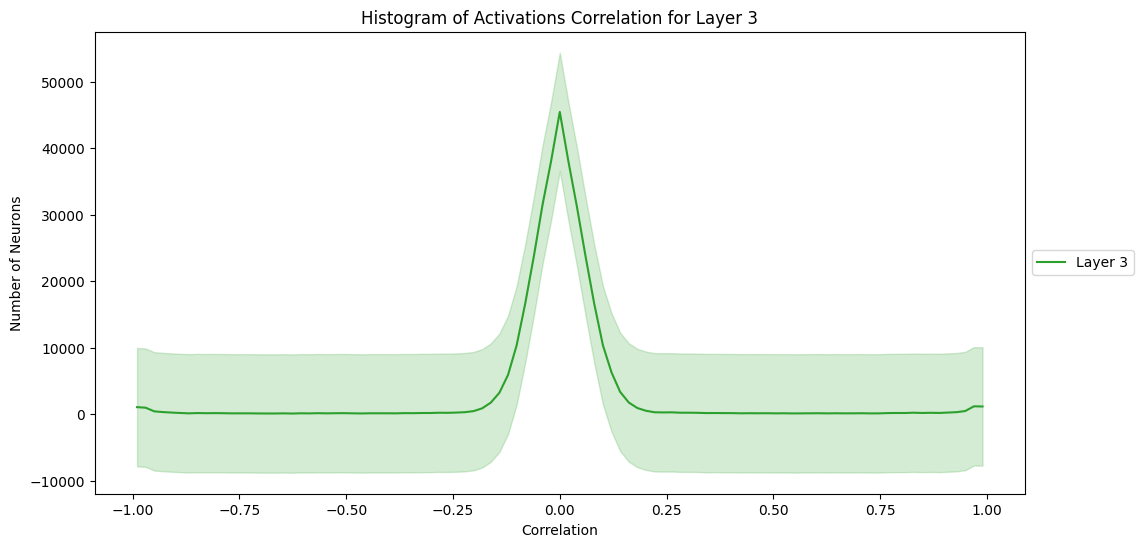

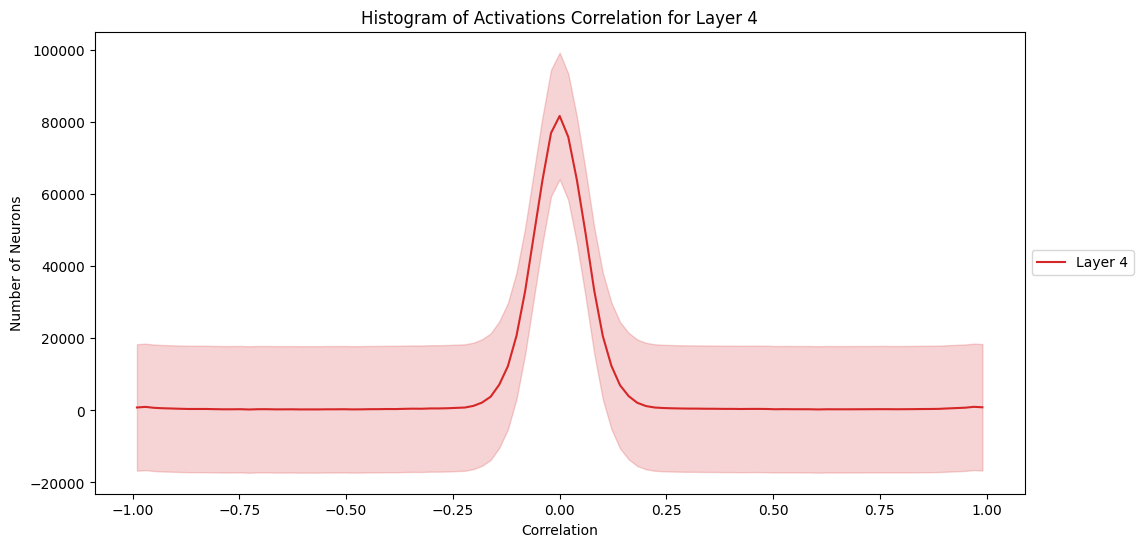

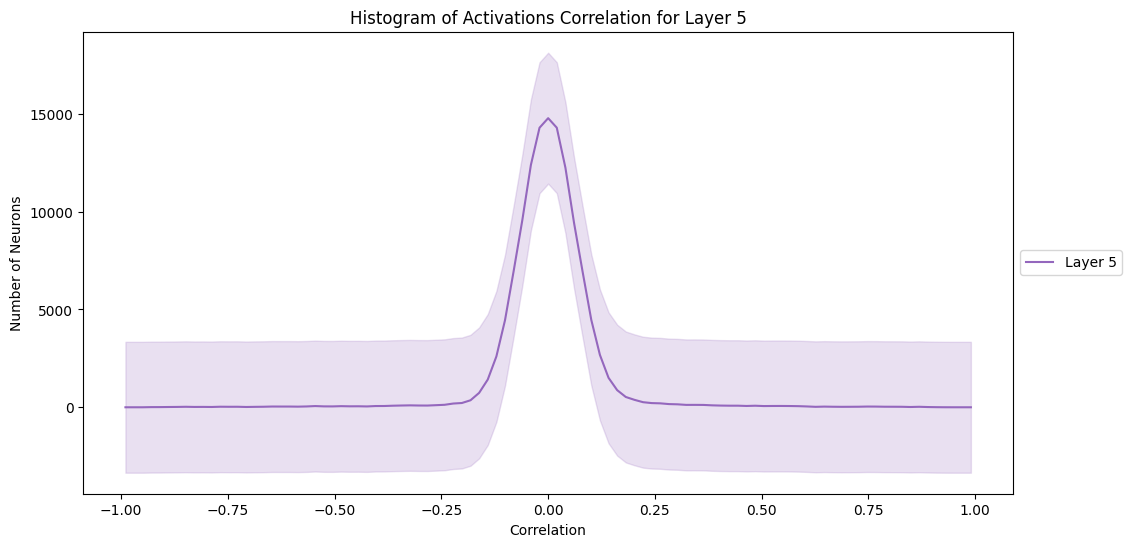

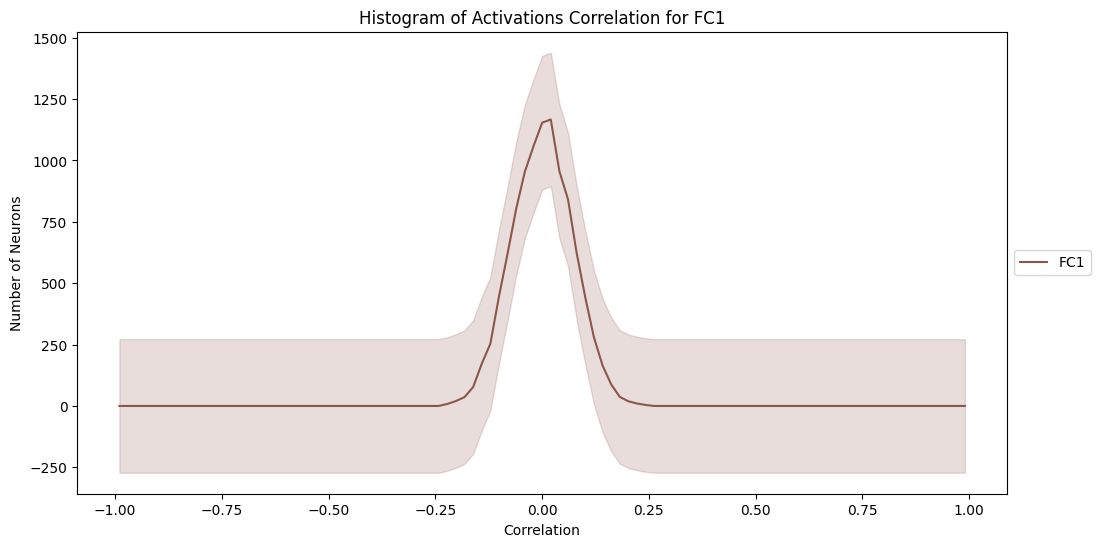

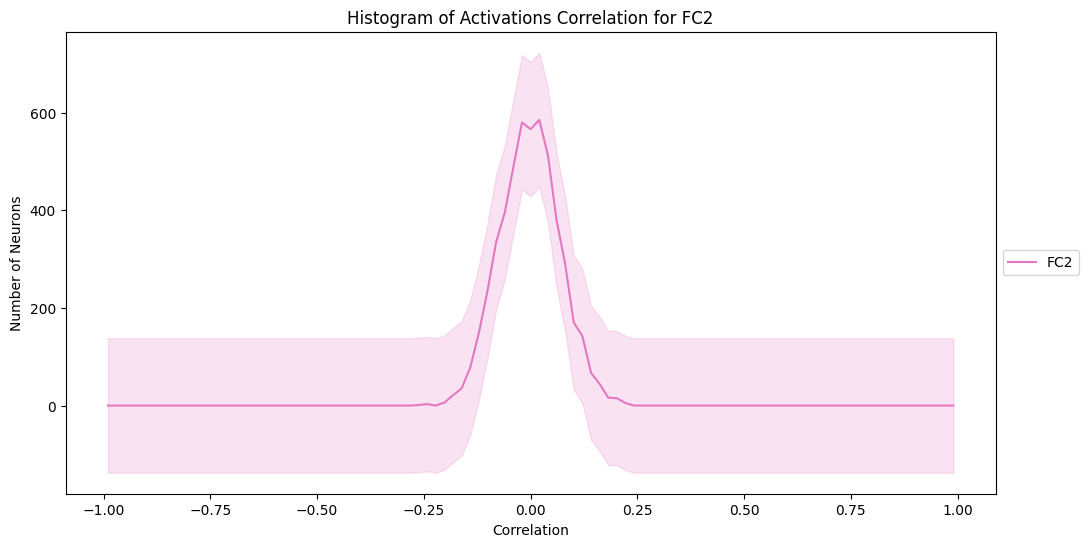

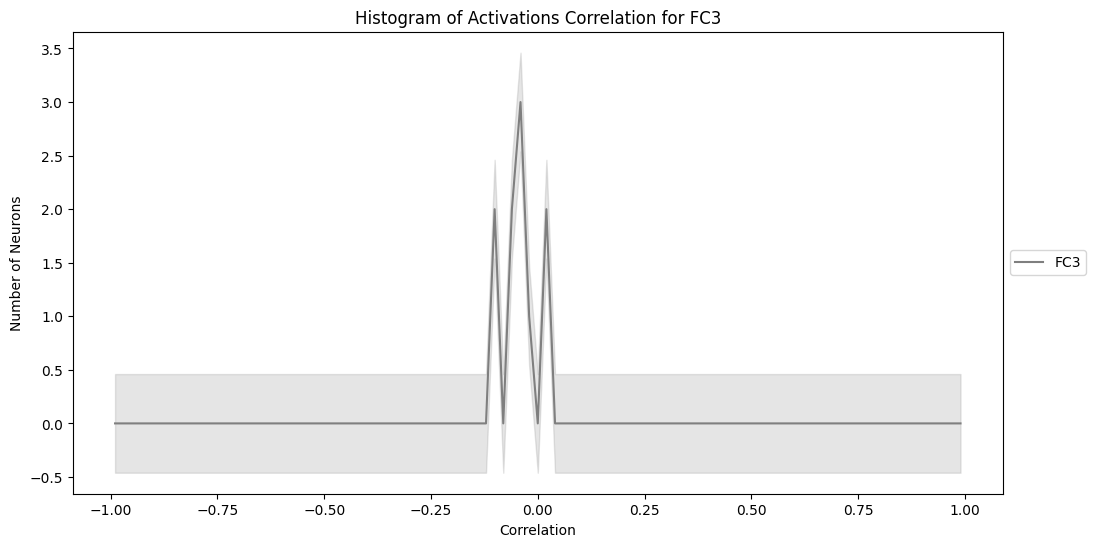

<ipython-input-6-7a51e2cacd25>:227: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


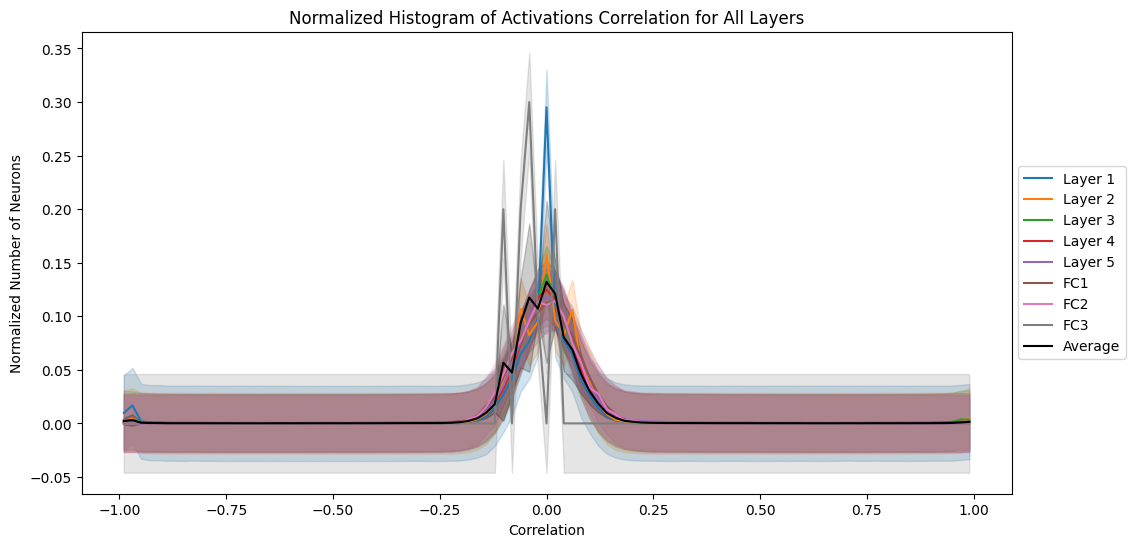

In [6]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import gc
from scipy.stats import pearsonr
from torch.utils.data import DataLoader, Dataset

def load_model(model_path):
    model = AlexNet()
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize((64, 64)),  # Match the resize shape in MnistDataset
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Match the normalization values in MnistDataset
])


class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image


def preprocess_and_extract_activations(model, dataloader, layer):
    activations = []
    with torch.no_grad():
        for image_tensor in dataloader:
            image_tensor = image_tensor.to(device)

            # Extract activations according to the custom model's structure
            if layer == 0:  # Layer 1
                tensor = model.layer1(image_tensor)
            elif layer == 1:  # Layer 2
                tensor = model.layer2(model.layer1(image_tensor))
            elif layer == 2:  # Layer 3
                tensor = model.layer3(model.layer2(model.layer1(image_tensor)))
            elif layer == 3:  # Layer 4
                tensor = model.layer4(model.layer3(model.layer2(model.layer1(image_tensor))))
            elif layer == 4:  # Layer 5
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
            elif layer == 5:  # FC1
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 7 * 7)
                tensor = model.fc1(tensor)
            elif layer == 6:  # FC2
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 7 * 7)
                tensor = model.fc2(model.fc1(tensor))
            elif layer == 7:  # FC3
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 7 * 7)
                tensor = model.fc3(model.fc2(model.fc1(tensor)))

            activation = tensor.cpu().numpy()
            activations.append(activation)

            # Clear memory
            del tensor
            torch.cuda.empty_cache()
            gc.collect()

    return activations

def process_images_in_folder(model, folder_path, layer, batch_size=10):
    all_layer_activations = []

    image_paths = [os.path.join(root, file)
                   for root, dirs, files in os.walk(folder_path)
                   for file in files if file.endswith('.png')]

    dataset = ImageDataset(image_paths=image_paths, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Process in smaller batches to avoid memory issues
    for i, batch in enumerate(dataloader):
        batch_activations = preprocess_and_extract_activations(model, [batch], layer)
        all_layer_activations.extend(batch_activations)
        torch.cuda.empty_cache()
        gc.collect()

    return all_layer_activations

def flatten_and_align_activations(activations_list):
    # Flatten activations and find the maximum length
    flat_activations = [act.flatten() for act in activations_list]
    max_length = max(len(act) for act in flat_activations)

    # Pad or truncate activations to the maximum length
    aligned_activations = []
    for activation in flat_activations:
        if len(activation) < max_length:
            padded_activation = np.pad(activation, (0, max_length - len(activation)), 'constant')
        else:
            padded_activation = activation[:max_length]
        aligned_activations.append(padded_activation)
    return np.vstack(aligned_activations)

def save_activations(all_layer_activations, folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/{folder_name}/{filename}'
    os.makedirs(os.path.dirname(drive_path), exist_ok=True)
    np.save(drive_path, all_layer_activations)

def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

def compute_activations_for_layers(model_paths, patch_folder, no_patch_folder, layers, activations_file='activations.npy'):
    if os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/original/{activations_file}') and \
       os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/left_patch/{activations_file}'):
        print(f"Loading activations from {activations_file}")
        wp_activations = load_activations('left_patch', activations_file)
        wo_activations = load_activations('original', activations_file)
        return {layer: {'wp': wp_activations[layer], 'wo': wo_activations[layer]} for layer in layers}

    print(f"Computing activations and saving to {activations_file}")
    all_layer_activations = {layer: {'wp': [], 'wo': []} for layer in layers}

    for model_path in model_paths:
        model = load_model(model_path)
        for layer in layers:
            wp_activations = process_images_in_folder(model, patch_folder, layer)
            wo_activations = process_images_in_folder(model, no_patch_folder, layer)
            all_layer_activations[layer]['wp'].append(flatten_and_align_activations(wp_activations))
            all_layer_activations[layer]['wo'].append(flatten_and_align_activations(wo_activations))
        del model  # Free model resources after use
        torch.cuda.empty_cache()
        gc.collect()

    for layer in layers:
        save_activations(all_layer_activations[layer]['wp'], 'left_patch', f'{activations_file}_{layer}.npy')
        save_activations(all_layer_activations[layer]['wo'], 'original', f'{activations_file}_{layer}.npy')

    return all_layer_activations

def compute_avg_std_activations(all_layer_activations, layers):
    layer_avg_std = {layer: {'wp_avg': None, 'wo_avg': None, 'wp_std': None, 'wo_std': None} for layer in layers}

    for layer in layers:
        wp_all_models_layer_activations = np.stack(all_layer_activations[layer]['wp'], axis=0)
        wo_all_models_layer_activations = np.stack(all_layer_activations[layer]['wo'], axis=0)

        wp_avg = np.mean(wp_all_models_layer_activations, axis=0)
        wo_avg = np.mean(wo_all_models_layer_activations, axis=0)
        wp_std = np.std(wp_all_models_layer_activations, axis=0)
        wo_std = np.std(wo_all_models_layer_activations, axis=0)

        layer_avg_std[layer]['wp_avg'] = wp_avg
        layer_avg_std[layer]['wo_avg'] = wo_avg
        layer_avg_std[layer]['wp_std'] = wp_std
        layer_avg_std[layer]['wo_std'] = wo_std

    return layer_avg_std

def plot_histogram_for_layer(layer_avg_std, layer, layer_name, color):
    wp_avg = layer_avg_std[layer]['wp_avg']
    wo_avg = layer_avg_std[layer]['wo_avg']
    wp_std = layer_avg_std[layer]['wp_std']
    wo_std = layer_avg_std[layer]['wo_std']

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
    combined_activations = np.vstack((wo_avg, wp_avg))

    A = []
    for ii in range(combined_activations.shape[1]):
        A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

    B = np.histogram(A, bins=x)

    bin_means = B[0]
    bin_stds = np.std(bin_means)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(xaxis, bin_means, '-', color=color, label=layer_name)
    ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.2)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Histogram of Activations Correlation for {layer_name}')
    plt.xlabel('Correlation')
    plt.ylabel('Number of Neurons')
    plt.show()

def plot_combined_histogram(layer_avg_std, layer_names, colors):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    all_layer_bin_means = []

    for idx, (layer, layer_name) in enumerate(layer_names.items()):
        wp_avg = layer_avg_std[layer]['wp_avg']
        wo_avg = layer_avg_std[layer]['wo_avg']
        wp_std = layer_avg_std[layer]['wp_std']
        wo_std = layer_avg_std[layer]['wo_std']

        patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
        combined_activations = np.vstack((wo_avg, wp_avg))

        A = []
        for ii in range(combined_activations.shape[1]):
            A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

        B = np.histogram(A, bins=x)

        bin_means = B[0] / np.sum(B[0])  # Normalize the bin counts
        bin_stds = np.std(bin_means)

        all_layer_bin_means.append(bin_means)

        ax.plot(xaxis, bin_means, '-', color=colors[idx], label=layer_name)
        ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=colors[idx], alpha=0.2)

    # Compute average and standard deviation of the normalized histograms across layers
    all_layer_bin_means = np.array(all_layer_bin_means)
    avg_bin_means = np.mean(all_layer_bin_means, axis=0)
    std_bin_means = np.std(all_layer_bin_means, axis=0)

    ax.plot(xaxis, avg_bin_means, '-', color='black', label='Average')
    ax.fill_between(xaxis, avg_bin_means - std_bin_means, avg_bin_means + std_bin_means, color='black', alpha=0.2)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Normalized Histogram of Activations Correlation for All Layers')
    plt.xlabel('Correlation')
    plt.ylabel('Normalized Number of Neurons')
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers
layer_names = {
    0: "Layer 1",
    1: "Layer 2",
    2: "Layer 3",
    3: "Layer 4",
    4: "Layer 5",
    5: "FC1",
    6: "FC2",
    7: "FC3"
}
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

olp_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/test/class_2'
org_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_2'

model_paths = [
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_olp_cl0_cl2_1train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_olp_cl0_cl2_11train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_olp_cl0_cl2_111train.pt"
]

all_layer_activations = compute_activations_for_layers(model_paths, olp_mnist_folder_path, org_mnist_folder_path, layers_of_interest)
layer_avg_std = compute_avg_std_activations(all_layer_activations, layers_of_interest)

# Plot histograms for each layer
for idx, (layer, layer_name) in enumerate(layer_names.items()):
    plot_histogram_for_layer(layer_avg_std, layer, layer_name, colors[idx])

# Plot combined histogram for all layers
plot_combined_histogram(layer_avg_std, layer_names, colors)


#### Two sample t-test

Layer 0:
  WP Activations:
    Mean: 0.4069
  WO Activations:
    Mean: 0.4138
  T-Test:
    T-statistic: nan
    P-value: nan
    Percentage of neurons with p-value <= 0.05: 5.29%
    Percentage of neurons with p-value <= 0.02: 4.25%
--------------------------------------------------
Layer 1:
  WP Activations:
    Mean: 0.0586
  WO Activations:
    Mean: 0.0588
  T-Test:
    T-statistic: nan
    P-value: nan
    Percentage of neurons with p-value <= 0.05: 2.40%
    Percentage of neurons with p-value <= 0.02: 1.51%
--------------------------------------------------
Layer 2:
  WP Activations:
    Mean: 0.0124
  WO Activations:
    Mean: 0.0123
  T-Test:
    T-statistic: 0.0122
    P-value: 0.6777
    Percentage of neurons with p-value <= 0.05: 4.71%
    Percentage of neurons with p-value <= 0.02: 3.78%
--------------------------------------------------
Layer 3:
  WP Activations:
    Mean: -0.0101
  WO Activations:
    Mean: -0.0102
  T-Test:
    T-statistic: 0.0089
    P-value: 0.6775
 

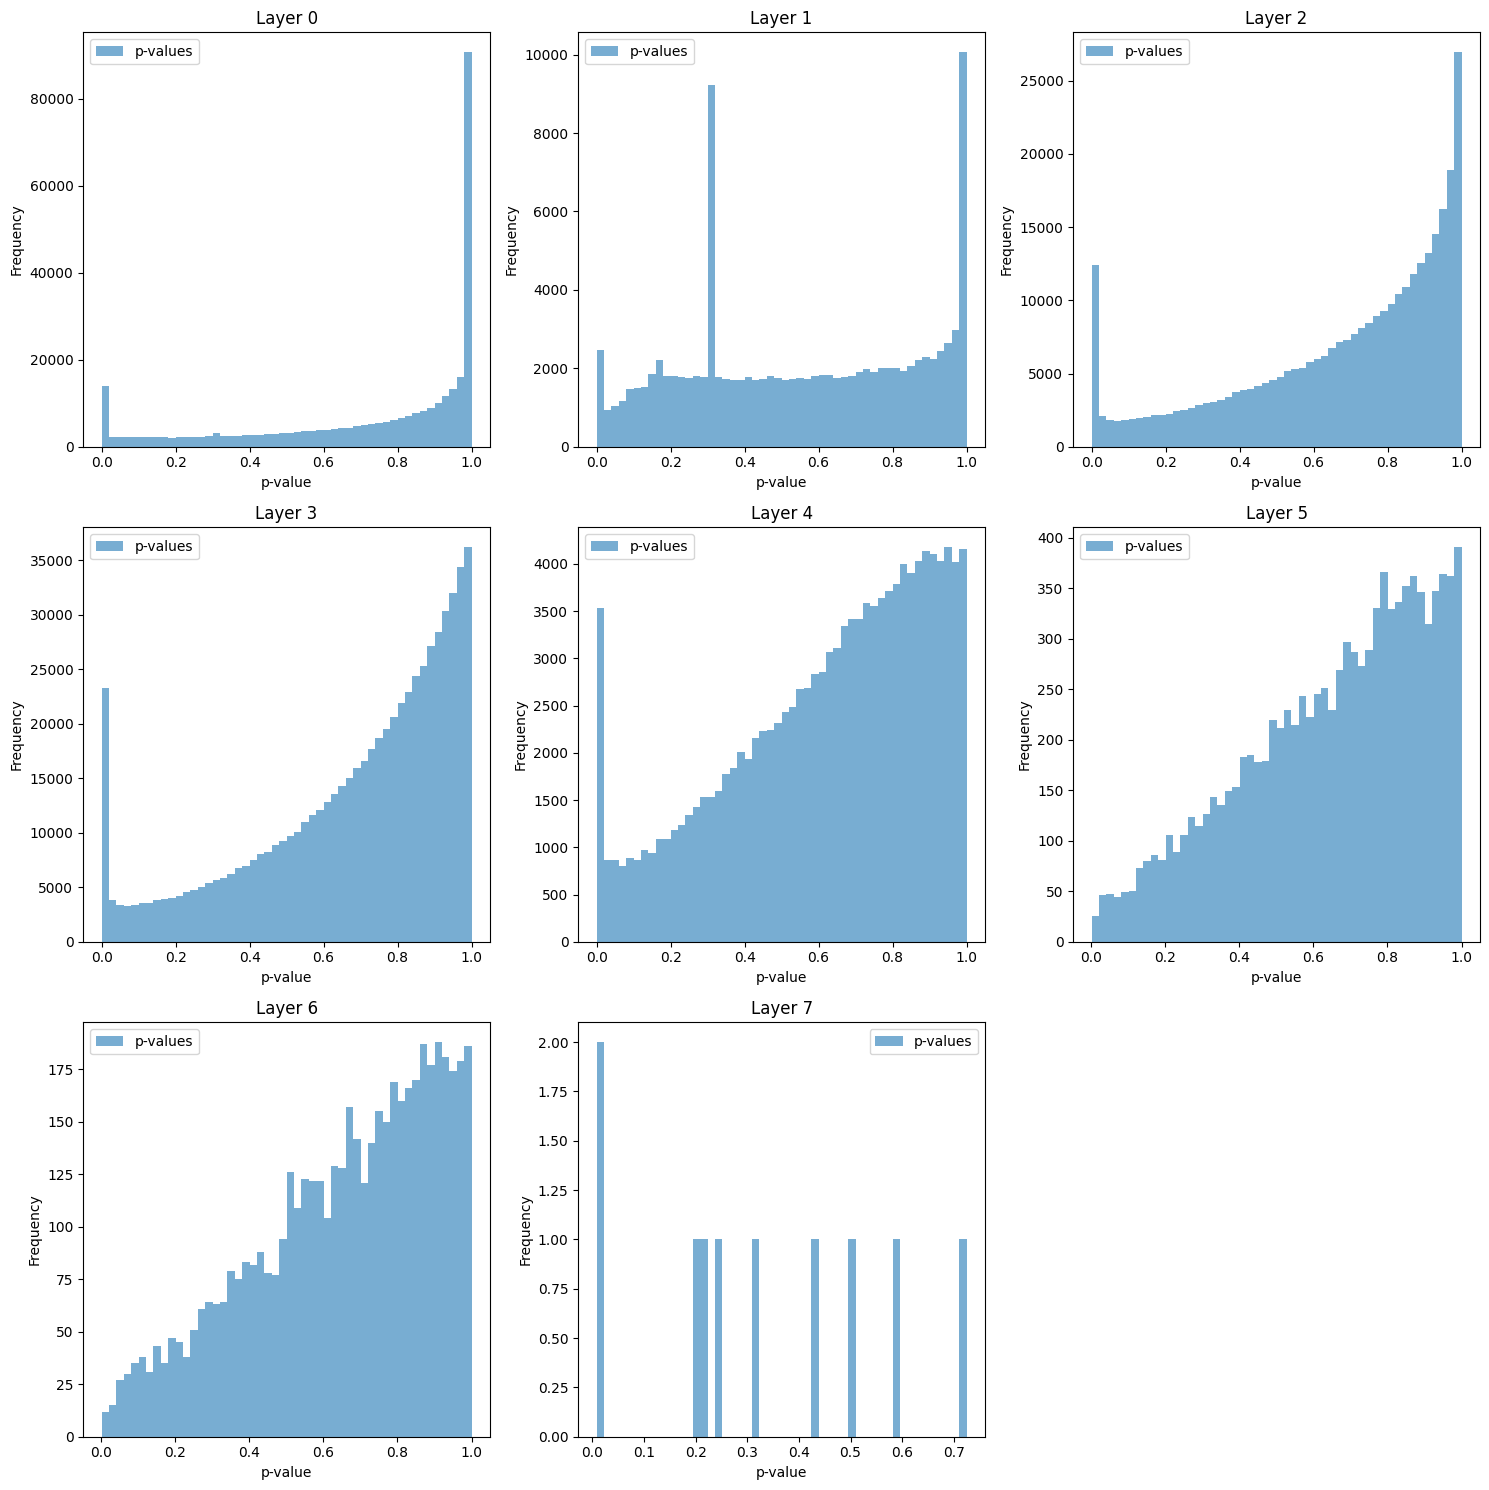

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Load activations
def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True)

# Perform two-sample t-tests comparing neuron activations
def perform_two_sample_t_tests(background_activations, original_activations):
    t_test_results = {}
    for layer in background_activations.keys():
        wp_activations = np.vstack(background_activations[layer])
        wo_activations = np.vstack(original_activations[layer])

        # Perform two-sample t-test for each neuron
        ttest_result = ttest_ind(wp_activations, wo_activations, axis=0)

        t_test_results[layer] = {
            'ttest': ttest_result,
            'wp_means': np.mean(wp_activations, axis=0),
            'wo_means': np.mean(wo_activations, axis=0)
        }
    return t_test_results

# Print t-test results with percentages of neurons below or equal to specific p-values
def print_t_test_results(t_test_results):
    for layer, results in t_test_results.items():
        wp_means = results['wp_means']
        wo_means = results['wo_means']
        ttest = results['ttest']

        # Calculate the percentage of neurons below or equal to specific p-value thresholds
        p_values = ttest.pvalue
        below_or_equal_0_05 = np.mean(p_values <= 0.05) * 100
        below_or_equal_0_02 = np.mean(p_values <= 0.02) * 100

        print(f"Layer {layer}:")
        print("  WP Activations:")
        print(f"    Mean: {wp_means.mean():.4f}")
        print("  WO Activations:")
        print(f"    Mean: {wo_means.mean():.4f}")
        print("  T-Test:")
        print(f"    T-statistic: {ttest.statistic.mean():.4f}")
        print(f"    P-value: {ttest.pvalue.mean():.4f}")
        print(f"    Percentage of neurons with p-value <= 0.05: {below_or_equal_0_05:.2f}%")
        print(f"    Percentage of neurons with p-value <= 0.02: {below_or_equal_0_02:.2f}%")
        print("-" * 50)

# Plot the p-values to visualize significance
def plot_p_values(t_test_results):
    num_layers = len(t_test_results)
    num_cols = 3
    num_rows = (num_layers + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 5 * num_rows))
    for idx, (layer, results) in enumerate(t_test_results.items()):
        p_values = results['ttest'].pvalue

        ax = plt.subplot(num_rows, num_cols, idx + 1)
        ax.hist(p_values, bins=50, alpha=0.6, label='p-values')
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('p-value')
        ax.set_ylabel('Frequency')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers

# Load activations for both left_patch and original conditions
left_patch_activations = {layer: load_activations('left_patch', f'activations.npy_{layer}.npy') for layer in layers_of_interest}
original_activations = {layer: load_activations('original', f'activations.npy_{layer}.npy') for layer in layers_of_interest}

# Perform two-sample t-tests
t_test_results = perform_two_sample_t_tests(left_patch_activations, original_activations)

# Print t-test results
print_t_test_results(t_test_results)

# Plot p-values
plot_p_values(t_test_results)
